In [15]:
%matplotlib inline
import xmitgcm
import xgcm
import xarray as xr
import matplotlib.pyplot as plt
from xlayers import finegrid, layers
from xlayers.core import layers_apply,layers_numpy
import numpy as np
from MITgcmutils import jmd95
import time as time
import matplotlib.colors as colors
from pathlib import Path
import pandas as pd
from scipy.interpolate import interp1d

In [63]:
#load mitgcm output
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer'
#datadir='/Users/boerzhang/Desktop/ocean_project/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_GMadv_nobvp'
prefixes=['Stave','Ttave','vVeltave','uVeltave','wVeltave','DIAG_tracer_adv_diff','PTRtave01','GMflux','Tdiftave','GM_Kwz-T','divergence','GMRediTensor']
#prefixes=['GMRediTensor', 'Tdiftave', 'GMflux', 'DIAG_tracer_adv_diff', 'wVeltave', 'Ttave', 'GM_Kwz-T', 'vVeltave', 'PTRtave01', 'Stave', 'uVeltave','La']
prefixes= ['vVeltave', 'DIAG_tracer_adv_diff', 'GM_Kwz-T', 'PTRtave01', 'wVeltave', 'GMflux', 'Ttave', 'Stave', 'Tdiftave', 'GMRediTensor', 'uVeltave','LaVH1RHO','LaHs1RHO']
datadirGM2x='/Users/anthonymeza/Documents/GitHub/test_age_framework/Single_basin_simulations/restart_6x16_run_134308800_KGM_KGM2xonly_diag_testdiv_gTracer_skewflux_modGMdiagnose'
datadirctr='/Users/anthonymeza/Documents/GitHub/test_age_framework/Single_basin_simulations/control_6x16_run_98893440_diag_Jan12_50year_ModGMdiag'
datadirkappa2x='/Users/anthonymeza/Documents/GitHub/test_age_framework/Single_basin_simulations/kappa2x_6x16_run_164090878_diag_Jan12_50year_ModGMdiag'
datadirRedi2x='/Users/anthonymeza/Documents/GitHub/test_age_framework/Single_basin_simulations/Redi2x_6x16_run_135172800_diag_Jan12_50year_ModGMdiag'

#iters=[134308848]
iters='all'
#prefixes=None
dsGM2x=xmitgcm.open_mdsdataset(datadirGM2x,prefix=prefixes,iters=iters).astype('float').load()
dsctr=xmitgcm.open_mdsdataset(datadirctr,prefix=prefixes,iters=iters).astype('float64').load()
dsRedi2x=xmitgcm.open_mdsdataset(datadirRedi2x,prefix=prefixes,iters=iters).astype('float64').load()
dskappa2x=xmitgcm.open_mdsdataset(datadirkappa2x,prefix=prefixes,iters=iters).astype('float64').load()

In [64]:
dsctr.to_netcdf("../data/single_basin_ctrl.nc", engine = "netcdf4")
dsGM2x.to_netcdf("../data/single_basin_GM2X.nc", engine = "netcdf4")
dsRedi2x.to_netcdf("../data/single_basin_Redi2X.nc", engine = "netcdf4")
dskappa2x.to_netcdf("../data/single_basin_Kappa2X.nc", engine = "netcdf4")


array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [86402.00843551, 86402.00841772, 86402.00149796, ...,
        86401.99851473, 86402.00919637, 86401.99570003],
       [86401.97359008, 86401.986132  , 86401.99622973, ...,
        86401.98347795, 86402.095737  , 86402.04463914],
       ...,
       [           nan, 86402.0238818 , 86402.01708278, ...,
        86401.40010872, 86402.03274125,            nan],
       [           nan, 86402.00214721, 86401.97251708, ...,
        86402.01089881, 86402.01097031,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

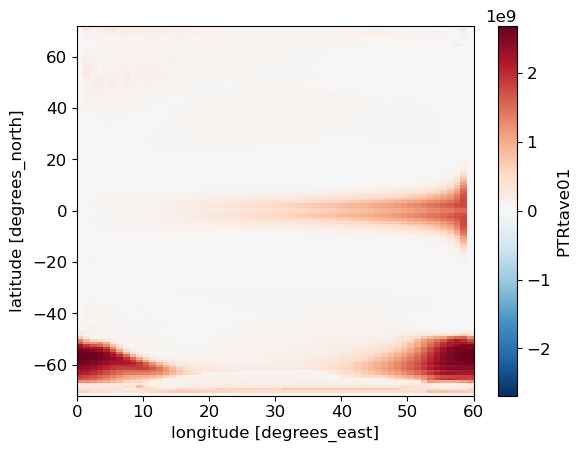

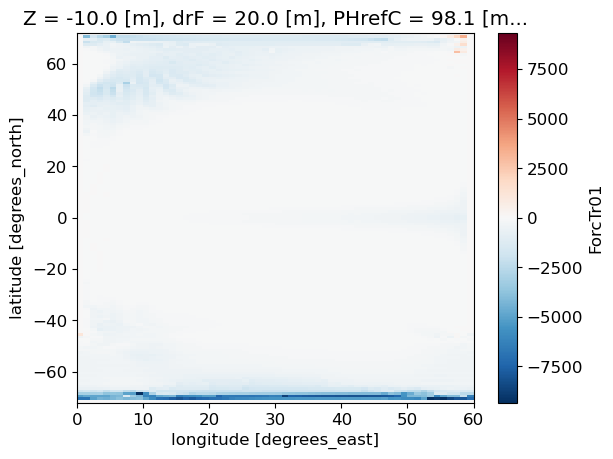

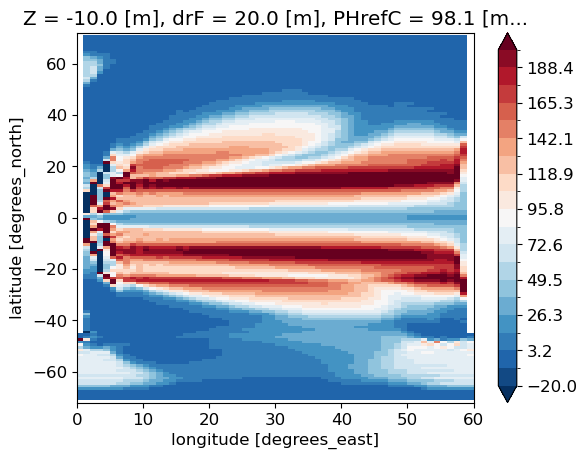

In [65]:
#Analyze age flux
ctrAge=dsctr.PTRtave01.mean('time')

ageSurf=(ctrAge[0:2,:,:].mean('Z'))
plt.figure()
ageSurf.plot()
ctrAgeForc=dsctr.ForcTr01.mean('time')
ageForcSurf=ctrAgeForc[0,:,:]
plt.figure()
ageForcSurf.plot()
plt.figure()
tau=-ageForcSurf/ageSurf
(1/tau/86400).plot(levels=np.linspace(-20,200,20))
(1/tau).values

In [66]:
dsctr_rhokappa2x=dsctr.copy(deep=True)
dsctr_rhokappa2x['Stave']=dsctr_rhokappa2x['Stave']*0+dskappa2x.Stave.values
dsctr_rhokappa2x['Ttave']=dsctr_rhokappa2x['Ttave']*0+dskappa2x.Ttave.values
dsctr_rhokappa2x['layer_1RHO_bounds']=dsctr_rhokappa2x['layer_1RHO_bounds']*0+dskappa2x['layer_1RHO_bounds'].values
# dsctr_rhokappa2x['layer_1RHO_center']=dskappa2x['layer_1RHO_center'].copy()
# dsctr_rhokappa2x['layer_1RHO_interface']=dskappa2x['layer_1RHO_interface'].copy()
# dsctr_rhokappa2x.Stave.max().load()
# dsctr_rhokappa2x.Stave.max().load()
# dsctr_rhokappa2x.Stave.max().load()
#temp=dsctr_rhokappa2x.Stave*0+dskappa2x.Stave
dsctr_rhokappa2x.Stave.max().load()

<xarray.DataArray 'Stave' ()> Size: 8B
array(35.54821396)

In [67]:
def initialize_grid(ds):
    """
    Initialize the xgcm grid with given metrics.
    
    Parameters:
    ds (xarray.Dataset): The dataset to initialize the grid from.
    
    Returns:
    xgcm.Grid: Initialized grid.
    """
    metrics = {
        ('X',): ['dxC', 'dxG'],
        ('Y',): ['dyC', 'dyG'],
        ('Z',): ['drF', 'drC'],
        ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw']
    }
    return xgcm.Grid(ds, periodic=['X'], metrics=metrics)

class myRun: 
    '''
    packed class for a MITgcm simulation: saving some intermidiate variables,
    and implementing some functions for calculation and plotting.
    The goal is to reduce unnecessary repeat of code for analyzing different simulations
    '''
    def __init__(self,dataset:xr.Dataset,Kgm=500,Kredi=500,nxkappa=1):
        
        self.ds=dataset
        ## init grid
#         metrics = {
#             ('X',): ['dxC', 'dxG'], # X distances
#             ('Y',): ['dyC', 'dyG'], # Y distances
#             ('Z',): ['drF', 'drC'], # Z distances
#             ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
#         }
#         self.grid=xgcm.Grid(self.ds, periodic=['X'], metrics=metrics)
        self.grid = initialize_grid(self.ds)
        self.rhoinit()
        self.kappainit(nxkappa=nxkappa)
        ## init GM parameters Kuz,Kvy,Kwx,Kwy
        self.calc_GM_parameters(Kgm=Kgm,Kredi=Kredi)  
        self.calc_GM_vels()
        ################################################
        #Volume advective transport (Eulerian+gm)
        xA=self.ds.dyG*self.ds.drF
        yA=self.ds.dxG*self.ds.drF
        self.fVolEux=self.ds.uVeltave.mean('time')*xA
        self.fVolEuy=self.ds.vVeltave.mean('time')*yA
        self.fVolEur=self.ds.wVeltave.mean('time')*self.ds.rA
        self.fVolgmx=self.ugmFromTensor.fillna(0)*xA.fillna(0)
        self.fVolgmy=self.vgmFromTensor.fillna(0)*yA.fillna(0)
        self.fVolgmr=self.wgmFromTensor.fillna(0)*self.ds.rA.fillna(0)
        
        self.fVolx=self.fVolEux+self.fVolgmx
        self.fVoly=self.fVolEuy+self.fVolgmy
        self.fVolr=self.fVolEur+self.fVolgmr
        ################################################
        self.calcOptlayer()
        self.rho_binning(self.layers1_bounds)
        self.init_rho_for_layer()
        self.calc_layer_depth()
        
    
        
    def kappainit(self,nxkappa=1):
        '''
        Initialize BL diapycnal diffusivity kappa (kdia3d)
        nxkappa: kappa times n (for 2xkappa run)
        '''
        #BryanLewis kappa profile
        diffKrBL79surf=2e-5;
        diffKrBL79deep= 1e-4;
        diffKrBL79Ho  = -2000;
        diffKrBL79scl = 150;
        #A hack to broadcast Zl to 3D
        Z3d=0*self.ds.rA+self.ds.Zl
        kdia3d=diffKrBL79surf+(diffKrBL79deep-diffKrBL79surf)*(np.arctan(-(Z3d-diffKrBL79Ho)/diffKrBL79scl)/np.pi+0.5 );
        kdia3d=kdia3d.transpose('Zl','YC','XC')
        self.kdia3d=nxkappa*kdia3d
        self.nxkappa=nxkappa

    def rhoinit(self,rhoConst=1035,use_pd=True,refPres=2000):
        '''
        calculate the density surfaces
        use_pd: calculate potential density rather than locally referred
        refPres: reference pressure for potential density in dbar
        '''

        Stave=self.ds.Stave.mean('time')
        Ttave=self.ds.Ttave.mean('time')

        Stave=Stave.where(Stave!=0)
        if use_pd:
            rho3D=jmd95.densjmd95(Stave,Ttave,refPres)    
        else:
            locPres3D=self.ds.locPres.broadcast_like(Stave)
            locPres=self.ds.PHrefC*rhoConst
            rho3D=jmd95.densjmd95(Stave,Ttave,locPres3D/10000)
        self.rho3D=0*Stave+rho3D
    
    
    
    def rho_binning(self,layers1_bounds):
        '''
        Binning rho3D into density bins decided by layers1_bounds
        add self.rhoindex
        '''
        #is it reasonable to put layers1_bounds into the class? Jan8,2023
        self.layers1_bounds=layers1_bounds
        #def rhoidinit(self):
        '''
        calculate rhoindex based on rho3D data and layers1_bounds
        There used to be a helper function but is removed now
        '''
        self.Nlayersbin=len(self.layers1_bounds)
        rhoindex=0*self.rho3D.load().data
        rho3Ddata=self.rho3D.load().data
        [Nz,Ny,Nx]=rhoindex.shape

        #layers1_bounds: boundary of layers, index 1:N (or 0:N-1 in python)
        #rhoindex:index for rho at the center of layers1_bounds index 1:N-1 (or 0:N-2 in python)

        for idx in range(Nx):
            for idy in range(Ny):     
                for idz in range(Nz):
                    rhotemp=rho3Ddata[idz,idy,idx]-1000
                    #print(rhotemp.load())
                    if np.isnan(rhotemp):
                        rhoindex[idz,idy,idx]=np.nan
                        continue
                    #rhoid_currentgrid=0
                    for idrho in range(1,self.Nlayersbin):
                        rhoid_currentgrid=idrho-1 # grid idrho-1 between boundary [idrho-1, idrho]

                        if rhotemp<layers1_bounds[idrho]:
                            break
                    #print(rhoid_currentgrid)
                    rhoindex[idz,idy,idx]=rhoid_currentgrid
        self.rhoindex=rhoindex
        [nz,ny,nx]=rhoindex.shape
        self.rhoindext=rhoindex[np.r_[0,0:nz-1],:,:]
        self.rhoindexs=rhoindex[:,np.r_[0,0:ny-1],:]
        self.rhoindexn=rhoindex[:,np.r_[1:ny,ny-1],:]
        self.rhoindexw=rhoindex[:,:,np.r_[nx-1,0:nx-1]]
        self.rhoindexe=rhoindex[:,:,np.r_[1:nx,0]]

    
    
    '''    
    def plotsst(self):
        #implemented
        pass
    def plotEmP(self):
        #not implemented
        pass
    def rhoinit(self,layers1_bounds=layers1_bounds,rhoConst=1035,use_pd=True,refPres=2000):
        pass
    ''' 
    def calc_GM_parameters(self,Kgm=500,Kredi=500,modifiedGMTensor=True):
        '''
        calculating 4 GM parameters (Kuz,Kvy,Kwx,Kwy) from model diagnostics (separating Redi term)
        '''       
        #modifiedGMTensor=True
        if modifiedGMTensor is True:
            #Kgm=1000
            #Kredi=500
            print("Kgm:",Kgm,"Kredi",Kredi)
            self.GM_Kuz_gm=-self.ds.GM_Kuz.mean('time')*Kgm
            self.GM_Kvy_gm=-self.ds.GM_Kvy.mean('time')*Kgm
            self.GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm
            self.GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm

        else:
            raise ValueError("Not implemented")
            Kgm=1000
            Kredi=500
            GM_Kuz_gm=self.ds.GM_Kuz.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kvy_gm=self.ds.GM_Kvy.mean('time')*Kgm/(Kgm-Kredi)
            GM_Kwx_gm=self.ds.GM_Kwx.mean('time')*Kgm/(Kgm+Kredi)
            GM_Kwy_gm=self.ds.GM_Kwy.mean('time')*Kgm/(Kgm+Kredi)
    #########################################################################
    #This block is calculating GM velocities
    def calc_GM_vels(self):
        '''
        calculating GM velocities
        '''
        #This
        maskGMPsiX=self.grid.interp(self.grid.interp(self.ds.maskC.where(self.ds.maskC),'Z', boundary = "fill", fill_value = np.nan),'X')
        maskGMPsiX[0,:,:]=np.nan #mask top layer
        maskGMPsiX=maskGMPsiX.fillna(0)
        maskGMPsiY=self.grid.interp(self.grid.interp(self.ds.maskC.where(self.ds.maskC),'Z', boundary = "fill", fill_value = np.nan),'Y', boundary = "fill", fill_value = np.nan)
        maskGMPsiY[0,:,:]=np.nan #mask top layer
        maskGMPsiY=maskGMPsiY.fillna(0)
        maskr=self.grid.interp(self.ds.maskC.astype('double'),'Z', boundary = "fill", fill_value = np.nan)
        maskr=maskr.where(maskr>0.5)
        maskr=maskr.fillna(0)
        PsixGM_Tensor=self.grid.interp(self.GM_Kwx_gm*self.ds.rA,'X', boundary = "fill", fill_value = np.nan)/self.ds.rAw
        PsixGM_Tensor=PsixGM_Tensor.where(maskGMPsiX)
        PsixGM_Tensor=PsixGM_Tensor.fillna(0)
        delPsixGM_Tensor=self.grid.diff(PsixGM_Tensor,'Z',boundary='fill')
        ugmFromTensor=delPsixGM_Tensor/self.ds.drF*self.ds.hFacW
        PsiyGM_Tensor=self.grid.interp(self.GM_Kwy_gm*self.ds.rA,'Y', boundary = "fill", fill_value = np.nan)/self.ds.rAs
        PsiyGM_Tensor=PsiyGM_Tensor.where(maskGMPsiY)
        PsiyGM_Tensor=PsiyGM_Tensor.fillna(0)
        delPsiyGM_Tensor=self.grid.diff(PsiyGM_Tensor,'Z',boundary='fill')
        vgmFromTensor=delPsiyGM_Tensor/self.ds.drF*self.ds.hFacS
        wgmFromTensor=self.grid.diff(PsixGM_Tensor*self.ds.dyG,'X',boundary='periodic')+self.grid.diff(PsiyGM_Tensor*self.ds.dxG,'Y', boundary = "fill", fill_value = np.nan)
        wgmFromTensor=wgmFromTensor/self.ds.rA
        wgmFromTensor=wgmFromTensor.fillna(0)
        wgmFromTensor=maskr*wgmFromTensor
        self.ugmFromTensor=ugmFromTensor
        self.vgmFromTensor=vgmFromTensor
        self.wgmFromTensor=wgmFromTensor
        
    def init_rho_for_layer(self):
        # interpolating rho to u/v grids
        rhoatV=self.grid.interp(self.rho3D,'Y', boundary = "fill", fill_value = np.nan)
        rhoatU=self.grid.interp(self.rho3D,'X', boundary = "fill", fill_value = np.nan)
        rhoatU=rhoatU.fillna(0)
        rhoatV=rhoatV.fillna(0)


        #Volume flux in x/y direction
        #tmpfVoly=self.fVolEuy+self.fVolgmy
        #tmpfVolx=self.fVolEux+self.fVolgmx
        
        #nonan here means???
        ##############################################
        #This block below interpolates the data below the bottom of the ocean,
        #to avoid strange behavior of density interpolation
        ##############################################
        rhoatV_nonan=rhoatV.copy().load().data
        rhoatU_nonan=rhoatU.copy().load().data
        rho_nonan=self.rho3D.copy().load().data
        
        
        [nz,ny,nx]=rhoatV_nonan.shape
        for i in range(nx):
            for j in range(ny):
                rhotempV=0
                rhotempU=0
                rhotemp0=0
                for k in range(nz):
                    if(np.isnan(rhoatV_nonan[k,j,i])):
                        rhoatV_nonan[k,j,i]=rhotempV
                    else:
                        rhotempV=rhoatV_nonan[k,j,i]
                    if(np.isnan(rhoatU_nonan[k,j,i])):
                        rhoatU_nonan[k,j,i]=rhotempU
                    else:
                        rhotempU=rhoatU_nonan[k,j,i]
                    if(np.isnan(rho_nonan[k,j,i])):
                        rho_nonan[k,j,i]=rhotemp0
                    else:
                        rhotemp0=rho_nonan[k,j,i]
        ###############################################                
        #turn numpy variables into xarray variables
        rhoatV_nonan=rhoatV.fillna(0)*0+rhoatV_nonan
        rhoatU_nonan=rhoatU.fillna(0)*0+rhoatU_nonan
        rho_nonan=self.rho3D.fillna(0)*0+rho_nonan
        
        self.rho_nonan=rho_nonan
        self.rhoatV_nonan=rhoatV_nonan
        self.rhoatU_nonan=rhoatU_nonan
        
    def calc_layer_depth(self):
        '''
        calc_streamfunction
        '''
        def layer_depth_interp_mat(sLayer_mat,sZ_mat,Z):
            '''
            Calculating the mean depth of density layer sigma
            sLayer_mat: an array of sLayer
            sZ_mat: an array of sZ
            Z: depth Z
            '''
            def layer_depth_interp_1d(sLayer,sZ,Z):
                '''
                Calculating the mean depth of density layer sigma
                sLayer: area below (density) Layer sigma
                sZ: area below depth Z
                Z: depth Z
                '''

                #if(sLayer[0]==0):
                    ##a dirty hack to remove basin edges (on northern/southern end)
                    #return np.nan*sLayer
                #coeff1=np.polyfit(sZ,Z,40)
                #eqfit=np.poly1d(coeff1)
                #ZLayer=eqfit(sLayer)
                fnew=interp1d(sZ,Z,fill_value="extrapolate")
                ZLayer=fnew(sLayer)
                return ZLayer

            [Ny,Nlayer]=sLayer_mat.shape
            Zlayer_mat=np.zeros([Ny,Nlayer])
            for iy in range(Ny):
                #print("iy:",iy)
                Zlayer_mat[iy,:]=layer_depth_interp_1d(sLayer_mat[iy,:],sZ_mat[iy,:],Z,)
            Zlayer_mat[Zlayer_mat>0]=0
            Zlayer_mat[Zlayer_mat<-4000]=-4000
            return Zlayer_mat
        
        
        
        ###############################################
        ##if the resolution is not high enough, the streamfunction will not be smooth 
        ##perhaps using a non-linear scale would be better, though
        
        layers1_bounds_streamfunc=self.ds.layer_1RHO_bounds.load().data#np.linspace(29,37.5,1000)
        dz_layers_atV= layers_apply(self.ds.hFacS,(self.rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        #print("dz_layers_atV.shape:",dz_layers_atV.shape)
        #dz_layers_atV=(self.ds.LaHs1RHO).mean('time').transpose('YG','XC','layer_1RHO_center')
        #print("dz_layers_atV.shape(LaHs1RHO):",dz_layers_atV.shape)
        dz_layers_atV_zonalsum=dz_layers_atV.sum('XC')
        z_layers_atV_zonalsum=dz_layers_atV_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        z_area_below=self.ds.drF.where(self.ds.hFacS==1).sum('XC').transpose('YG','Z')
        z_area_below=z_area_below[:,::-1].cumsum('Z')[:,::-1]
        [Ny,Nz]=z_area_below.shape
        z_area_below_np=np.zeros([Ny,Nz+1])
        z_area_below_np[:,:-1]=z_area_below
        layer_depth=layer_depth_interp_mat(z_layers_atV_zonalsum.load().data,z_area_below_np,self.ds.Zp1)
        self.layer_depth=layer_depth
        self.layers1_bounds_streamfunc=layers1_bounds_streamfunc
        
        
        
    def draw_streamfunc_depth(self):
        '''
        draw_streamfunction
        '''
        #layers1_bounds_streamfunc=self.layers1_bounds
        #layers1_bounds=dsGM2xADVForm.layer_1RHO_bounds.load().data
        dPsiY_layers= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        dPsiX_layers= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        #test
        #print("dPsiX_layers.shape:",dPsiY_layers.shape)
        #dPsiY_layers=(self.ds.LaVH1RHO*self.ds.dxG).mean('time').transpose('YG','XC','mylayer_1RHO_center')
        #print("dPsiX_layers.shape(LaVH1RHO):",dPsiY_layers.shape)
        #dz_layers(3D)

        #zeta_500
        #dPsiX_layers= layers_apply(xr.ones_like(fVoly_nobvp.fillna(0)), (rhoatV.fillna(1030)-1000), np.array(layers1_bounds), dsGM2x.drF, dsGM2x.drC, 1, 'Z', 'layer_1RHO_bounds')
        #dPsiX_layers_zonalsum=
        dPsiY_layers_zonalsum=(dPsiY_layers).sum('XC') 
        PsiY_layers_zonalsum=-dPsiY_layers_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
        self.PsiY_layers_zonalsum=PsiY_layers_zonalsum


        #plt.contourf(0*PsiY_layers_zonalsum.T+dsGM2x.YG,layer_depth.T,PsiY_layers_zonalsum.T/1e6,levels=np.linspace(-10,10,20),vmin=-10,vmax=10,cmap='seismic')
        XX=(0*self.PsiY_layers_zonalsum.T+self.ds.YG).load().data
        YY=self.layer_depth.T
        ZZ=(self.PsiY_layers_zonalsum.T.rolling(YG=5).mean()/1e6).load().data
        ZZ[np.isnan(YY)]=np.nan
        YY[np.isnan(YY)]=0

        #print(XX)
        #print(YY)
        print(ZZ)
        im=plt.contourf(XX.T,YY.T,ZZ.T,levels=np.linspace(-13.5,13.5,28),vmin=-13.5,vmax=13.5,cmap='seismic',extend='both')
        
        
        
        #print("max:",np.nanmax(ZZ))
        #print("min:",np.nanmin(ZZ))
        #plt.contourf(-PsiX_layers_zonalsum.T/1e6,cmap='seismic')
        #plt.colorbar(ticks=np.linspace(-9.5,9.5,20))
        return im
    ###########################################################################
    def calcOptlayer(self,Nnewlayer=16,rhoref=1000):
        'Calculate optimal layer bounds'
        layers1_bounds=[28,29,30,31,32,33,34,
             35.15,
             36.52,
             37.02,
             37.18,
             37.23,
             37.24,
             37.25,
             37.262,
             37.271,
             37.279,
             37.286,
             37.294,
             37.302,
             37.310,
             37.318,
             37.324,
             37.330,
             37.34,
             37.35,37.36,37.37]
        def rhoInt(Xdata,rhoindex,Nlayersbin):
            ''''''
            'Integrate Xdata at density layers'
            ''''''
            dX_rho=np.zeros([Nlayersbin,1])
            [Nz,Ny,Nx]=rhoindex.shape
            for idx in range(Nx):
                for idy in range(Ny):
                    for idz in range(Nz): 
                        rhoindextemp=rhoindex[idz,idy,idx]
                        if(~np.isnan(rhoindextemp)):  
                            dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
            return np.cumsum(dX_rho[::-1])[::-1]
        self.Vol=self.ds.rA*self.ds.drF
        Voldata=self.Vol.transpose('Z','YC','XC').load().data
        self.rho_binning(layers1_bounds)
        sumVol_rho=rhoInt(Voldata,self.rhoindex,len(layers1_bounds))
        fnew=interp1d(sumVol_rho,layers1_bounds,fill_value="extrapolate")
        linear_volume=np.linspace(0.001e17,3.095e17,Nnewlayer)
        linear_volume=linear_volume[::-1]
        layers1_bounds_temp=fnew(linear_volume)
        layers1_bounds_final=np.zeros(len(layers1_bounds_temp))
        layers1_bounds_final=layers1_bounds_temp.copy()
        layers1_bounds_final[0]=min(self.rho3D.min()-rhoref, layers1_bounds_final[0])
        layers1_bounds_final[-1]=max(self.rho3D.max()-rhoref,layers1_bounds_final[-1])
        self.layers1_bounds=layers1_bounds_final

        
        
        
        
        
        

#dealing with potential density/density boundaries



In [68]:
RunGM2x=myRun(dsGM2x,Kgm=1000,Kredi=500,nxkappa=1)
Runctr=myRun(dsctr,Kgm=500,Kredi=500,nxkappa=1)
Runkappa2x=myRun(dskappa2x,Kgm=500,Kredi=500,nxkappa=2)
RunRedi2x=myRun(dsRedi2x,Kgm=500,Kredi=1000,nxkappa=1)
#Runkappa2x=myRun(dsctr_rhokappa2x,Kgm=500,Kredi=500,nxkappa=1)

Kgm: 1000 Kredi 500


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Kgm: 500 Kredi 500


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Kgm: 500 Kredi 500


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Kgm: 500 Kredi 1000


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


[29.73783336 35.80273659 36.752268   37.08455728 37.195895   37.23294747
 37.24842967 37.26003232 37.26777134 37.27422167 37.27996541 37.28474126
 37.29125951 37.30067587 37.31643539 37.35652338]
(144, 435)
(144, 435)
(144, 435)
[[  nan   nan   nan ...   nan   nan   nan]
 [ 1.   10.   20.   ... 37.98 37.99 38.  ]
 [ 1.   10.   20.   ... 37.98 37.99 38.  ]
 ...
 [ 1.   10.   20.   ... 37.98 37.99 38.  ]
 [ 1.   10.   20.   ... 37.98 37.99 38.  ]
 [  nan   nan   nan ...   nan   nan   nan]]


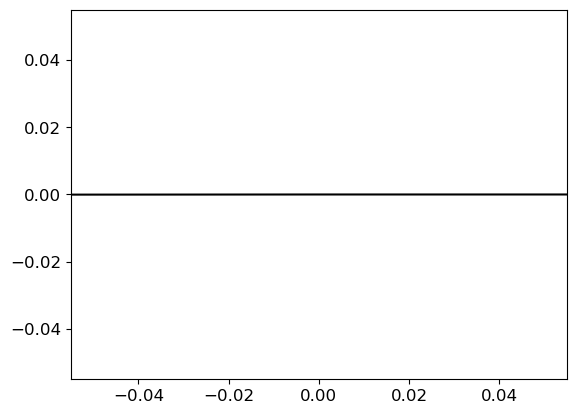

In [69]:

#Runkappa2x.calcOptlayer(15)
print(RunGM2x.layers1_bounds)
def plot_rhocontours(self):
    '''
    plotting rho contours for myRun class
    '''
    CS=(self.rho3D-1000).mean('XC').plot.contour(levels=self.layers1_bounds,linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
    
def plot_rhocontours_rhomean(self):
    
    layer2D,YGgrid=(np.meshgrid(self.ds.layer_1RHO_bounds.load().data, self.ds.YG))
    print(layer2D.shape)
    print(self.layer_depth.shape)
    print(YGgrid.shape)
    #layer2D[self.layer_depth==0]=np.nan
    #layer2D[self.layer_depth<-4000]=np.nan
    layer2D[-1,:]=np.nan
    layer2D[0,:]=np.nan
    print(layer2D)
    CS=plt.contour(YGgrid,self.layer_depth,layer2D,levels=self.layers1_bounds[:-1],linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
    #plt.colorbar()
myRun.plot_rhocontours_rhomean=plot_rhocontours_rhomean
RunRedi2x.plot_rhocontours_rhomean()

/var/folders/k7/tch_9kz957x4jxjqlctv2shc0000gn/T/ipykernel_15559/415707188.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Greys_r',20)


NameError: name 'savedir' is not defined

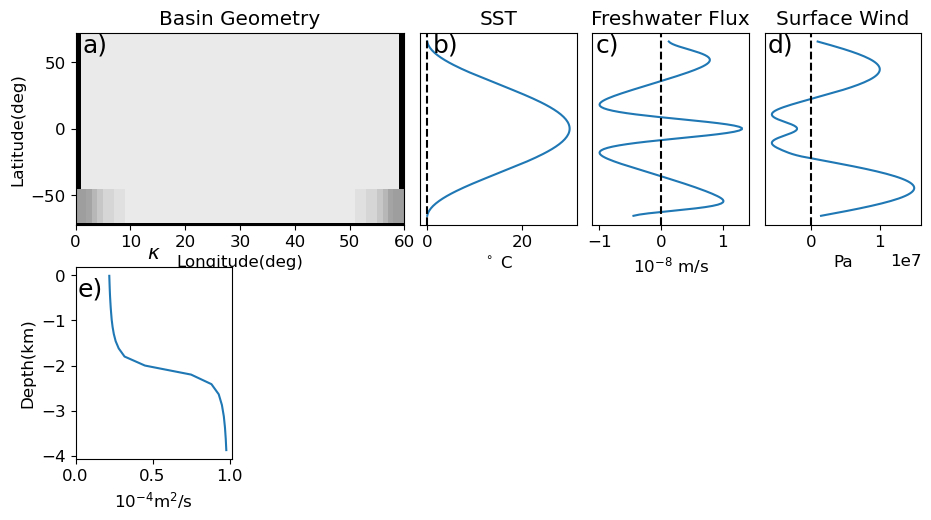

In [70]:
#Figure1

myfigsize = (10, 5)
#make a figure
fig=plt.figure(figsize=myfigsize)
ax1=plt.subplot2grid((6, 5), (0, 0),colspan=2,rowspan=3)
ax2=plt.subplot2grid((6, 5), (0, 2),rowspan=3)
ax3=plt.subplot2grid((6,5),  (0, 3),rowspan=3)
ax4=plt.subplot2grid((6,5 ), (0, 4),rowspan=3)
ax5=plt.subplot2grid((6,5 ), (3, 0),rowspan=3)
plt.rc('font', size=12)
fig.tight_layout()

#plot Basin Geometry
#plt.subplot(1,2,1)
plt.sca(ax1)
def plotBasinGeometry(self,add_colorbar=True):
        def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
            '''
            truncate colormap to get a partial colormap
            This function is used to create a
            #This function is from stackoverflow 
            https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

            '''
            new_cmap = colors.LinearSegmentedColormap.from_list(
                'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
            return new_cmap
        cmap=plt.cm.get_cmap('Greys_r',20)
        cmap=truncate_colormap(cmap,0,0.8)
        #cmap.set_over('c')
        #self.ds.Depth.plot( cmap=cmap,add_colorbar=add_colorbar)
        self.ds.Depth.plot( cmap=cmap,add_colorbar=False)
        #plt.gca().set_facecolor("grey")
        plt.xlabel('Longitude(deg)')
        plt.ylabel('Latitude(deg)')
        plt.title('Basin Geometry')
        
myRun.plotBasinGeometry=plotBasinGeometry
RunGM2x.plotBasinGeometry()
plt.annotate("a)",xy=(0.02,0.9),xycoords="axes fraction",fontsize=18)

#plt.subplot(2,4,5)
#plt.plot(RunGM2x.kdia3d.mean('XC').mean('YC')*1e4,RunGM2x.ds.Zl/1e3)
#plt.plot(Runkappa2x.kdia3d.mean('XC').mean('YC')*1e4,RunGM2x.ds.Zl/1e3)
#plt.xticks([0.2,0.4,0.6,0.8,1.0])
#plt.xlabel('Diapycnal Diffusivity $\kappa$ (10$^{-4}$ m$^2$s$^{-1}$)')
#plt.ylabel('Depth(km)')
#plt.subplot(1,6,4)
plt.sca(ax2)
#plot sst
sstfile=Path(datadirRedi2x+"/sst_Atlonly.bin")
def plotsst(self,filename=sstfile): 
    sst=0*dsGM2x.Depth
    sst=sst+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
    sst.where(sst!=0).mean('XC').plot(y='YC')
    plt.xlabel('$^\circ$ C')
    #plt.xlabel('Latitude(deg)')
    plt.ylabel('')
    plt.title('SST')
    plt.gca().set_yticks([])
    self.sst=sst
myRun.plotsst=plotsst
RunGM2x.plotsst(sstfile)
plt.axvline(x=0,color='k',linestyle='dashed')
##plot Emp: not included into the myRun class. Seems not necessary.
#plt.subplot(1,6,5)
plt.annotate("b)",xy=(0.08,0.9),xycoords="axes fraction",fontsize=18)
plt.sca(ax3)
sstfile=Path(datadirRedi2x+"/EmP_Atlonly.bin")
EmP=0*dsGM2x.Depth
EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
(-EmP.where(RunGM2x.sst!=0).mean('XC')*1e8).plot(y='YC')
plt.xlabel('$10^{-8}$ m/s')
plt.ylabel('')
plt.gca().set_yticks([])
plt.title('Freshwater Flux')
plt.axvline(x=0,color='k',linestyle='dashed')
#plt.gca().set_xticks([])
#plotsurfacewind
#plt.subplot(1,6,6)
plt.annotate("c)",xy=(0.02,0.9),xycoords="axes fraction",fontsize=18)
plt.sca(ax4)
sstfile=Path(datadirRedi2x+"/taux_Atlonly.bin")
EmP=0*dsGM2x.Depth
EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
(EmP.where(RunGM2x.sst!=0).mean('XC')*1e8).plot(y='YC')
plt.xlabel('Pa')
plt.ylabel('')
plt.title("Surface Wind")
plt.gca().set_yticks([])
plt.subplots_adjust(wspace=0.1,hspace=1.2,bottom=0.1,right=0.9)
plt.axvline(x=0,color='k',linestyle='dashed')
plt.annotate("d)",xy=(0.02,0.9),xycoords="axes fraction",fontsize=18)
#plt.gca().set_xticks([])

plt.sca(ax5)

plt.plot(Runctr.kdia3d[:,0,0]*10000,Runctr.ds.Z/1000)
plt.ylabel('Depth(km)')
plt.xlabel(r'$10^{-4}$m$^2$/s')
plt.xlim(left=0)
#sstfile=Path(datadirRedi2x+"/EmP_Atlonly.bin")
#EmP=0*dsGM2x.Depth
#EmP=EmP+xmitgcm.utils.read_raw_data(sstfile,np.dtype('>f'),dsGM2x.rA.shape)
#(-EmP.where(RunGM2x.sst!=0).mean('XC')*1e8).plot(y='YC')
#plt.xlabel('$10^{-8}$ m/s')
#plt.ylabel('')
#plt.gca().set_yticks([])
plt.title(r'$\kappa$')
plt.annotate("e)",xy=(0.01,0.85),xycoords="axes fraction",fontsize=18)

fig.savefig(Path(savedir+'model_config.pdf'), bbox_inches='tight')



/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[           nan            nan            nan ...  8.7499998e-08
   0.0000000e+00            nan]
 [           nan            nan            nan ...  1.1562500e-07
   2.8125001e-08            nan]
 [           nan            nan            nan ...  6.5625002e-08
  -2.1875000e-08            nan]
 ...
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]]


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[           nan            nan            nan ...  4.2500002e-07
  -5.9687500e-07            nan]
 [           nan            nan            nan ...  4.8750002e-07
  -5.3437503e-07            nan]
 [           nan            nan            nan ...  3.6250000e-07
  -6.5937502e-07            nan]
 ...
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]]


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[           nan            nan            nan ... -2.3000000e-06
  -2.2593752e-06            nan]
 [           nan            nan            nan ... -2.1968751e-06
  -2.1562500e-06            nan]
 [           nan            nan            nan ... -2.2218749e-06
  -2.1812500e-06            nan]
 ...
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]
 [           nan            nan            nan ...  0.0000000e+00
   0.0000000e+00            nan]]


/Users/anthonymeza/miniforge3/lib/python3.11/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[          nan           nan           nan ... -6.093750e-07
  -3.375000e-07           nan]
 [          nan           nan           nan ... -4.546875e-07
  -1.828125e-07           nan]
 [          nan           nan           nan ... -4.546875e-07
  -1.828125e-07           nan]
 ...
 [          nan           nan           nan ...  0.000000e+00
   0.000000e+00           nan]
 [          nan           nan           nan ...  0.000000e+00
   0.000000e+00           nan]
 [          nan           nan           nan ...  0.000000e+00
   0.000000e+00           nan]]


NameError: name 'savedir' is not defined

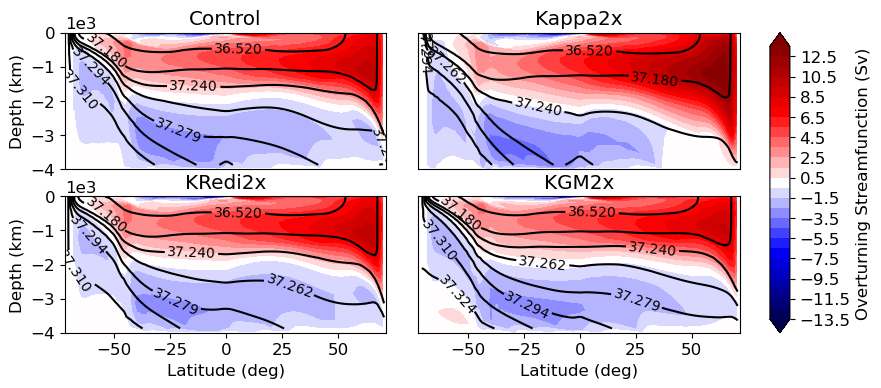

In [71]:

layers1_bounds_streamfunc=[29,
     35.15,
     36.52,
     37.02,
     37.18,
     37.23,
     37.24,
     37.25,
     37.262,
     37.271,
     37.279,
     37.286,
     37.294,
     37.302,
     37.310,
     37.318,
     37.324,
     37.330,
     37.36]
'''
RunGM2x.rho_binning(layers1_bounds)
Runctr.rho_binning(layers1_bounds)
Runkappa2x.rho_binning(Runkappa2x.layers1_bounds_opt)
RunRedi2x.rho_binning(layers1_bounds)
'''
def plot_rhocontours(self,layers1_bounds_streamfunc=layers1_bounds_streamfunc):
    '''
    plotting rho contours for myRun class
    '''
    CS=(self.rho3D-1000).mean('XC').plot.contour(levels=layers1_bounds_streamfunc[::2],linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_rhocontours=plot_rhocontours
#Plot streamfunction and density layers
fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_rhocontours()
Runctr.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.xlabel('')
plt.ylabel('Depth (km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_rhocontours()
Runkappa2x.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_rhocontours()
RunRedi2x.draw_streamfunc_depth()
#plt.gca().set_xticks([])
plt.xlabel('Latitude (deg)')
plt.ylabel('Depth (km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('KRedi2x')
plt.subplot(2,2,4)

RunGM2x.plot_rhocontours()
im=RunGM2x.draw_streamfunc_depth()
plt.gca().set_yticks([])
plt.ylabel('')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x')
#plt.colorbar()

plt.subplots_adjust(hspace=0.2, wspace=0.1,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Overturning Streamfunction (Sv)')
cbar.set_ticks(np.arange(-13.5,13.51,2))
fig.savefig(Path(savedir+'Streamfunction.pdf'), bbox_inches='tight')



/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[           nan            nan            nan ... 4.81263542e-07
  5.40913963e-07 3.04203796e-07]
 [           nan            nan            nan ... 4.81263542e-07
  5.40913963e-07 3.04203796e-07]
 [           nan            nan            nan ... 4.81263542e-07
  5.40913963e-07 3.04203796e-07]
 ...
 [           nan            nan            nan ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [           nan            nan            nan ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [           nan            nan            nan ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[            nan             nan             nan ... -2.49158752e-07
  -9.55582428e-07 -1.18169479e-06]
 [            nan             nan             nan ... -2.49158752e-07
  -9.55582428e-07 -1.18169479e-06]
 [            nan             nan             nan ... -2.49158752e-07
  -9.55582428e-07 -1.18169479e-06]
 ...
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[            nan             nan             nan ... -1.65239067e-06
  -1.86335258e-06 -1.94004059e-06]
 [            nan             nan             nan ... -1.65239067e-06
  -1.86335258e-06 -1.94004059e-06]
 [            nan             nan             nan ... -1.65239067e-06
  -1.86335258e-06 -1.94004059e-06]
 ...
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/xlayers/core.py:107: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  data_out = xr.apply_ufunc(layers_numpy, data_in, theta_in,


[[            nan             nan             nan ... -6.90618324e-07
  -9.48091507e-07 -5.43983841e-07]
 [            nan             nan             nan ... -6.90618324e-07
  -9.48091507e-07 -5.43983841e-07]
 [            nan             nan             nan ... -6.90618324e-07
  -9.48091507e-07 -5.43983841e-07]
 ...
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [            nan             nan             nan ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


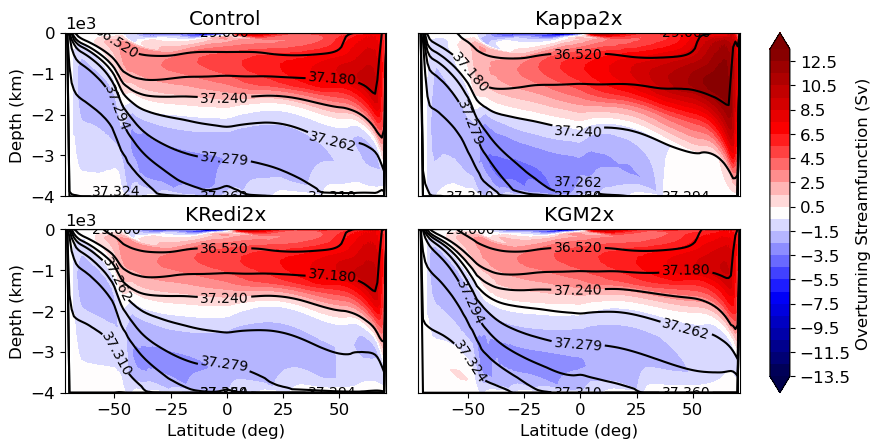

In [22]:
layers1_bounds_streamfunc=[29,
     35.15,
     36.52,
     37.02,
     37.18,
     37.23,
     37.24,
     37.25,
     37.262,
     37.271,
     37.279,
     37.286,
     37.294,
     37.302,
     37.310,
     37.318,
     37.324,
     37.330,
     37.36]
def plot_rhocontours_rhomean(self,layers1_bounds_streamfunc=layers1_bounds_streamfunc):
    
    layer2D,YGgrid=(np.meshgrid(self.ds.layer_1RHO_bounds.load().data, self.ds.YG))
    #print(layer2D.shape)
    #print(self.layer_depth.shape)
    #print(YGgrid.shape)
    #layer2D[self.layer_depth==0]=np.nan
    mylayerdepth=self.layer_depth.copy()
    #layer2D[self.layer_depth==-4000]=np.nan
    #layer2D[self.layer_depth>=-2]=np.nan
    #layer2D[-1,:]=np.nan
    #layer2D[0,:]=np.nan
    #print(layer2D)
    CS=plt.contour(YGgrid,mylayerdepth,layer2D,levels=layers1_bounds_streamfunc[::2],linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
    #plt.colorbar()
myRun.plot_rhocontours_rhomean=plot_rhocontours_rhomean


fig=plt.figure(figsize=myfigsize)
#plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_rhocontours_rhomean()
Runctr.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.xlabel('')
plt.ylabel('Depth (km)')
#plt.gca().set_facecolor("grey")
#plt.gca().set_ylim(-4200,0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_rhocontours_rhomean()
Runkappa2x.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.gca().set_yticks([])
#plt.gca().set_facecolor("grey")
#plt.gca().set_ylim(-4200,0)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_rhocontours_rhomean()
RunRedi2x.draw_streamfunc_depth()
#plt.gca().set_xticks([])
plt.xlabel('Latitude (deg)')
plt.ylabel('Depth (km)')
#plt.gca().set_ylim(-4200,0)
#plt.gca().set_facecolor("grey")
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('KRedi2x')
plt.subplot(2,2,4)

RunGM2x.plot_rhocontours_rhomean()
im=RunGM2x.draw_streamfunc_depth()
plt.gca().set_yticks([])
#plt.gca().set_ylim(-4200,0)
#plt.gca().set_facecolor("grey")
plt.ylabel('')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x')
#plt.colorbar()

plt.subplots_adjust(hspace=0.2, wspace=0.1,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Overturning Streamfunction (Sv)')
cbar.set_ticks(np.arange(-13.5,13.51,2))
fig.savefig(Path(savedir+'Streamfunction_rholayersmean.pdf'), bbox_inches='tight')



In [23]:
def print_max_stream(self):
    phi=(self.PsiY_layers_zonalsum.T.rolling(YG=5).mean()/1e6).load().data
    print(phi.shape)
    print(np.nanmax(phi,axis=0))
    print(np.nanmin(phi))
myRun.print_max_stream=print_max_stream
Runctr.print_max_stream()
Runkappa2x.print_max_stream()
RunGM2x.print_max_stream()
RunRedi2x.print_max_stream()

(435, 144)
[           nan            nan            nan            nan
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.36072088e-04 3.16936053e-03 0.00000000e+00 8.37604570e-03
 1.95632142e-01 4.48587491e-01 6.85654691e-01 9.24348954e-01
 1.15052575e+00 1.36384039e+00 1.55566311e+00 1.73582475e+00
 1.89082621e+00 2.02813323e+00 2.16704990e+00 2.33632231e+00
 2.53375838e+00 2.77707476e+00 2.99368283e+00 3.13606849e+00
 3.19261927e+00 3.19475222e+00 3.05844956e+00 2.98755692e+00
 3.05996653e+00 3.09597410e+00 3.13059926e+00 3.16832306e+00
 3.19879442e+00 3.22784588e+00 3.25612854e+00 3.29348606e+00
 3.33882103e+00 3.39069616e+00 3.44360127e+00 3.49706069e+00
 3.55014319e+00 3.60517790e+00 3.66249270e+00 3.72340002e+00
 3.78603731e+00 3.84987232e+00 3.91314737e+00 3.97815961e+00
 4.04569022e+00 4.11231274e+00 4.17773583e+00 4.24378824e+00
 4.30879472e+00 4.37197391e+00 4.43410247e+00 4.49376482e+00
 4.55083747e+00 4.60765152e+00 4.66283128e+00 4.71605106e+00
 4.76717529e+

/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_20132/1387231246.py:4: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(phi,axis=0))


(435, 144)
[        nan         nan         nan         nan  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.19358047  0.41380036
  0.60724582  0.80030574  0.95083284  1.07382076  1.21242711  1.43596205
  1.68334899  2.02080814  2.33166918  2.51847893  2.60315427  2.6119048
  2.47019734  2.4193192   2.54247599  2.62884627  2.69416155  2.76854113
  2.83469648  2.90559944  2.97965235  3.0602395   3.14468064  3.22519905
  3.31291637  3.40362518  3.49386531  3.58948317  3.6874389   3.78568339
  3.88737276  3.99198347  4.09864795  4.20922446  4.32105842  4.43156219
  4.54509137  4.65829415  4.76903388  4.87750678  4.98548559  5.09075082
  5.1916748   5.29134871  5.38949082  5.48595225  5.5817635   5.67538563
  5.76687355  5.85818484  5.94980478  6.03938129  6.13206149  6.22822121
  6.31976656  6.4082831   6.49820758  6.58857814  6.67965313  7.19691101
  8.6139937   9.58064892 10.14524346 10.38478415 10.40675

/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_20132/1387231246.py:4: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(phi,axis=0))


(435, 144)
[       nan        nan        nan        nan 0.07627659 0.13023102
 0.18072141 0.24651887 0.2618684  0.31114061 0.33871312 0.37926963
 0.44036533 0.66561762 0.89337858 1.12624248 1.33832426 1.53179304
 1.71033772 1.86516931 2.00101193 2.12577826 2.24127356 2.33144541
 2.38743406 2.52663083 2.70988196 2.8369287  2.91216381 2.99732537
 2.98422976 2.95786002 3.01945662 3.0829991  3.11328516 3.14186269
 3.17445548 3.20587262 3.24236153 3.27886447 3.31703751 3.3604578
 3.40781837 3.45148039 3.49874609 3.55116367 3.60316878 3.66006615
 3.71787226 3.78013042 3.84555902 3.91366621 3.9813534  4.04905034
 4.11729134 4.18340045 4.24711331 4.3084468  4.36674224 4.42343276
 4.4784684  4.53154003 4.58382052 4.63672761 4.68783834 4.73826274
 4.78964985 4.8407796  4.89085125 4.93771944 4.98569616 5.0410688
 5.08961413 5.13548781 5.19179225 5.2472307  5.29269849 6.66886064
 7.93059322 8.84442553 9.4219824  9.75142455 9.9082723  9.8982862
 9.73791394 9.46875574 9.09246453 8.65594205 8.2179101

/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_20132/1387231246.py:4: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(phi,axis=0))


(435, 144)
[           nan            nan            nan            nan
 0.00000000e+00 0.00000000e+00 5.32661438e-08 2.20016479e-07
 1.00075425e-03 3.00252487e-03 3.80220415e-03 8.08188525e-03
 1.64411892e-01 4.08089793e-01 6.49407947e-01 8.94143277e-01
 1.12491478e+00 1.34518541e+00 1.55044826e+00 1.73967374e+00
 1.89623976e+00 2.06714090e+00 2.22714384e+00 2.40901464e+00
 2.60953630e+00 2.83756556e+00 3.02125886e+00 3.13932504e+00
 3.16993347e+00 3.15257581e+00 3.03795332e+00 3.08850629e+00
 3.16111769e+00 3.20024116e+00 3.23368785e+00 3.26786653e+00
 3.30500393e+00 3.33818381e+00 3.36757288e+00 3.39976513e+00
 3.45065034e+00 3.50094778e+00 3.55090616e+00 3.60319054e+00
 3.65560277e+00 3.70757540e+00 3.76029081e+00 3.81609398e+00
 3.87707043e+00 3.93897358e+00 4.00009345e+00 4.06407513e+00
 4.12934391e+00 4.19443153e+00 4.25950040e+00 4.32525199e+00
 4.38865783e+00 4.45072083e+00 4.51094864e+00 4.56965048e+00
 4.62728025e+00 4.68029605e+00 4.73301102e+00 4.78273580e+00
 4.83284516e+

/var/folders/95/kqnc1xrn05zcmk1f2dtc1ldc0000gp/T/ipykernel_20132/1387231246.py:4: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(phi,axis=0))


In [24]:
def plot_Agecontours_rhomean(self):
    '''
    plotting rho contours for myRun class
    '''
    age=self.ds.PTRtave01.where(self.ds.maskC).mean('time')
    agez_layers= layers_apply(age.fillna(0) ,(self.rho_nonan-1000), np.array(self.ds.layer_1RHO_bounds.load().data), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.ds.layer_1RHO_bounds.load().data), dsGM2x.drF, dsGM2x.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    age_layers=(agez_layers.sum('XC'))
    layer2D,YGgrid=(np.meshgrid(self.ds.layer_1RHO_bounds.load().data, self.ds.YG))
    print(age_layers.load())
    z_layers_zonalsum=z_layers.sum('XC')
    plt.contourf(YGgrid,self.layer_depth,z_layers_zonalsum.where(z_layers_zonalsum))
    
    #print(self.layer_depth.shape)
    #plt.contour(YGgrid,mylayerdepth,layer2D,levels=layers1_bounds_streamfunc[::2],linewidths=1.5, colors='k')
    #return (self.ds.PTRtave01.where(self.ds.maskC).mean('time')/31104000).mean('XC').plot.contourf(levels=np.arange(0,1210,100),cmap=plt.cm.YlOrRd,add_colorbar=False)
    #print("Age:",(self.ds.PTRtave01/31104000).max().load())
    #plt.clabel(CS, inline=True, fontsize=10)
#myRun.plot_Agecontours_rhomean=plot_Agecontours_rhomean
#RunGM2x.plot_Agecontours_rhomean()




<xarray.DataArray 'PTRtave01' ()>
array(1048.43170824, dtype=float128)


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret =

<xarray.DataArray 'PTRtave01' ()>
array(549.13433734, dtype=float128)


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<xarray.DataArray 'PTRtave01' ()>
array(863.03752246, dtype=float128)


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


<xarray.DataArray 'PTRtave01' ()>
array(1159.25186775, dtype=float128)


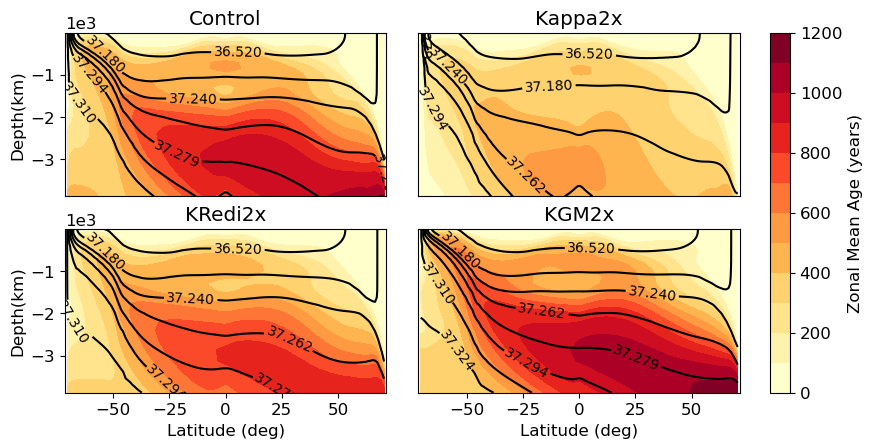

In [25]:
def plot_Agecontours(self):
    '''
    plotting rho contours for myRun class
    '''
    print((self.ds.PTRtave01.where(self.ds.maskC).mean('time')/31104000).mean('XC').max().load())
    return (self.ds.PTRtave01.where(self.ds.maskC).mean('time')/31104000).mean('XC').plot.contourf(levels=np.arange(0,1210,100),cmap=plt.cm.YlOrRd,add_colorbar=False)
    #print("Age:",(self.ds.PTRtave01/31104000).max().load())
    #plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_Agecontours=plot_Agecontours
#Plotting Age (Zonal mean)
fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_Agecontours()
Runctr.plot_rhocontours()
plt.gca().set_xticks([])
plt.xlabel('')
plt.ylabel('Depth(km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_Agecontours()
Runkappa2x.plot_rhocontours()
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x')

plt.subplot(2,2,3)
RunRedi2x.plot_Agecontours()
RunRedi2x.plot_rhocontours()
#plt.gca().set_xticks([])
plt.xlabel('Latitude (deg)')
plt.ylabel('Depth(km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('KRedi2x')
plt.subplot(2,2,4)

im=RunGM2x.plot_Agecontours()
RunGM2x.plot_rhocontours()
plt.gca().set_yticks([])
plt.ylabel('')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x')

#plt.colorbar()

plt.subplots_adjust(hspace=0.2, wspace=0.1,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Zonal Mean Age (years)')
cbar.set_ticks(np.arange(0,1210,200))
fig.savefig(Path(savedir+'ZonalAge.pdf'), bbox_inches='tight')



/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret =

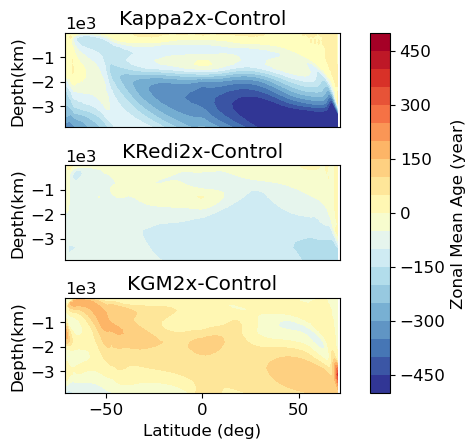

In [26]:
def plot_Agediffcontours(self):
    '''
    plotting rho contours for myRun class
    '''
    return ((self.ds.PTRtave01.where(self.ds.maskC).mean('time')-Runctr.ds.PTRtave01.where(self.ds.maskC).mean('time'))/31104000).mean('XC').plot.contourf(levels=np.arange(-500,510,50),cmap=plt.cm.RdYlBu.reversed(),add_colorbar=False)
    #print("Age:",(self.ds.PTRtave01/31104000).max().load())
    #plt.clabel(CS, inline=True, fontsize=10)
myRun.plot_Agediffcontours=plot_Agediffcontours
#Plotting Age (Zonal mean)
fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
#plt.subplot(2,2,1)
#Runctr.plot_Agediffcontours()
#plt.gca().set_xticks([])
#plt.xlabel('')
#plt.ylabel('Depth(km)')
#plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
#plt.title('Control')
plt.subplot(3,1,1)
Runkappa2x.plot_Agediffcontours()
plt.gca().set_xticks([])
#plt.gca().set_yticks([])
plt.xlabel('')
plt.ylabel('Depth(km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x-Control')

plt.subplot(3,1,2)
RunRedi2x.plot_Agediffcontours()
plt.gca().set_xticks([])
#plt.gca().set_yticks([])
#plt.xlabel('Latitude (deg)')
plt.ylabel('Depth(km)')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
plt.xlabel('')
plt.title('KRedi2x-Control')
plt.subplot(3,1,3)
im=RunGM2x.plot_Agediffcontours()
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.gca().set_yticks([])
plt.ylabel('Depth(km)')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x-Control')
#plt.colorbar()

plt.subplots_adjust(hspace=0.4, wspace=0.5,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.4)
cbar_ax = fig.add_axes([0.43, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Zonal Mean Age (year)')
#cbar.set_ticks(np.arange(0,1210,200))
fig.savefig(Path(savedir+'SI_ZonalDiffAge.pdf'), bbox_inches='tight')


/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


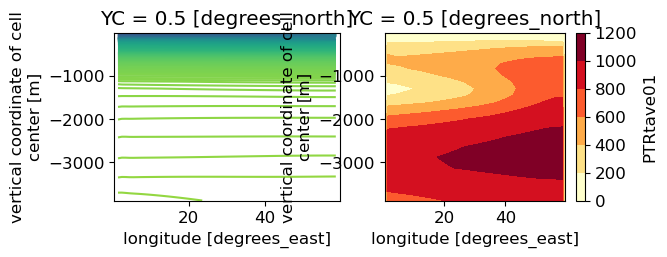

In [27]:
#Zonal Cross Section at equator (exploring the reason of local maximum in zonal mean age plot)
plt.subplot(2,2,1)
(RunGM2x.rho3D.where(RunGM2x.ds.maskC)[:,72,:]-1000).plot.contour(levels=RunGM2x.ds.layer_1RHO_bounds[::])
plt.subplot(2,2,2)
(RunGM2x.ds.PTRtave01/31104000).mean('time')[:,72,:].plot.contourf(cmap=plt.cm.YlOrRd)

In [28]:
RunGM2x.ds.GM_Age_x.mean('time').max().load()
Runkappa2x.ds.GM_Kvz.mean('time').min().load()

<xarray.DataArray 'GM_Kvz' ()>
array(-0.00265167, dtype=float128)

/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/boerzhang/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret =

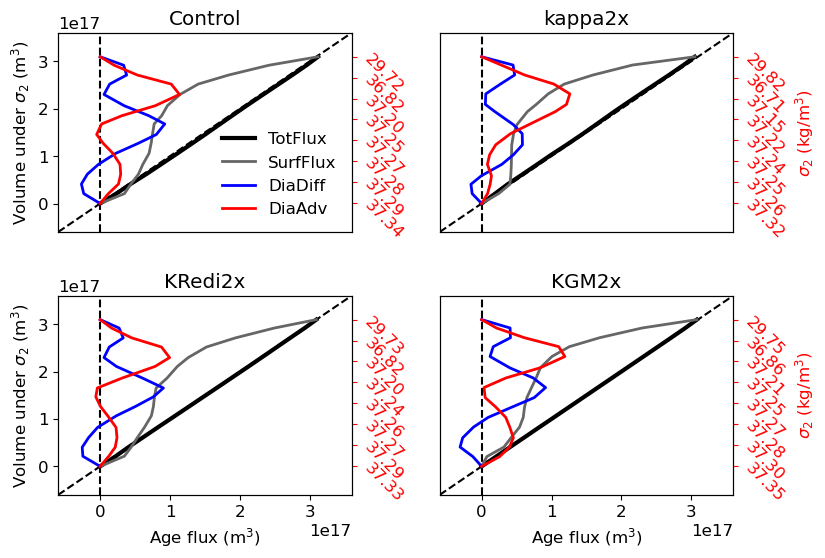

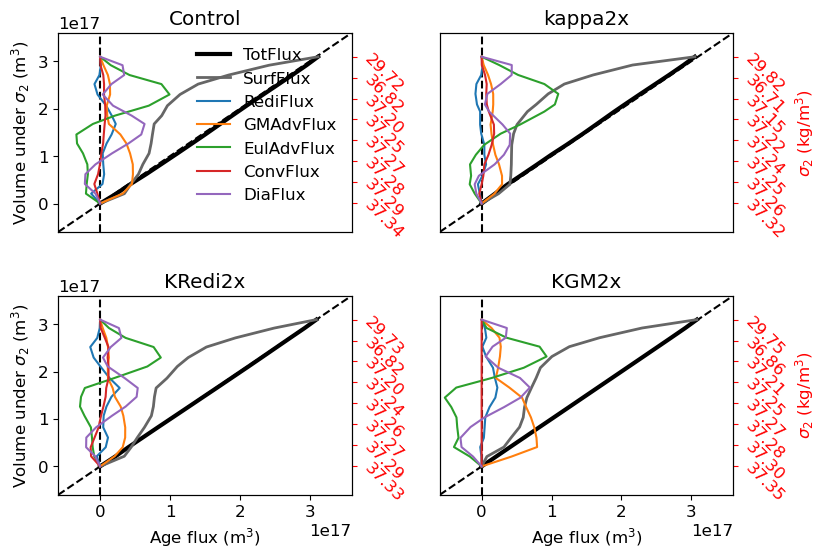

In [29]:
#This cell: calculating diapycnal total age fluxes
#plot diapycnal fluxes

def FluxDivCalc(self,diagnosedGM=False):
    '''
    Calculate age fluxes (resolved advection, GM, Redi, conv, diapycnal diffusion) and their divergence
    '''
    #Tdiftave code is modified to output kdia+GM_Kwz+kconv, credit to: Shantong Sun
    kappa=self.ds.Tdiftave.mean('time') #kappa=kdia+GM_kwz+kconv
    #GM_Kwz
    GM_Kwz=self.ds['GM_Kwz-T'].mean('time')
    #fractions of different fluxes
    frac_dia=self.kdia3d/kappa
    frac_GM_Kwz=GM_Kwz/kappa
    frac_conv=1-frac_dia-frac_GM_Kwz
    #different age fluxes (could potentially be written as a function of dataset)
    fadvx=self.ds.ADVxTr01.mean('time')
    fdiffx=self.ds.DFxETr01.mean('time') #GM-Redi x age flux
    fadvy=self.ds.ADVyTr01.mean('time')
    fdiffy=self.ds.DFyETr01.mean('time') #GM-Redi y age flux
    fadvr=self.ds.ADVrTr01.mean('time')
    fdiffrE=self.ds.DFrETr01.mean('time') #GM-Redi z age flux: contribution of Kwx and Kwy
    fdiffrI=self.ds.DFrITr01.mean('time') #contribution of kdia+GM_Kwz+kconv
    #GM age flux
    #here, the 2 is due to a mistake 
    #There is no longer any 2
    if diagnosedGM:
        fGMx=self.ds.GM_Age_x.mean('time')
        fGMy=self.ds.GM_Age_y.mean('time')
        fGMr=self.ds.GM_Age_r.mean('time') #only contribution of Kwx and Kwy, but this is already total GMr flux since Kwz_GM=0
        age=self.ds.PTRtave01.where(self.ds.maskC).mean('time')
        ageU=self.grid.interp(age,'X')
        ageV=self.grid.interp(age,'Y',boundary='fill')
        ager=self.grid.interp(age,'Z',boundary='fill')

        #self.ugmFromTensor=ugmFromTensor
        #    self.vgmFromTensor=vgmFromTensor
        #   self.wgmFromTensor=wgmFromTensor
        fGMx=self.fVolgmx*ageU.fillna(0)
        fGMy=self.fVolgmy*ageV.fillna(0)
        fGMr=self.fVolgmr*ager.fillna(0)
    else:
        age=self.ds.PTRtave01.where(self.ds.maskC).mean('time')
        ageU=self.grid.interp(age,'X')
        ageV=self.grid.interp(age,'Y',boundary='fill')
        ager=self.grid.interp(age,'Z',boundary='fill')

        #self.ugmFromTensor=ugmFromTensor
        #    self.vgmFromTensor=vgmFromTensor
        #   self.wgmFromTensor=wgmFromTensor
        fGMx=self.fVolgmx*ageU.fillna(0)
        fGMy=self.fVolgmy*ageV.fillna(0)
        fGMr=self.fVolgmr*ager.fillna(0)
    #print(fGMx.load(),fGMy.load(),fGMr.load())
    #fGMy=fdiffy
    #fGMr=fdiffrE
    #Redi age flux
    fRedix=fdiffx-fGMx
    fRediy=fdiffy-fGMy
    fRedirE=fdiffrE-fGMr
    #separating implicit diffusion: kdia+GM_Kwz+kconv
    fRedirI=fdiffrI*frac_GM_Kwz #only Redi diffusion has contribution in GM-Redi tensor GM_Kwz (no GM contribution)
    #fRedirI=0
    fdia=fdiffrI*frac_dia
    fconv=fdiffrI*frac_conv
    #Redi r term
    fRedir=fRedirE+fRedirI
    #total age flux
    ftotx=fadvx+fdiffx
    ftoty=fadvy+fdiffy
    ftotr=fadvr+fdiffrE+fdiffrI
    self.fageGMx=fGMx
    self.fageGMy=fGMy
    self.fageGMr=fGMr
    self.fageEux=fadvx
    self.fageEuy=fadvy
    self.fageEur=fadvr
    self.fageadvx=fGMx+fadvx
    self.fageadvy=fGMy+fadvy
    self.fageadvr=fGMr+fadvr
    fsurf=self.ds.ForcTr01.mean('time')*self.ds.rA*self.ds.drF
    fsurf[1:,:,:]=0
    Vol=self.ds.rA*self.ds.drF
    '''
    for varname in ['ftot','fRedi','fGM']:
        exec(f"self.{varname}x={varname}x")
        exec(f"self.{varname}y={varname}y")
        exec(f"self.{varname}r={varname}r")
    '''
    
    def divflux(fx,fy,fr,grid=self.grid):
        '''
        return divergence of a certain flux F(fx,fy,fz)
        '''
        divfx=grid.diff(fx,axis='X',boundary='periodic')
        divfy=grid.diff(fy,axis='Y',boundary='periodic')
        divfr=-grid.diff(fr,axis='Z',boundary='periodic')
        return divfx,divfy,divfr,divfx+divfy+divfr

    #div tot flux
    divtotx,divtoty,divtotr,divtot=divflux(ftotx,ftoty,ftotr)
    #div ADV flux: be careful on boundary condition, especially for diffusive fluxes
    divadvx,divadvy,divadvr,divadv=divflux(fadvx,fadvy,fadvr)
    #div GM flux
    divGMx,divGMy,divGMr,divGM=divflux(fGMx,fGMy,fGMr)
    #div Redi flux
    divRedix,divRediy,divRedir,divRedi=divflux(fRedix,fRediy,fRedir)
    #div dia flux
  
    divdia=-self.grid.diff(fdia,axis='Z',boundary='periodic')
    #div conv flux
    divconv=-self.grid.diff(fconv,axis='Z',boundary='periodic')
    #Volume
    Voldata=Vol.transpose('Z','YC','XC').load().data
    
    def rhoInt(Xdata,rhoindex=self.rhoindex,Nlayersbin=self.Nlayersbin):
        ''''''
        'Integrate Xdata at density layers'
        ''''''
        dX_rho=np.zeros([Nlayersbin,1])
        [Nz,Ny,Nx]=rhoindex.shape
        for idx in range(Nx):
            for idy in range(Ny):
                for idz in range(Nz): 
                    rhoindextemp=rhoindex[idz,idy,idx]
                    if(~np.isnan(rhoindextemp)):  
                        dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
        return np.cumsum(dX_rho[::-1])[::-1]

    
    self.sumVol_rho=rhoInt(Voldata)
    #sumdivtoty_rho=rhoInt(divtoty.load().data)
    #sumdivtotx_rho=rhoInt(divtotx.load().data)
    #sumdivtotr_rho=rhoInt(divtotr.load().data)
    #sumdivtot_rho=sumdivtotx_rho+sumdivtoty_rho+sumdivtotr_rho
    self.sumdivtot_rho=rhoInt(divtot.load().data)
    #sumdivtotydiag_rho=rhoInt(divtoty_diag.load().data)
    self.sumdivadv_rho=rhoInt(divadv.load().data)
    self.sumdivGM_rho=rhoInt(divGM.load().data)
    #print(self.sumdivGM_rho)
    self.sumdivRedi_rho=rhoInt(divRedi.load().data)
    self.sumdivconv_rho=rhoInt(divconv.load().data)
    self.sumdivdia_rho=rhoInt(divdia.load().data)
    self.sumfsurf_rho=rhoInt(fsurf.load().data)
    
myRun.FluxDivCalc=FluxDivCalc




def plot_diapycnal_flux_on_rhoid(self):
    '''
    plotting volume/age fluxes at different layer ids 
    '''
    #plt.figure()
    plt.plot(self.sumVol_rho,label='totVolume')
    plt.plot(self.sumdivtot_rho,label='totflux')
    plt.plot(self.sumdivadv_rho,label='advflux')
    plt.plot(self.sumdivGM_rho,label='GMflux')
    plt.plot(self.sumdivadv_rho+self.sumdivGM_rho,label='adv+GMflux')
    plt.plot(self.sumdivRedi_rho,label='Rediflux')
    plt.plot(self.sumdivconv_rho,label='conv flux')
    plt.plot(self.sumdivdia_rho,label='dia flux')
    plt.plot(self.sumfsurf_rho,label='surf flux')
    plt.legend()
myRun.plot_diapycnal_flux_on_rhoid=plot_diapycnal_flux_on_rhoid
#RunGM2x.plot_diapycnal_flux_on_rhoid()

def plot_diapycnal_flux_on_Volume_backup(self,detailed=True,xaxison=True,yaxison=True,yupperlabel=True,legendon=False):
    #plt.figure()
    lower_bound=-0.6e17
    plt.plot([lower_bound,3.6e17],[lower_bound,3.6e17],'k--')
    plt.plot([lower_bound,3.6e17],[0,0],'k--')
    plt.plot(self.sumVol_rho,self.sumdivtot_rho-self.sumfsurf_rho,'k-',linewidth=3,label='TotFlux')
    plt.plot(self.sumVol_rho,-self.sumfsurf_rho,'-',c='0.4',label='SurFlux',linewidth=2)
    if not detailed:
        plt.plot(self.sumVol_rho,self.sumdivRedi_rho+self.sumdivconv_rho+self.sumdivdia_rho,'b-',label='DiaDiff',linewidth=2)
        plt.plot(self.sumVol_rho,self.sumdivGM_rho+self.sumdivadv_rho,'r-',label='DiaAdv',linewidth=2)
    if detailed:    
        plt.plot(self.sumVol_rho,self.sumdivRedi_rho,'.-',label='Rediflux')
        plt.plot(self.sumVol_rho,self.sumdivGM_rho,'.-',label='GMflux')
        plt.plot(self.sumVol_rho,self.sumdivadv_rho,'.-',label='advflux')
        plt.plot(self.sumVol_rho,self.sumdivGM_rho+self.sumdivadv_rho,'.-',label='adv+GM flux')
        plt.plot(self.sumVol_rho,self.sumdivconv_rho,'.-',label='conv flux')
        plt.plot(self.sumVol_rho,self.sumdivdia_rho,'.-',label='dia flux')
        
    ax1=plt.gca()
    ax2=ax1.twiny()
    ax1.autoscale(enable=True, axis='both', tight=True)
    if xaxison:
        ax1.set_xlabel('Volume under $\sigma_2$ surface (m$^3$)')
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Age flux (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    ax2.set_xlim(ax1.get_xlim())
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)
    
                
    ax2.set_xticks(x2tick_volume)
    ax2.set_xticklabels([f"{x:.2f}" for x in x2tick_density],rotation=25)
    if(yupperlabel):
        ax2.set_xlabel("$\sigma_2$ (kg/m$^3$)")
    
    return ax1,ax2

def plot_diapycnal_flux_on_Volume(self,detailed=True,xaxison=True,yaxison=True,xrightlabel=True,legendon=False):
    #plt.figure()
    lower_bound=-0.6e17
    plt.plot([lower_bound,3.6e17],[lower_bound,3.6e17],'k--')
    plt.plot([0,0],[lower_bound,3.6e17],'k--')
    plt.plot(self.sumdivtot_rho-self.sumfsurf_rho,self.sumVol_rho,'k-',linewidth=3,label='TotFlux')
    plt.plot(-self.sumfsurf_rho,self.sumVol_rho,'-',c='0.4',label='SurfFlux',linewidth=2)
    if not detailed:
        plt.plot(self.sumdivRedi_rho+self.sumdivconv_rho+self.sumdivdia_rho,self.sumVol_rho,'b-',label='DiaDiff',linewidth=2)
        plt.plot(self.sumdivGM_rho+self.sumdivadv_rho,self.sumVol_rho,'r-',label='DiaAdv',linewidth=2)
    if detailed:    
        plt.plot(self.sumdivRedi_rho,self.sumVol_rho,'-',label='RediFlux')
        plt.plot(self.sumdivGM_rho,self.sumVol_rho,'-',label='GMAdvFlux')
        plt.plot(self.sumdivadv_rho,self.sumVol_rho,'-',label='EulAdvFlux')
        #plt.plot(self.sumdivGM_rho+self.sumdivadv_rho,self.sumVol_rho,'.-',label='adv+GM flux')
        plt.plot(self.sumdivconv_rho,self.sumVol_rho,'-',label='ConvFlux')
        plt.plot(self.sumdivdia_rho,self.sumVol_rho,'-',label='DiaFlux')
        
    ax1=plt.gca()
    ax2=ax1.twinx()
    ax1.autoscale(enable=True, axis='both', tight=True)
    if xaxison:
        ax1.set_xlabel('Age flux (m$^3$)')
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    self.x2tick_density=x2tick_density
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    
    return ax1,ax2

myRun.plot_diapycnal_flux_on_Volume=plot_diapycnal_flux_on_Volume
RunGM2x.FluxDivCalc(diagnosedGM=True)
Runctr.FluxDivCalc()
RunRedi2x.FluxDivCalc(diagnosedGM=True)
Runkappa2x.FluxDivCalc()

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
ax1,ax2=Runctr.plot_diapycnal_flux_on_Volume(detailed=False,xaxison=False,legendon=True,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_diapycnal_flux_on_Volume(detailed=False,xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_diapycnal_flux_on_Volume(detailed=False,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.plot_diapycnal_flux_on_Volume(detailed=False,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'AgeFluxBudget.pdf'), bbox_inches='tight')

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
ax1,ax2=Runctr.plot_diapycnal_flux_on_Volume(detailed=True,xaxison=False,legendon=True,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_diapycnal_flux_on_Volume(detailed=True,xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_diapycnal_flux_on_Volume(detailed=True,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.plot_diapycnal_flux_on_Volume(detailed=True,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'AgeFluxBudget_detail.pdf'), bbox_inches='tight')



In [30]:
#This cell: calculating diapycnal total age fluxes, but the rho is purturbed
#plot diapycnal fluxes

def FluxDivCalc_rhoperturb(self,diagnosedGM=False):
    '''
    Calculate age fluxes (resolved advection, GM, Redi, conv, diapycnal diffusion) and their divergence
    '''
    #Tdiftave code is modified to output kdia+GM_Kwz+kconv, credit to: Shantong Sun
    kappa=self.ds.Tdiftave.mean('time') #kappa=kdia+GM_kwz+kconv
    #GM_Kwz
    GM_Kwz=self.ds['GM_Kwz-T'].mean('time')
    #fractions of different fluxes
    frac_dia=self.kdia3d/kappa
    frac_GM_Kwz=GM_Kwz/kappa
    frac_conv=1-frac_dia-frac_GM_Kwz
    #different age fluxes (could potentially be written as a function of dataset)
    fadvx=self.ds.ADVxTr01.mean('time')
    fdiffx=self.ds.DFxETr01.mean('time') #GM-Redi x age flux
    fadvy=self.ds.ADVyTr01.mean('time')
    fdiffy=self.ds.DFyETr01.mean('time') #GM-Redi y age flux
    fadvr=self.ds.ADVrTr01.mean('time')
    fdiffrE=self.ds.DFrETr01.mean('time') #GM-Redi z age flux: contribution of Kwx and Kwy
    fdiffrI=self.ds.DFrITr01.mean('time') #contribution of kdia+GM_Kwz+kconv
    #GM age flux
    #here, the 2 is due to a mistake 
    #There is no longer any 2
    if diagnosedGM:
        fGMx=self.ds.GM_Age_x.mean('time')
        fGMy=self.ds.GM_Age_y.mean('time')
        fGMr=self.ds.GM_Age_r.mean('time') #only contribution of Kwx and Kwy, but this is already total GMr flux since Kwz_GM=0
        age=self.ds.PTRtave01.where(self.ds.maskC).mean('time')
        ageU=self.grid.interp(age,'X')
        ageV=self.grid.interp(age,'Y',boundary='fill')
        ager=self.grid.interp(age,'Z',boundary='fill')

        #self.ugmFromTensor=ugmFromTensor
        #    self.vgmFromTensor=vgmFromTensor
        #   self.wgmFromTensor=wgmFromTensor
        fGMx=self.fVolgmx*ageU.fillna(0)
        fGMy=self.fVolgmy*ageV.fillna(0)
        fGMr=self.fVolgmr*ager.fillna(0)
    else:
        age=self.ds.PTRtave01.where(self.ds.maskC).mean('time')
        ageU=self.grid.interp(age,'X')
        ageV=self.grid.interp(age,'Y',boundary='fill')
        ager=self.grid.interp(age,'Z',boundary='fill')

        #self.ugmFromTensor=ugmFromTensor
        #    self.vgmFromTensor=vgmFromTensor
        #   self.wgmFromTensor=wgmFromTensor
        fGMx=self.fVolgmx*ageU.fillna(0)
        fGMy=self.fVolgmy*ageV.fillna(0)
        fGMr=self.fVolgmr*ager.fillna(0)
    #print(fGMx.load(),fGMy.load(),fGMr.load())
    #fGMy=fdiffy
    #fGMr=fdiffrE
    #Redi age flux
    fRedix=fdiffx-fGMx
    fRediy=fdiffy-fGMy
    fRedirE=fdiffrE-fGMr
    #separating implicit diffusion: kdia+GM_Kwz+kconv
    fRedirI=fdiffrI*frac_GM_Kwz #only Redi diffusion has contribution in GM-Redi tensor GM_Kwz (no GM contribution)
    #fRedirI=0
    fdia=fdiffrI*frac_dia
    fconv=fdiffrI*frac_conv
    #Redi r term
    fRedir=fRedirE+fRedirI
    #total age flux
    ftotx=fadvx+fdiffx
    ftoty=fadvy+fdiffy
    ftotr=fadvr+fdiffrE+fdiffrI
    self.fageGMx=fGMx
    self.fageGMy=fGMy
    self.fageGMr=fGMr
    self.fageEux=fadvx
    self.fageEuy=fadvy
    self.fageEur=fadvr
    self.fageadvx=fGMx+fadvx
    self.fageadvy=fGMy+fadvy
    self.fageadvr=fGMr+fadvr
    fsurf=self.ds.ForcTr01.mean('time')*self.ds.rA*self.ds.drF
    fsurf[1:,:,:]=0
    Vol=self.ds.rA*self.ds.drF
    '''
    for varname in ['ftot','fRedi','fGM']:
        exec(f"self.{varname}x={varname}x")
        exec(f"self.{varname}y={varname}y")
        exec(f"self.{varname}r={varname}r")
    '''
    
    def divflux(fx,fy,fr,grid=self.grid):
        '''
        return divergence of a certain flux F(fx,fy,fz)
        '''
        divfx=grid.diff(fx,axis='X',boundary='periodic')
        divfy=grid.diff(fy,axis='Y',boundary='periodic')
        divfr=-grid.diff(fr,axis='Z',boundary='periodic')
        return divfx,divfy,divfr,divfx+divfy+divfr

    #div tot flux
    divtotx,divtoty,divtotr,divtot=divflux(ftotx,ftoty,ftotr)
    #div ADV flux: be careful on boundary condition, especially for diffusive fluxes
    divadvx,divadvy,divadvr,divadv=divflux(fadvx,fadvy,fadvr)
    #div GM flux
    divGMx,divGMy,divGMr,divGM=divflux(fGMx,fGMy,fGMr)
    #div Redi flux
    divRedix,divRediy,divRedir,divRedi=divflux(fRedix,fRediy,fRedir)
    #div dia flux
  
    divdia=-self.grid.diff(fdia,axis='Z',boundary='periodic')
    #div conv flux
    divconv=-self.grid.diff(fconv,axis='Z',boundary='periodic')
    #Volume
    Voldata=Vol.transpose('Z','YC','XC').load().data
    
    def rhoInt(Xdata,rhoindex=self.rhoindex,Nlayersbin=self.Nlayersbin):
        ''''''
        'Integrate Xdata at density layers'
        ''''''
        dX_rho=np.zeros([Nlayersbin,1])
        [Nz,Ny,Nx]=rhoindex.shape
        for idx in range(Nx):
            for idy in range(Ny):
                for idz in range(Nz): 
                    rhoindextemp=rhoindex[idz,idy,idx]
                    if(~np.isnan(rhoindextemp)):  
                        dX_rho[int(rhoindextemp)]+=Xdata[idz,idy,idx]
        return np.cumsum(dX_rho[::-1])[::-1]

    
    self.sumVol_rho=rhoInt(Voldata)
    #sumdivtoty_rho=rhoInt(divtoty.load().data)
    #sumdivtotx_rho=rhoInt(divtotx.load().data)
    #sumdivtotr_rho=rhoInt(divtotr.load().data)
    #sumdivtot_rho=sumdivtotx_rho+sumdivtoty_rho+sumdivtotr_rho
    self.sumdivtot_rho=rhoInt(divtot.load().data)
    #sumdivtotydiag_rho=rhoInt(divtoty_diag.load().data)
    self.sumdivadv_rho=rhoInt(divadv.load().data)
    self.sumdivGM_rho=rhoInt(divGM.load().data)
    #print(self.sumdivGM_rho)
    self.sumdivRedi_rho=rhoInt(divRedi.load().data)
    self.sumdivconv_rho=rhoInt(divconv.load().data)
    self.sumdivdia_rho=rhoInt(divdia.load().data)
    self.sumfsurf_rho=rhoInt(fsurf.load().data)
    
myRun.FluxDivCalc=FluxDivCalc



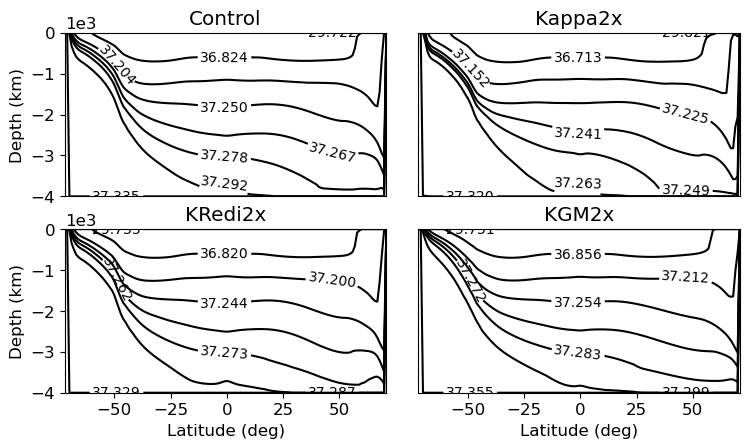

In [31]:
###This block is plotting the SI for the boundary of the
layers1_bounds_streamfunc=[29,
     35.15,
     36.52,
     37.02,
     37.18,
     37.23,
     37.24,
     37.25,
     37.262,
     37.271,
     37.279,
     37.286,
     37.294,
     37.302,
     37.310,
     37.318,
     37.324,
     37.330,
     37.36]
def plot_rhocontours_rhomean(self,layers1_bounds_streamfunc=layers1_bounds_streamfunc):
    
    layer2D,YGgrid=(np.meshgrid(self.ds.layer_1RHO_bounds.load().data, self.ds.YG))
    #print(layer2D.shape)
    #print(self.layer_depth.shape)
    #print(YGgrid.shape)
    #layer2D[self.layer_depth==0]=np.nan
    mylayerdepth=self.layer_depth.copy()
    #layer2D[self.layer_depth==-4000]=np.nan
    #layer2D[self.layer_depth>=-2]=np.nan
    #layer2D[-1,:]=np.nan
    #layer2D[0,:]=np.nan
    #print(layer2D)
    CS=plt.contour(YGgrid,mylayerdepth,layer2D,levels=self.x2tick_density[::-1],linewidths=1.5, colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
    #plt.colorbar()
myRun.plot_rhocontours_rhomean=plot_rhocontours_rhomean


fig=plt.figure(figsize=myfigsize)
#plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_rhocontours_rhomean()
#Runctr.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.xlabel('')
plt.ylabel('Depth (km)')
#plt.gca().set_facecolor("grey")
#plt.gca().set_ylim(-4200,0)
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_rhocontours_rhomean()
#Runkappa2x.draw_streamfunc_depth()
plt.gca().set_xticks([])
plt.gca().set_yticks([])
#plt.gca().set_facecolor("grey")
#plt.gca().set_ylim(-4200,0)
plt.xlabel('')
plt.ylabel('')
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('Kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_rhocontours_rhomean()
#RunRedi2x.draw_streamfunc_depth()
#plt.gca().set_xticks([])
plt.xlabel('Latitude (deg)')
plt.ylabel('Depth (km)')
#plt.gca().set_ylim(-4200,0)
#plt.gca().set_facecolor("grey")
plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))
#plt.ylabel('')
plt.title('KRedi2x')
plt.subplot(2,2,4)

RunGM2x.plot_rhocontours_rhomean()
#im=RunGM2x.draw_streamfunc_depth()
plt.gca().set_yticks([])
#plt.gca().set_ylim(-4200,0)
#plt.gca().set_facecolor("grey")
plt.ylabel('')
plt.xlabel('Latitude (deg)')
plt.title('KGM2x')
#plt.colorbar()

plt.subplots_adjust(hspace=0.2, wspace=0.1,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.83, 0.2, 0.02, 0.6])
#cbar=plt.colorbar(im,cax=cbar_ax,label='Overturning Streamfunction (Sv)')
#cbar.set_ticks(np.arange(-13.5,13.51,2))
fig.savefig(Path(savedir+'SI_density_ticks.pdf'), bbox_inches='tight')



In [32]:
#Do Scaling Analysis for lower cell
dz_layers_atV= layers_apply(self.ds.hFacS,(self.rhoatV_nonan-1000), np.array(layers1_bounds_streamfunc), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
        

NameError: name 'self' is not defined

In [ ]:
Runctr.ds.hFacS[:,10,0].load()
#Runctr.Vol[0,0,:].load()
Voldata=Runctr.Vol.transpose('Z','YC','XC').load().data
Voldata.shape

In [ ]:
## interpolating flux to diapycnal surfaces(grid wise)
#This part will be needed when calculating diapycnal diffusivity??
#Not needed when calculating streamfunction

#rhoindex
def diaFluxOnRho(self,fx,fy,fz,rhoidcur):
    '''
    Interpolating flux (fx,fy,fz) onto density layer rhoidcur(which is a int scaler)
    fx,fy,fz:[Nz,Ny,Nx] Matrix
    '''
    #print(rhoidcur)
    [nz,ny,nx]=self.rhoindex.shape
    #print(self.rhoindex.shape)
    MSK_rhot=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindext<rhoidcur)
    MSK_rhow=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexw<rhoidcur)
    MSK_rhoe=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexe<rhoidcur)
    MSK_rhos=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexs<rhoidcur)
    MSK_rhon=np.logical_and(self.rhoindex>=rhoidcur,self.rhoindexn<rhoidcur)
    #print(fx.shape)
    fxw=fx
    fxe=fx[:,:,np.r_[1:nx,0]]
    fys=fy
    fyn=fy[:,np.r_[1:ny,ny-1],:]
    fluxgrid=(-fxw)*(MSK_rhow)+fxe*(MSK_rhoe)+fyn*(MSK_rhon)+(-fys)*(MSK_rhos)+fz*MSK_rhot
    diafluxrho=np.sum(fluxgrid,axis=0)
    return diafluxrho
myRun.diaFluxOnRho=diaFluxOnRho


##Some Test
#diafluxrho=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=0)
#diafluxrho3D=np.zeros([Nlayersbin-1,ny,nx])
#for layerid in range(Nlayersbin-1):
#    diafluxrho3D[layerid,:,:]=diaFluxOnRho(fx=ftotx.load().data,fy=ftoty.load().data,fz=ftotr.load().data,rhoindex0=rhoindex0,rhoidcur=layerid)
#
def diaFluxOnRho_3D(self,fx,fy,fz,rhoidvec):
    tempfunc=np.vectorize(
    self.diaFluxOnRho,
    excluded=['fx','fy','fz'],
    signature='()->(m,n)'
    )
    #print(tempfunc)
    return tempfunc(fx=fx,fy=fy,fz=fz,rhoidcur=rhoidvec)

    
myRun.diaFluxOnRho_3D=diaFluxOnRho_3D
#RunGM2x.diaFluxOnRho_3D()


In [ ]:
def invert_kdia(self):
    '''
    Inverting diapycnal diffusivity
    '''
    tot_dia_flux=self.sumdivconv_rho+self.sumdivdia_rho
    tot_dia_flux_plusRedi=self.sumdivconv_rho+self.sumdivdia_rho+self.sumdivRedi_rho
    tot_dia_flux_diaonly=self.sumdivdia_rho
    agetmean=self.ds.PTRtave01.mean('time').where(self.ds.maskC)
    agezgrad=self.grid.diff(agetmean,'Z',boundary='fill')/self.grid.diff(self.ds.Z,'Z',boundary='fill')
    agezgrad_rA=agezgrad*self.ds.rA
    agezgrad_rA=agezgrad_rA.fillna(0)
    fdia_my=(-self.kdia3d*agezgrad.fillna(0)*self.ds.rA).transpose('Zl','YC','XC')
    #print(fdia_my.load())
    diadiffflux3D=self.diaFluxOnRho_3D(fx=0*fdia_my.load().data,fy=0*fdia_my.load().data,fz=fdia_my.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #self.fdia_my=fdia_my
    diadiffflux_hsum=np.sum(np.sum(diadiffflux3D,axis=2),axis=1)
    diasum_agezgrad_rA_3D=self.diaFluxOnRho_3D(fx=0*agezgrad_rA.load().data,fy=0*agezgrad_rA.load().data,fz=agezgrad_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    diasum_agezgrad_rA_3D_hsum=np.sum(np.sum(diasum_agezgrad_rA_3D,axis=2),axis=1)
    #kdia_infer: inferred diapycnal age diffusion on isopycnal surfaces
    self.diasum_agezgrad_rA_3D_hsum=diasum_agezgrad_rA_3D_hsum
    self.tot_dia_flux_diaonly=tot_dia_flux_diaonly
    self.tot_dia_flux_plusRedi=tot_dia_flux_plusRedi
    self.kdia_infer_diaonly=-tot_dia_flux_diaonly/(diasum_agezgrad_rA_3D_hsum)
    self.kdia_infer=-tot_dia_flux/(diasum_agezgrad_rA_3D_hsum)
    self.kdia_infer_plusRedi=-tot_dia_flux_plusRedi/(diasum_agezgrad_rA_3D_hsum)
    #print("kdia_infer:",kdia_infer)
    kdia3d_rA=self.kdia3d*self.ds.rA
    rA3d=0*self.kdia3d+self.ds.rA
    kdia_rA_diainterp=self.diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    rA_diainterp=self.diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #kdia_ref: reference kdia averaged onto density surface
    self.kdia_ref=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/np.sum(np.sum(rA_diainterp,axis=2),axis=1)
    #print("kdia_ref:",kdia_ref)
    #print("diadiffflux_hsum:",diadiffflux_hsum)
    #print("tot_dia_flux:",tot_dia_flux)
   
    
myRun.invert_kdia=invert_kdia


def plot_invert_kdia(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True):
    '''
    Plot inverted diapycnal diffusivity
    '''
    #plt.plot(self.kdia_infer,self.sumVol_rho,'bo',label=r'$\frac{F_{dia}+F_{conv}}{\Gamma_z}$')
    plt.plot(self.kdia_infer_diaonly,self.sumVol_rho,'ro',label=r'$\kappa_{\rm dia, modelled}$')
    plt.plot(self.kdia_infer_plusRedi,self.sumVol_rho,'bo',label=r'$\kappa_{\rm dia, inv}$')
    
    plt.plot(self.kdia_ref,self.sumVol_rho,'k',linewidth=2,label='$\kappa_{ref}$')
    plt.ticklabel_format(axis='x', style='sci',scilimits=(0,0))
    #plt.xlabel(r"Diapycnal Diffusivity (m$^2$/s)")
    #plt.xscale("log")
    ax1=plt.gca()
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Diffusivity (m$^2$/s)")
    else:
        pass
        #ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=True)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2
    
myRun.plot_invert_kdia=plot_invert_kdia


#RunGM2x.plot_invert_kdia()

Runctr.invert_kdia()
Runkappa2x.invert_kdia()
RunRedi2x.invert_kdia()
RunGM2x.invert_kdia()

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
ax1,ax2=Runctr.plot_invert_kdia(xaxison=False,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_invert_kdia(xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_invert_kdia(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.plot_invert_kdia(yaxison=False,legendon=True)
#plt.gca().set_yticks([])
plt.title('KGM2x')
fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'Invert_Diffusivity_fullrange.pdf'), bbox_inches='tight')




In [ ]:
fig=plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplot(2,2,1)

ax1,ax2=Runctr.plot_invert_kdia(xaxison=False,xrightlabel=False)
plt.title('Control')
ax1.set_xlim(0,1.5e-4)
plt.subplot(2,2,2)
ax1,ax2=Runkappa2x.plot_invert_kdia(xaxison=False,yaxison=False)

ax1.set_yticks([])
plt.title('kappa2x')
ax1.set_xlim(0,1.5e-4)
plt.subplot(2,2,3)
ax1,ax2=RunRedi2x.plot_invert_kdia(xrightlabel=False)
plt.title('KRedi2x')
ax1.set_xlim(0,1.5e-4)
plt.subplot(2,2,4)
ax1,ax2=RunGM2x.plot_invert_kdia(yaxison=False,legendon=True)
#plt.gca().set_yticks([])
plt.title('KGM2x')
ax1.set_xlim(0,1.5e-4)
fig.subplots_adjust(hspace=0.25, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'Invert_Diffusivity.pdf'), bbox_inches='tight')

In [ ]:
def isopycnal_mapping_age(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiY_layers_opt_zonalsum=(dPsiY_layers_opt).sum('XC')
    PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    self.PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    print("psiy1:",self.PsiY_layers_opt_zonalsum)
    ########################################
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    ###
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))    
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    self.PsiY_layers_opt_zonalsum=self.grid.cumsum(fvoldia.sum('XC'),'Y')
    print("psiy2:",self.PsiY_layers_opt_zonalsum)
    self.fvoldia=fvoldia
    self.fvoldia0=fvoldia0
    
    ##################################################
    #interpolating age by accumulating the value at the boundary between two density layers in the original coordinate
    age=self.ds.PTRtave01
    age=age.where(self.ds.maskC).mean('time')
    age_at_z=self.grid.interp(age,'Z')
    age_at_z=age_at_z.fillna(0)
    age_at_z_rA=age_at_z.fillna(0)*self.ds.rA
    
    rA3d=0*age_at_z_rA+self.ds.rA
    age_at_z_rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*age_at_z_rA.load().data,fy=0*age_at_z_rA.load().data,fz=age_at_z_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #print(age_at_z_rA_layer_boundinterp)
    #print(rA_layer_boundinterp)
    age_layer_boundinterp=age_at_z_rA_layer_boundinterp/rA_layer_boundinterp
    
    age_at_z_rA_layer_boundinterp=age_at_z_rA_layer_boundinterp.transpose(1,2,0)
    age_layer_boundinterp=age_layer_boundinterp.transpose(1,2,0)
    rA_layer_boundinterp=rA_layer_boundinterp.transpose(1,2,0)
    #change numpy array to xarray form
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    age_at_z_rA_layer_boundinterp_xr=0*z_layers+age_at_z_rA_layer_boundinterp
    rA_layer_boundinterp_xr=0*z_layers+rA_layer_boundinterp
    age_layer_boundinterp_xr=0*z_layers+age_layer_boundinterp
    #age_layer_boundinterp_xr_zonalmean=age_at_z_rA_layer_boundinterp_xr.sum('XC')/rA_layer_boundinterp_xr.sum('XC')
    age_layer_boundinterp_xr_zonalmean=(age_layer_boundinterp_xr*self.ds.rA).where(rA_layer_boundinterp_xr).sum('XC')/(self.ds.rA).where(rA_layer_boundinterp_xr).sum('XC')
    #
    self.age_layer_boundinterp_xr=age_layer_boundinterp_xr
    self.age_layer_boundinterp_xr_zonalmean=age_layer_boundinterp_xr_zonalmean
    self.rA_layer_boundinterp_xr=rA_layer_boundinterp_xr
    self.age_at_z_rA_layer_boundinterp_xr=age_at_z_rA_layer_boundinterp_xr
    
    ############################
    #interpolating age with xlayers package
    
    agez_layers= layers_apply(age.fillna(0) ,(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    #age_layers=(agez_layers/z_layers).load() 
    #interpolating age at the center of density layer to the boundary of density layers
    agez_layers_np=agez_layers.load().data
    z_layers_np=z_layers.load().data
    #interpolating to boundary of two layers
    agez_layers_np_bounds=0*agez_layers_np
    z_layers_np_bounds=0*z_layers_np
    agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
    agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
    #deal with boundary
    z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
    z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
    #change numpy array to xarray form
    agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
    z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
    #saving age calculation
    
    self.agez_layers_np_bounds_xr=agez_layers_np_bounds_xr
    self.z_layers_np_bounds_xr=z_layers_np_bounds_xr
    age_layer_xr_np_bounds=self.agez_layers_np_bounds_xr/self.z_layers_np_bounds_xr
    
    age_layer_xr_np_bounds=age_layer_xr_np_bounds.where(self.fvoldia)
    self.age_layer_xr_np_bounds=age_layer_xr_np_bounds
    #it is implicitly assumed that the z layer difference is not two large
    
    age_layer_xr_np_bounds_zonalmean=(self.age_layer_xr_np_bounds*self.ds.rA).where(self.fvoldia).sum('XC')/(self.ds.rA).where(self.fvoldia).sum('XC')
    self.age_layer_xr_np_bounds_zonalmean=age_layer_xr_np_bounds_zonalmean
    #######

   
    volbelow=self.sumVol_rho
    ageplot=age_layer_xr_np_bounds_zonalmean
    #ageplot=age_layer_boundinterp_xr_zonalmean
    
    self.ageplot=ageplot.T/31104000
    self.ageploty=self.ds.YC
    self.ageplotz=volbelow
    CS=plt.contour(self.ds.YC,volbelow,ageplot.T/31104000,levels=np.arange(0,1210,100),colors='k')
    plt.clabel(CS, inline=True, fontsize=10)
    
    

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_age=isopycnal_mapping_age

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_age(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_age(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_age(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_age(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

#RunGM2x.maxidsarg
#fig.savefig(Path(savedir+'Invert_streamfunction_value_fullrange.pdf'), bbox_inches='tight')

fig.savefig(Path(savedir+'Poster_age_isopycnal.pdf'), bbox_inches='tight')

In [ ]:
def plot_streamfunc_isopycnal(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True):
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiY_layers_opt_zonalsum=(dPsiY_layers_opt).sum('XC')
    PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    self.PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    print("psiy1:",self.PsiY_layers_opt_zonalsum)
    ########################################
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    ###
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))    
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    self.PsiY_layers_opt_zonalsum=self.grid.cumsum(fvoldia.sum('XC'),'Y')
    print("psiy2:",self.PsiY_layers_opt_zonalsum)
    self.fvoldia=fvoldia
    self.fvoldia0=fvoldia0
    volbelow=self.sumVol_rho
    smoothedStreamfunc=self.PsiY_layers_opt_zonalsum.rolling(YG=1).mean()
    self.smoothedStreamfunc=smoothedStreamfunc
    im=plt.contourf(self.ds.YG,volbelow, smoothedStreamfunc.T/1e6,levels=np.linspace(-13.5,13.5,28),extend='both',vmin=-13.5,vmax=13.5,cmap='seismic')
    
    
    
    
    #CS=plt.contour(self.ageploty,self.ageplotz,self.ageplot,levels=np.arange(0,1210,100),colors='#FFFF00')
    #plt.clabel(CS, inline=True, fontsize=12)
    
    
    
    maxidsarg=smoothedStreamfunc.argmax('YG')
    minidsarg=smoothedStreamfunc.argmin('YG')
    maxlats=self.ds.YG[maxidsarg]
    minlats=self.ds.YG[minidsarg]
    
    
    
    
    self.minidsarg=minidsarg
    self.maxidsarg=maxidsarg
    self.minlatsarg=minlats
    self.maxlatsarg=maxlats
    
    slice_up=slice(0,8)
    slice_down=slice(7,self.Nlayersbin)
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
    print(slice_down)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)
    self.slice_up_full=slice_up
    self.slice_down_full=slice_down
    self.maxlats=maxlats
    self.minlats=minlats
    
    latidxr=xr.ones_like(smoothedStreamfunc)
    latidxr=latidxr.cumsum('YG')-1
    maxidslat40=(latidxr.sel(YG=40)).astype(int)
    minidslat40=(latidxr.sel(YG=-40)).astype(int)
    maxlats=self.ds.YG[maxidslat40]
    minlats=self.ds.YG[minidslat40]
    self.maxidslat40=maxidslat40
    self.minidslat40=minidslat40
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.35',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.35',linewidth=2)
    
    ygnow=30
    maxidslat40=(latidxr.sel(YG=ygnow)).astype(int)
    minidslat40=(latidxr.sel(YG=-ygnow)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat30=maxidslat40
    self.minidslat30=minidslat40
    
    self.maxlats30=dsGM2x.YG[maxidslat40]
    self.minlats30=dsGM2x.YG[minidslat40]
    
    #print("maxidslat40",maxidslat40.load())
    # plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.55',linewidth=2)
    #plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.55',linewidth=2)
    '''
    ygnow=50
    maxidslat40=(latidxr.sel(YG=ygnow)).astype(int)
    minidslat40=(latidxr.sel(YG=-ygnow)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat50=maxidslat40
    self.minidslat50=minidslat40
    self.streamflux_upper_lat50=smoothedStreamfunc[maxidslat40.load()]/1e6
    self.streamflux_lower_lat50=smoothedStreamfunc[minidslat40.load()]/1e6
    
    #print("maxidslat40",maxidslat40.load())
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.75',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.75',linewidth=2)
    '''
    #CS=plt.contour(self.ageploty,self.ageplotz,self.ageplot,levels=np.arange(100,1210,100),cmap=plt.cm.YlOrRd)
   
    
    
    #self.latidxr=latidxr
    #se
    
    ax1=plt.gca()
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Latitude(deg)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume) 
    #self.plot_density #???Not sure what is this
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
        
    
    
myRun.plot_streamfunc_isopycnal=plot_streamfunc_isopycnal
#RunGM2x.

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_streamfunc_isopycnal(xaxison=False,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_streamfunc_isopycnal(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_streamfunc_isopycnal(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
ax1,ax2,im=RunGM2x.plot_streamfunc_isopycnal(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
plt.subplots_adjust(hspace=0.32, wspace=0.25,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Overturning Streamfunction (Sv)')
cbar.set_ticks(np.arange(-13.5,13.51,2))
fig.savefig(Path(savedir+'Invert_streamfunction_boundary.pdf'), bbox_inches='tight')


In [ ]:
def plot_age_isopycnal(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True):
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiY_layers_opt_zonalsum=(dPsiY_layers_opt).sum('XC')
    PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    self.PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    print("psiy1:",self.PsiY_layers_opt_zonalsum)
    ########################################
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    ###
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))    
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    self.PsiY_layers_opt_zonalsum=self.grid.cumsum(fvoldia.sum('XC'),'Y')
    print("psiy2:",self.PsiY_layers_opt_zonalsum)
    self.fvoldia=fvoldia
    self.fvoldia0=fvoldia0
    volbelow=self.sumVol_rho
    smoothedStreamfunc=self.PsiY_layers_opt_zonalsum.rolling(YG=1).mean()
    self.smoothedStreamfunc=smoothedStreamfunc
    #im=plt.contourf(self.ds.YG,volbelow, smoothedStreamfunc.T/1e6,levels=np.linspace(-13.5,13.5,28),extend='both',vmin=-13.5,vmax=13.5,cmap='seismic')
    maxidsarg=smoothedStreamfunc.argmax('YG')
    minidsarg=smoothedStreamfunc.argmin('YG')
    maxlats=self.ds.YG[maxidsarg]
    minlats=self.ds.YG[minidsarg]
    
    
    
    
    self.minidsarg=minidsarg
    self.maxidsarg=maxidsarg
    self.minlatsarg=minlats
    self.maxlatsarg=maxlats
    
    slice_up=slice(0,8)
    slice_down=slice(7,self.Nlayersbin)
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
    print(slice_down)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)
    self.slice_up_full=slice_up
    self.slice_down_full=slice_down
    self.maxlats=maxlats
    self.minlats=minlats
    
    latidxr=xr.ones_like(smoothedStreamfunc)
    latidxr=latidxr.cumsum('YG')-1
    maxidslat40=(latidxr.sel(YG=40)).astype(int)
    minidslat40=(latidxr.sel(YG=-40)).astype(int)
    maxlats=self.ds.YG[maxidslat40]
    minlats=self.ds.YG[minidslat40]
    self.maxidslat40=maxidslat40
    self.minidslat40=minidslat40
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.35',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.35',linewidth=2)
    
    ygnow=30
    maxidslat40=(latidxr.sel(YG=ygnow)).astype(int)
    minidslat40=(latidxr.sel(YG=-ygnow)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat30=maxidslat40
    self.minidslat30=minidslat40
    
    self.maxlats30=dsGM2x.YG[maxidslat40]
    self.minlats30=dsGM2x.YG[minidslat40]
    
    #print("maxidslat40",maxidslat40.load())
    # plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.55',linewidth=2)
    #plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.55',linewidth=2)
    '''
    ygnow=50
    maxidslat40=(latidxr.sel(YG=ygnow)).astype(int)
    minidslat40=(latidxr.sel(YG=-ygnow)).astype(int)
    maxlats=dsGM2x.YG[maxidslat40]
    minlats=dsGM2x.YG[minidslat40]
    self.maxidslat50=maxidslat40
    self.minidslat50=minidslat40
    self.streamflux_upper_lat50=smoothedStreamfunc[maxidslat40.load()]/1e6
    self.streamflux_lower_lat50=smoothedStreamfunc[minidslat40.load()]/1e6
    
    #print("maxidslat40",maxidslat40.load())
    plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.75',linewidth=2)
    plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.75',linewidth=2)
    '''
    im=plt.contourf(self.ageploty,self.ageplotz,self.ageplot,levels=np.arange(0,1210,100),cmap=plt.cm.YlOrRd)
    #CS=plt.contour(self.ageploty,self.ageplotz,self.ageplot,levels=np.arange(0,1210,100),colors='y')
    #plt.clabel(CS, inline=True, fontsize=12)
    
    
    #self.latidxr=latidxr
    #se
    
    ax1=plt.gca()
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Latitude(deg)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    ax1.set_xlim(-72,72)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume) 
    #self.plot_density #???Not sure what is this
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
        
    
    
myRun.plot_age_isopycnal=plot_age_isopycnal
#RunGM2x.

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.plot_streamfunc_isopycnal(xaxison=False,xrightlabel=False)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.plot_streamfunc_isopycnal(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.plot_streamfunc_isopycnal(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
ax1,ax2,im=RunGM2x.plot_streamfunc_isopycnal(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#fig.subplots_adjust(hspace=0.32, wspace=0.3,right=0.8)
plt.subplots_adjust(hspace=0.32, wspace=0.25,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Age (years)')
cbar.set_ticks(np.arange(0,1210,100))
fig.savefig(Path(savedir+'Age_isopycnal_boundary.pdf'), bbox_inches='tight')


In [ ]:
def invert_circulation(self,xaxison=True,xlabelon=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=False,lowerlim=-20,upperlim=40):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    volbelow=self.sumVol_rho
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin-1)
     
    ########################################
     #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    ###
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    self.fageadvdia=fageadvdia
    self.fvoldia=fvoldia

    age_layer_xr=self.age_layer_xr_np_bounds
    #age_layer_xr=self.age_layer_boundinterp_xr
    #agemask=age_layer_xr
    #agemask=agemask.where(fvoldia)
    ################################################################
    
    totalageflux_inverted=self.sumdivGM_rho+self.sumdivadv_rho
    
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin-1)
    ##

    latidxr_YC=xr.ones_like(age_layer_xr.fillna(0))
    #latidxr_YC=xr.ones_like(fvoldia).where(fvoldia)
    
    latidxr_YC=latidxr_YC.cumsum('YC')-1
    latidxr_YC=latidxr_YC.where(fvoldia)
    self.latidxr_YC=latidxr_YC
    #######################################
    upmask=latidxr_YC<=self.maxidsarg
    downmask=latidxr_YC>self.maxidsarg
    self.upmask_argmax_upper=upmask
    self.downmask_argmax_upper=downmask
    
    rA=self.ds.rA.copy()
    #agez_layers_np_bounds_xr=self.age_at_z_rA_layer_boundinterp_xr/rA
    #z_layers_np_bounds_xr=self.rA_layer_boundinterp_xr/rA
    mask=upmask.copy()
    upage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    
    self.streamflux_upper=self.fvoldia.where(mask).sum('XC').sum('YC')/1e6
    #flux weighted age
    self.upage_flux_uppercell=fageadvdia.where(mask).sum('XC').sum('YC')/(self.streamflux_upper*1e6)
    
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    self.downage_flux_uppercell=fageadvdia.where(mask).sum('XC').sum('YC')/(self.streamflux_upper*1e6)
    
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'ok',linewidth=2)
    self.agediff_MaxStream_uppercell=upage_area-downage_area
    self.upage_area_uppercell=upage_area
    self.downage_area_uppercell=downage_area
    
    
    
    
    
    self.meanupageflux_uppercell=self.streamflux_upper*1e6*self.upage_area_uppercell
    self.meandownageflux_uppercell=-self.streamflux_upper*1e6*self.downage_area_uppercell 
    
    plt.plot(self.streamflux_upper[slice_up],volbelow[slice_up],'-k',linewidth=2,label='MaxStream')
    
    ####################################3
    upmask=latidxr_YC>=self.minidsarg
    downmask=latidxr_YC<self.minidsarg
    self.upmask_argmax_lower=upmask
    self.downmask_argmax_lower=downmask
    
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    
    
    
    mask=downmask.copy()
    downage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    
    
    
    plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'xk')
    self.agediff_MaxStream_lowercell=upage_area-downage_area
    
    self.upage_area_lowercell=upage_area
    self.downage_area_lowercell=downage_area
    
    self.streamflux_lower=self.fvoldia.where(mask).sum('XC').sum('YC')/1e6
    plt.plot(self.streamflux_lower[slice_down],volbelow[slice_down],'--k',linewidth=2)
    self.upage_flux_lowercell=fageadvdia.where(upmask).sum('XC').sum('YC')/(self.streamflux_lower*1e6)
    self.downage_flux_lowercell=fageadvdia.where(downmask).sum('XC').sum('YC')/(self.streamflux_lower*1e6)
    ##################################################################
    #######################################
    upmask=latidxr_YC<=self.maxidslat40
    downmask=latidxr_YC>self.maxidslat40
    rA=self.ds.rA.copy()
    mask=upmask.copy()
    upage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    self.streamflux_upper_lat40=self.fvoldia.where(mask).sum('XC').sum('YC')/1e6
    self.upage_flux_40_uppercell=fageadvdia.where(mask).sum('XC').sum('YC')/(self.streamflux_upper_lat40*1e6)
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    self.downage_flux_40_uppercell=fageadvdia.where(mask).sum('XC').sum('YC')/(self.streamflux_upper_lat40*1e6)
    
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'o',c='0.35',linewidth=2)
    self.agediff_40_uppercell=upage_area-downage_area
    self.upage_area_40_uppercell=upage_area
    self.downage_area_40_uppercell=downage_area
    
    plt.plot(self.streamflux_upper_lat40[slice_up],volbelow[slice_up],'-',c='0.35',linewidth=2,label='40$^\circ$')
    
    
    ####################################3
    upmask=latidxr_YC>=self.minidslat40
    downmask=latidxr_YC<self.minidslat40
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    
    mask=downmask.copy()
    downage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
    plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'x',c='0.35')
    self.agediff_40_lowercell=upage_area-downage_area
    self.upage_area_40_lowercell=upage_area
    self.downage_area_40_lowercell=downage_area
    
    
    
    self.streamflux_lower_lat40=self.fvoldia.where(mask).sum('XC').sum('YC')/1e6
    self.upage_flux_40_lowercell=fageadvdia.where(upmask).sum('XC').sum('YC')/(self.streamflux_lower_lat40*1e6)
    self.downage_flux_40_lowercell=fageadvdia.where(downmask).sum('XC').sum('YC')/(self.streamflux_lower_lat40*1e6)
    plt.plot(self.streamflux_lower_lat40[slice_down],volbelow[slice_down],'--',c='0.35',linewidth=2)
#     ##################################################################
#     upmask=latidxr_YC<=self.maxidslat30
#     downmask=latidxr_YC>self.maxidslat30
#     self.upmask30_upper=upmask
#     self.downmask30_upper=downmask
#     rA=self.ds.rA.copy()
#     mask=upmask.copy()
#     upage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
#     self.streamflux_upper_lat30=self.fvoldia.where(mask).sum('XC').sum('YC')/1e6
#     #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
#     #print("upage:",upage_area)
#     mask=downmask.copy()
#     #print("downmask:",downmask.load())
#     downage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
#     #print(downage_area.shape)
#     #print("delta_age:",(downage_area).load())
#     plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'ob',linewidth=2)
#     self.agediff_30_uppercell=upage_area-downage_area
#     self.upage_area_30_uppercell=upage_area
#     self.downage_area_30_uppercell=downage_area
#     self.meanupageflux_30_uppercell=-self.streamflux_upper_lat30*1e6*self.upage_area_30_uppercell
#     self.meandownageflux_30_uppercell=self.streamflux_upper_lat30*1e6*self.downage_area_30_uppercell
    
#     plt.plot(self.streamflux_upper_lat30[slice_up],volbelow[slice_up],'-b',linewidth=2,label='30$^\circ$')
    
    
#     ####################################3
#     upmask=latidxr_YC>=self.minidslat30
#     downmask=latidxr_YC<self.minidslat30
#     self.upmask30_lower=upmask
#     self.downmask30_lower=downmask
    
#     rA=dsGM2x.rA.copy()
#     mask=upmask.copy()
#     upage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')

#     mask=downmask.copy()
#     downage_area=(age_layer_xr*rA).where(mask).sum('XC').sum('YC')/(rA).where(mask).sum('XC').sum('YC')
#     plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'xb')
#     self.agediff_30_lowercell=upage_area-downage_area
#     self.upage_area_30_lowercell=upage_area
#     self.downage_area_30_lowercell=downage_area
#     self.meanupageflux_30_lowercell=-self.streamflux_lower_lat30*1e6*self.upage_area_30_lowercell
#     self.meandownageflux_30_lowercell=self.streamflux_lower_lat30*1e6*self.downage_area_30_lowercell
#     self.streamflux_lower_lat30=self.fvoldia.where(mask).sum('XC').sum('YC')/1e6
#     plt.plot(self.streamflux_lower_lat30[slice_down],volbelow[slice_down],'--b',linewidth=2)
#     ##################################################################
    ##################################################################
    
    
    
    ax1=plt.gca()
    if fullrange:
        ax1.set_xlim(lowerlim,upperlim)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        if xlabelon:
            ax1.set_xlabel(r"Volume flux (Sv)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im

    
myRun.invert_circulation=invert_circulation

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation(xaxison=True,xlabelon=False,xrightlabel=False,legendon=True,fullrange=False,lowerlim=-15,upperlim=20)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.invert_circulation(xaxison=True,xlabelon=False,yaxison=False,fullrange=False,lowerlim=-15,upperlim=35)
plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation(xrightlabel=False,fullrange=False,lowerlim=-15,upperlim=20)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation(yaxison=False,fullrange=False,lowerlim=-15,upperlim=20)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg
fig.subplots_adjust(hspace=0.25, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'Invert_streamfunction_value_fullrange.pdf'), bbox_inches='tight')



Fullrange=True
fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation(xaxison=True,xlabelon=False,xrightlabel=False,legendon=True,fullrange=Fullrange,lowerlim=-15,upperlim=20)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.invert_circulation(xaxison=True,xlabelon=False,yaxison=False,fullrange=Fullrange,lowerlim=-15,upperlim=35)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation(xrightlabel=False,fullrange=Fullrange,lowerlim=-15,upperlim=20)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation(yaxison=False,fullrange=Fullrange,lowerlim=-15,upperlim=20)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg
fig.subplots_adjust(hspace=0.25, wspace=0.3,right=0.8)
fig.savefig(Path(savedir+'Invert_streamfunction_value.pdf'), bbox_inches='tight')


In [ ]:
#print 

print(Runctr.streamflux_upper)
print(Runctr.streamflux_lower)

print(Runkappa2x.streamflux_upper.values)
print(Runkappa2x.streamflux_lower.values)


print(RunRedi2x.streamflux_upper.values)
print(RunRedi2x.streamflux_lower.values)

print(RunGM2x.streamflux_upper.values)
print(RunGM2x.streamflux_lower.values)

In [ ]:
fig=plt.figure(figsize=(20,4))

plt.rc('font', size=18)
plt.tight_layout()
plt.subplot(1,3,2)
ax1,ax2,im=Runctr.plot_streamfunc_isopycnal(xaxison=True,xrightlabel=False)
#cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
#ax1.set_xticks([])
#ax2.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_ylabel('')

cbar=plt.colorbar(im,label='Overturning Streamfunction (Sv)')
cbar.set_ticks(np.arange(-13.5,13.51,4))
plt.subplot(1,3,1)
ax1,ax2,im=Runctr.plot_age_isopycnal(xaxison=True,yaxison=True,xrightlabel=False)
#ax1.set_xticks([])
#ax2.set_xticks([])
#ax1.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel('')

#ax1.ylabel('')
#cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,label='Age (years)')
cbar.set_ticks(np.arange(0,1210,200))
plt.subplot(1,3,3)
ax1,ax2,im=Runctr.invert_circulation(xaxison=True,xlabelon=True,xrightlabel=True,legendon=True,fullrange=False,lowerlim=-15,upperlim=20)
#plt.title('Control')
ax1.set_yticks([])
ax1.set_ylabel('')


fig.savefig(Path(savedir+'Invert_streamfunction_poster.pdf'), bbox_inches='tight')

In [ ]:
def invert_circulation_agediff(self,xaxison=False,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''

    volbelow=self.sumVol_rho
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin)
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print("diaageadv:",diaageadv)
    #print("streamflux_upper:",self.streamflux_upper[slice_up].load())
    plt.plot(diaageadv[slice_up]/self.streamflux_upper[slice_up]/31104000/1e6,volbelow[slice_up],'-k',linewidth=2,label='MaxStream')
    #print("agediffup:",diaageadv[slice_up]/self.streamflux_upper[slice_up]/31104000/1e6)
    plt.plot(-diaageadv[slice_down]/self.streamflux_lower[slice_down]/31104000/1e6,volbelow[slice_down],'--k',linewidth=2)
    plt.plot(diaageadv[slice_up]/self.streamflux_upper_lat40[slice_up]/31104000/1e6,volbelow[slice_up],'-r',linewidth=2,label='40$\circ$')
    plt.plot(-diaageadv[slice_down]/self.streamflux_lower_lat40[slice_down]/31104000/1e6,volbelow[slice_down],'--r',linewidth=2)
#     plt.plot(diaageadv[slice_up]/self.streamflux_upper_lat30[slice_up]/31104000/1e6,volbelow[slice_up],'-b',linewidth=2,label='30$\circ$')
#     plt.plot(-diaageadv[slice_down]/self.streamflux_lower_lat30[slice_down]/31104000/1e6,volbelow[slice_down],'--b',linewidth=2)
    
    self.agediff_flux_MaxStream_uppercell=diaageadv/self.streamflux_upper/1e6
    self.agediff_flux_MaxStream_lowercell=-diaageadv/self.streamflux_lower/1e6
   
    ################################################################
    
    totalageflux_inverted=self.sumdivGM_rho+self.sumdivadv_rho
    
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin-1)
    ##
    
    #######################################
    plt.plot(((self.agediff_MaxStream_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ok',linewidth=2)
    
    ####################################3
    plt.plot(((self.agediff_MaxStream_lowercell)/31104000)[slice_down],volbelow[slice_down],'xk')
 
    ##################################################################

    #######################################
    
    plt.plot(((self.agediff_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'or',linewidth=2)
    ####################################3
    plt.plot(((self.agediff_40_lowercell)/31104000)[slice_down],volbelow[slice_down],'xr')
    
    ##################################################################
#     plt.plot(((self.agediff_30_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ob',linewidth=2)
#     ####################################3
#     plt.plot(((self.agediff_30_lowercell)/31104000)[slice_down],volbelow[slice_down],'xb')
    
    ##################################################################
    
    
    ax1=plt.gca()
    if fullrange is not False:
        #pass
        ax1.set_xlim(-1200,1200)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (years)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im

    
myRun.invert_circulation_agediff=invert_circulation_agediff

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation_agediff(legendon=True,xrightlabel=False)
plt.title('Control')

plt.subplot(2,2,2)
Runkappa2x.invert_circulation_agediff(yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation_agediff(xaxison=True,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation_agediff(xaxison=True,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg 
fig.savefig(Path(savedir+'Invert_streamfunction_agediff_fullrange.pdf'), bbox_inches='tight')


In [ ]:
Runctr.streamflux_upper.load()
Runctr.streamflux_lower.load()

In [ ]:
def invert_circulation_agediff(self,xaxison=False,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''

    volbelow=self.sumVol_rho
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin)
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print("diaageadv:",diaageadv)
    #print("streamflux_upper:",self.streamflux_upper[slice_up].load())
    #plt.plot(diaageadv[slice_up]/self.streamflux_upper[slice_up]/31104000/1e6,volbelow[slice_up],'-k',linewidth=2,label='MaxStream')
    #print("agediffup:",diaageadv[slice_up]/self.streamflux_upper[slice_up]/31104000/1e6)
    #plt.plot(-diaageadv[slice_down]/self.streamflux_lower[slice_down]/31104000/1e6,volbelow[slice_down],'--k',linewidth=2)
#    plt.plot(diaageadv[slice_up]/self.streamflux_upper_lat40[slice_up]/31104000/1e6,volbelow[slice_up],'-r',linewidth=2,label='40$\circ$')
#    plt.plot(-diaageadv[slice_down]/self.streamflux_lower_lat40[slice_down]/31104000/1e6,volbelow[slice_down],'--r',linewidth=2)
#     plt.plot(diaageadv[slice_up]/self.streamflux_upper_lat30[slice_up]/31104000/1e6,volbelow[slice_up],'-b',linewidth=2,label='30$\circ$')
#     plt.plot(-diaageadv[slice_down]/self.streamflux_lower_lat30[slice_down]/31104000/1e6,volbelow[slice_down],'--b',linewidth=2)
    
    self.agediff_flux_MaxStream_uppercell=diaageadv/self.streamflux_upper/1e6
    self.agediff_flux_MaxStream_lowercell=-diaageadv/self.streamflux_lower/1e6
   
    ################################################################
    
    totalageflux_inverted=self.sumdivGM_rho+self.sumdivadv_rho
    
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin-1)
    ##
    
    #######################################
    #plt.plot(((self.agediff_MaxStream_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ok',linewidth=2)
    plt.plot(((self.upage_flux_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],':k',linewidth=2,label=r'$\Gamma_{up}^{flux}$')
    plt.plot(((-self.downage_flux_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'-.k',linewidth=2,label=r'$\Gamma_{down}^{flux}$')
    
    plt.plot(((self.upage_area_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'^k',linewidth=2,label=r'$\Gamma_{up}^{area}$')
    plt.plot(((self.downage_area_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'vk',linewidth=2,label=r'$\Gamma_{down}^{area}$')
    
   
    ####################################3
#     #plt.plot(((self.agediff_MaxStream_lowercell)/31104000)[slice_down],volbelow[slice_down],'xk')
#     plt.plot(((self.upage_area_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'^k',markerfacecolor='none',linewidth=2,label='upwelling')
#     plt.plot(((self.downage_area_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'vk',markerfacecolor='none',linewidth=2,label='downwelling')
    
#     plt.plot(((-self.upage_flux_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'--k',linewidth=2,label='upwelling')
#     plt.plot(((self.downage_flux_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],':k',linewidth=2,label='downwelling')
    
    ##################################################################

    #######################################
    plt.plot(((self.upage_flux_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],':r',linewidth=2)
    plt.plot(((-self.downage_flux_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'-.r',linewidth=2)
    
    plt.plot(((self.upage_area_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'^r',linewidth=2)
    plt.plot(((self.downage_area_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'vr',linewidth=2)
    ####################################3
#     plt.plot(((-self.upage_flux_40_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'--r',linewidth=2)
#     plt.plot(((self.downage_flux_40_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],':r',linewidth=2)
    
#     plt.plot(((self.upage_area_40_lowercell)/31104000)[slice_down],volbelow[slice_down],'^r',markerfacecolor='none',linewidth=2)
#     plt.plot(((self.downage_area_40_lowercell)/31104000)[slice_down],volbelow[slice_down],'vr',markerfacecolor='none',linewidth=2)
    ##################################################################
#     plt.plot(((self.agediff_30_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ob',linewidth=2)
#     ####################################3
#     plt.plot(((self.agediff_30_lowercell)/31104000)[slice_down],volbelow[slice_down],'xb')
    
    ##################################################################
    
    
    ax1=plt.gca()
    if fullrange is not False:
        #pass
        ax1.set_xlim(-500,1200)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    ax1.set_ylim(0,3.1e17)
    if xaxison:
        ax1.set_xlabel(r"$\Gamma$ (years)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=True,ncol=2)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im

    
myRun.invert_circulation_agediff=invert_circulation_agediff

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation_agediff(xrightlabel=False,legendon=True)
plt.title('Control')

plt.subplot(2,2,2)
Runkappa2x.invert_circulation_agediff(yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation_agediff(xaxison=True,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation_agediff(xaxison=True,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg
fig.savefig(Path(savedir+'Invert_streamfunction_agediff_fullrange_upper.pdf'), bbox_inches='tight')


In [ ]:
def invert_circulation_agediff(self,xaxison=False,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''

    volbelow=self.sumVol_rho
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin)
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print("diaageadv:",diaageadv)
    #print("streamflux_upper:",self.streamflux_upper[slice_up].load())
    #plt.plot(diaageadv[slice_up]/self.streamflux_upper[slice_up]/31104000/1e6,volbelow[slice_up],'-k',linewidth=2,label='MaxStream')
    #print("agediffup:",diaageadv[slice_up]/self.streamflux_upper[slice_up]/31104000/1e6)
    #plt.plot(-diaageadv[slice_down]/self.streamflux_lower[slice_down]/31104000/1e6,volbelow[slice_down],'--k',linewidth=2)
#    plt.plot(diaageadv[slice_up]/self.streamflux_upper_lat40[slice_up]/31104000/1e6,volbelow[slice_up],'-r',linewidth=2,label='40$\circ$')
#    plt.plot(-diaageadv[slice_down]/self.streamflux_lower_lat40[slice_down]/31104000/1e6,volbelow[slice_down],'--r',linewidth=2)
#     plt.plot(diaageadv[slice_up]/self.streamflux_upper_lat30[slice_up]/31104000/1e6,volbelow[slice_up],'-b',linewidth=2,label='30$\circ$')
#     plt.plot(-diaageadv[slice_down]/self.streamflux_lower_lat30[slice_down]/31104000/1e6,volbelow[slice_down],'--b',linewidth=2)
    
    self.agediff_flux_MaxStream_uppercell=diaageadv/self.streamflux_upper/1e6
    self.agediff_flux_MaxStream_lowercell=-diaageadv/self.streamflux_lower/1e6
   
    ################################################################
    
    totalageflux_inverted=self.sumdivGM_rho+self.sumdivadv_rho
    
    slice_up=slice(1,8)
    slice_down=slice(7,self.Nlayersbin-1)
    ##
    
    #######################################
#     #plt.plot(((self.agediff_MaxStream_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ok',linewidth=2)
#     plt.plot(((self.upage_flux_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],':k',linewidth=2,label=r'$\Gamma_{up}^{flux}$')
#     plt.plot(((-self.downage_flux_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'-.k',linewidth=2,label=r'$\Gamma_{down}^{flux}$')
    
#     plt.plot(((self.upage_area_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'^k',linewidth=2,label=r'$\Gamma_{up}^{area}$')
#     plt.plot(((self.downage_area_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'vk',linewidth=2,label=r'$\Gamma_{down}^{area}$')
    
   
    ####################################3
#     #plt.plot(((self.agediff_MaxStream_lowercell)/31104000)[slice_down],volbelow[slice_down],'xk')
    plt.plot(((-self.upage_flux_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],':k',linewidth=2,label=r'$\Gamma_{up}^{flux}$')
    plt.plot(((self.downage_flux_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'-.k',linewidth=2,label=r'$\Gamma_{down}^{flux}$')
    
    
    plt.plot(((self.upage_area_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'^k',linewidth=2,label=r'$\Gamma_{up}^{area}$')
    plt.plot(((self.downage_area_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'vk',linewidth=2,label=r'$\Gamma_{down}^{area}$')
    
    
    ##################################################################

#     #######################################
#     plt.plot(((self.upage_flux_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],':r',linewidth=2)
#     plt.plot(((-self.downage_flux_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'-.r',linewidth=2)
    
#     plt.plot(((self.upage_area_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'^r',linewidth=2)
#     plt.plot(((self.downage_area_40_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'vr',linewidth=2)
    ####################################3
    plt.plot(((-self.upage_flux_40_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],':r',linewidth=2)
    plt.plot(((self.downage_flux_40_lowercell)/31104000).fillna(0)[slice_down],volbelow[slice_down],'-.r',linewidth=2)
    
    plt.plot(((self.upage_area_40_lowercell)/31104000)[slice_down],volbelow[slice_down],'^r',linewidth=2)
    plt.plot(((self.downage_area_40_lowercell)/31104000)[slice_down],volbelow[slice_down],'vr',linewidth=2)
    ##################################################################
#     plt.plot(((self.agediff_30_uppercell)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ob',linewidth=2)
#     ####################################3
#     plt.plot(((self.agediff_30_lowercell)/31104000)[slice_down],volbelow[slice_down],'xb')
    
    ##################################################################
    
    
    ax1=plt.gca()
    if fullrange is not False:
        #pass
        ax1.set_xlim(-500,1200)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    ax1.set_ylim(0,3.1e17)
    if xaxison:
        ax1.set_xlabel(r"$\Gamma$ (years)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=True,ncol=2)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im

    
myRun.invert_circulation_agediff=invert_circulation_agediff

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation_agediff(xrightlabel=False,legendon=True)
plt.title('Control')

plt.subplot(2,2,2)
Runkappa2x.invert_circulation_agediff(yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation_agediff(xaxison=True,xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation_agediff(xaxison=True,yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg
fig.savefig(Path(savedir+'Invert_streamfunction_agediff_fullrange_lower.pdf'), bbox_inches='tight')


In [ ]:
print(Runctr.fageadvdia.sum('XC').sum('YC').load())
Runctr.sumdivGM_rho+Runctr.sumdivadv_rho

In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
    
    ################
    
    volbelow=self.sumVol_rho
    rAlayers=self.ds.rA
    
    
    
    
    
    fageadvdia=self.fageadvdia
    fvoldia=self.fvoldia
    age_layer_xr=self.age_layer_xr_np_bounds
   
    
    self.upage_area_uppercell=(age_layer_xr*self.ds.rA).where(self.upmask_argmax_upper).sum('XC').sum('YC')/self.ds.rA.where(self.upmask_argmax_upper).sum('XC').sum('YC')
    self.downage_area_uppercell=(age_layer_xr*self.ds.rA).where(self.downmask_argmax_upper).sum('XC').sum('YC')/self.ds.rA.where(self.downmask_argmax_upper).sum('XC').sum('YC')
    

    meanupvol_uppercell_grid=self.fvoldia.where(self.upmask_argmax_upper).sum('XC').sum('YC')/self.ds.rA.where(self.upmask_argmax_upper).sum('XC').sum('YC')*self.ds.rA.where(self.upmask_argmax_upper)
    meandownvol_uppercell_grid=self.fvoldia.where(self.downmask_argmax_upper).sum('XC').sum('YC')/self.ds.rA.where(self.downmask_argmax_upper).sum('XC').sum('YC')*self.ds.rA.where(self.downmask_argmax_upper)
  
    #fageadvdia=(fvoldia*self.age_layer_xr)
    #fageadvdia_uppercell=xr.where(self.upmask_argmax_upper,(fageadvdia-meanupvol_uppercell_grid*self.upage_area_uppercell)/(self.streamflux_upper*1e6),(fageadvdia-meandownvol_uppercell_grid*self.downage_area_uppercell)/(self.streamflux_upper*1e6))
    fageadvdia_uppercell=xr.where(self.upmask_argmax_upper,(fageadvdia+meanupvol_uppercell_grid*self.upage_area_uppercell-fvoldia*self.upage_area_uppercell-meanupvol_uppercell_grid*age_layer_xr)/(self.streamflux_upper*1e6),(fageadvdia+meandownvol_uppercell_grid*self.downage_area_uppercell-fvoldia*self.downage_area_uppercell-meandownvol_uppercell_grid*age_layer_xr)/(self.streamflux_upper*1e6))
    fageadvdia_uppercell1=xr.where(self.upmask_argmax_upper,(fageadvdia-meanupvol_uppercell_grid*self.upage_area_uppercell).where(self.upmask_argmax_upper)/(self.streamflux_upper*1e6),(fageadvdia-meandownvol_uppercell_grid*self.downage_area_uppercell).where(self.downmask_argmax_upper)/(self.streamflux_upper*1e6))
    fageadvdia_uppercell=fageadvdia_uppercell/31104000
    
    fageadvdia_uppercell1=fageadvdia_uppercell1/31104000
    #print("agediff_flux_ref_upper",self.agediff_flux_MaxStream_uppercell.load()/31104000)
    #print("agediff_flux_calc_upper",(fageadvdia.sum('XC').sum('YC')/self.streamflux_upper*1e6/31104000).load())
    
    
    #print("agediff_area_ref_upper",self.agediff_MaxStream_uppercell.load()/31104000)
    #print("agediff_area_calc_upper",(((meanupvol_uppercell_grid*self.upage_area_uppercell).sum('XC').sum('YC')+(meandownvol_uppercell_grid*self.downage_area_uppercell).sum('XC').sum('YC'))/self.streamflux_upper/1e6/31104000).load())
    
   
    
    #print("upstream_upper",meanupvol_uppercell_grid.sum('XC').sum('YC').load())
    #print("downstream_upper",meandownvol_uppercell_grid.sum('XC').sum('YC').load())
    #print("streamref_upper",self.streamflux_upper.load()*1e6)
          
    
    
    meanupvol_lowercell_grid=self.fvoldia.where(self.upmask_argmax_lower).sum('XC').sum('YC')/self.ds.rA.where(self.upmask_argmax_lower).sum('XC').sum('YC')*self.ds.rA.where(self.upmask_argmax_lower)
    meandownvol_lowercell_grid=self.fvoldia.where(self.downmask_argmax_lower).sum('XC').sum('YC')/self.ds.rA.where(self.downmask_argmax_lower).sum('XC').sum('YC')*self.ds.rA.where(self.downmask_argmax_lower)
    
    
    #print("agelayerxr",age_layer_xr)
    self.upage_area_lowercell=(age_layer_xr*self.ds.rA).where(self.upmask_argmax_lower).sum('XC').sum('YC')/self.ds.rA.where(self.upmask_argmax_lower).sum('XC').sum('YC')
    self.downage_area_lowercell=(age_layer_xr*self.ds.rA).where(self.downmask_argmax_lower).sum('XC').sum('YC')/self.ds.rA.where(self.downmask_argmax_lower).sum('XC').sum('YC')

    #up
    #print("testupsum",((self.upage_area_lowercell*(meanupvol_lowercell_grid-fvoldia)).sum('XC').sum('YC')/(-self.streamflux_lower*1e6)).load())
    #fageadvdia_lowercell=xr.where(self.upmask_argmax_lower,(fageadvdia-self.upage_area_lowercell*meanupvol_lowercell_grid)/(-self.streamflux_lower*1e6),(fageadvdia-self.downage_area_lowercell*meandownvol_lowercell_grid)/(-self.streamflux_lower*1e6))
    #print("fageadvdia_lowercell_sum2",fageadvdia_lowercell.sum('XC').sum('YC').load())
    
    fageadvdia_lowercell_up=(fageadvdia-self.upage_area_lowercell*meanupvol_lowercell_grid)/(-self.streamflux_lower*1e6)
    self.fageadvdia_lowercell_up=fageadvdia_lowercell_up
    fageadvdia_lowercell_down=((fageadvdia.astype('float128')-self.downage_area_lowercell.astype('float128')*meandownvol_lowercell_grid.astype('float128'))/(-self.streamflux_lower*1e6)).where(self.downmask_argmax_lower)
    self.fageadvdia_lowercell_down=fageadvdia_lowercell_down
    fageadvdia_lowercell=xr.where(self.upmask_argmax_lower,fageadvdia_lowercell_up,fageadvdia_lowercell_down)
    #print("fageadvdia_lowercell_sum1",fageadvdia_lowercell.sum('XC').sum('YC').load())
    fageadvdia_lowercell=fageadvdia_lowercell/31104000
    
    fageadvdia_lowercell1_up=(fageadvdia+self.upage_area_lowercell*meanupvol_lowercell_grid-fvoldia*self.upage_area_lowercell-meanupvol_lowercell_grid*age_layer_xr).where(self.upmask_argmax_lower)/(-self.streamflux_lower*1e6)
    self.fageadvdia_lowercell1_up=fageadvdia_lowercell1_up
    fageadvdia_lowercell1_down=(fageadvdia.astype('float128')+self.downage_area_lowercell.astype('float128')*meandownvol_lowercell_grid.astype('float128')-fvoldia.astype('float128')*self.downage_area_lowercell.astype('float128')-meandownvol_lowercell_grid.astype('float128')*age_layer_xr.astype('float128')).where(self.downmask_argmax_lower)/(-self.streamflux_lower.astype('float128')*1e6)
    self.fageadvdia_lowercell1_down=fageadvdia_lowercell1_down
    #print('testfageadvdia_lowercell1_down',self.fageadvdia_lowercell1_down.sum('XC').sum('YC').load())
    #print("sumagediff2,downlower,deltaage",(meandownvol_lowercell_grid*(self.downage_area_lowercell-age_layer_xr)/(-self.streamflux_lower*1e6)/31104000).where(self.downmask_argmax_lower).sum('XC').sum('YC').load())
    #print("sumagediff2,downlower,deltafvol",((meandownvol_lowercell_grid-fvoldia)*self.downage_area_lowercell/(-self.streamflux_lower*1e6)/31104000).where(self.downmask_argmax_lower).sum('XC').sum('YC').load())
    
    fageadvdia_lowercell1=xr.where(self.upmask_argmax_lower,fageadvdia_lowercell1_up,fageadvdia_lowercell1_down)
    
    fageadvdia_lowercell1=fageadvdia_lowercell1/31104000
    
    #print("sumagediffref:",fageadvdia_lowercell.sum('XC').sum('YC').load())
    
    #fageadvdia_lowercell=xr.where(self.upmask_argmax_lower,(self.upage_area_lowercell*(meanupvol_lowercell_grid-fvoldia))/(-self.streamflux_lower*1e6),(self.downage_area_lowercell*(meandownvol_lowercell_grid-fvoldia))/(-self.streamflux_lower*1e6))
    #fageadvdia_lowercell=fageadvdia_lowercell/31104000
    #print("sumagediff:",fageadvdia_lowercell.sum('XC').sum('YC').load())
    #print("self.upage_area_lowercell:",self.upage_area_lowercell)
    #print("upage1",(self.upage_area_lowercell.astype('float128')*self.ds.rA.astype('float128').where(self.upmask_argmax_lower).sum('XC').sum('YC')).load())
    #print("upage0",(self.upage_area_lowercell.astype('float128')*self.ds.rA.astype('float128').where(self.upmask_argmax_lower)).sum('XC').sum('YC').load())
    #print("upage2",(age_layer_xr.astype('float128')*self.ds.rA.astype('float128')).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    
    #print("meanupvel_lowercell_grid",meanupvel_lowercell_grid.load())
    #print("meandownvel_lowercell_grid",meandownvel_lowercell_grid.load())
    #print()
    #fageadvdia_lowercell=xr.where(self.upmask_argmax_lower,(meanupvol_lowercell_grid*(self.upage_area_lowercell-age_layer_xr))/(-self.streamflux_lower*1e6),(meandownvol_lowercell_grid*(self.downage_area_lowercell-age_layer_xr))/(-self.streamflux_lower*1e6))
    #print("sumagediff2,up",(meanupvel_lowercell_grid.astype('float128')*self.ds.rA.astype('float128')*(self.upage_area_lowercell.astype('float128'))-meanupvel_lowercell_grid.astype('float128')*self.ds.rA.astype('float128')*age_layer_xr.astype('float128')).where(self.upmask_argmax_lower).sum('XC').sum('YC')/(-self.streamflux_lower.astype('float128')*1e6)/31104000).load())
    #print("sumagediff2,up0",(self.ds.rA*(self.upage_area_lowercell.where(self.upmask_argmax_lower)-age_layer_xr.where(self.upmask_argmax_lower))).sum('XC').sum('YC').load())
    #print("sumagediff2,up1",(self.ds.rA*(self.upage_area_lowercell-age_layer_xr)).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    #print("self.upage_area_lowercell",(self.upage_area_lowercell))
    #print("self.upage_area_lowercell",(self.upage_area_lowercell))
    #self.upage_area_lowercell=self.upage_area_lowercell.astype('float128')
    #self.age_layer_xr=age_layer_xr
    #print("sumagediff2,testdiff",(self.upage_area_lowercell-age_layer_xr))
    #print("sumagediff2,up2",(self.ds.rA*age_layer_xr).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    
    #print("sumagediff2,uplower,deltaage",(meanupvol_lowercell_grid*(self.upage_area_lowercell-age_layer_xr)).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    #print("sumagediff2,uplower,deltafvol",((meanupvol_lowercell_grid-fvoldia)*self.upage_area_lowercell).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    
    #print("sumagediff2,uplower,1deltafvol",(self.upage_area_lowercell*meanupvol_lowercell_grid-fvoldia*self.upage_area_lowercell).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    #print("sumagediff2,uplower,1deltaage",(self.upage_area_lowercell*meanupvol_lowercell_grid-meanupvol_lowercell_grid*age_layer_xr).where(self.upmask_argmax_lower).sum('XC').sum('YC').load())
    
    
    print("sumagediff2,downlower,1deltafvol",((self.downage_area_lowercell*meandownvol_lowercell_grid-fvoldia*self.downage_area_lowercell)/(-self.streamflux_lower*1e6)).where(self.downmask_argmax_lower).sum('XC').sum('YC').load()/31104000)
    print("sumagediff2,downlower,1deltaage",((self.downage_area_lowercell*meandownvol_lowercell_grid-meandownvol_lowercell_grid*age_layer_xr)/(-self.streamflux_lower*1e6)).where(self.downmask_argmax_lower).sum('XC').sum('YC').load()/31104000)
    print("sumagediff2,downlower,totdiff",((self.downage_area_lowercell*meandownvol_lowercell_grid-meandownvol_lowercell_grid*age_layer_xr
                                          +self.downage_area_lowercell*meandownvol_lowercell_grid-fvoldia*self.downage_area_lowercell)/(-self.streamflux_lower*1e6)).where(self.downmask_argmax_lower).sum('XC').sum('YC').load()/31104000)
    
    a=self.downage_area_lowercell*meandownvol_lowercell_grid.where(self.downmask_argmax_lower)
    b=meandownvol_lowercell_grid*age_layer_xr.where(self.downmask_argmax_lower)
    c=fvoldia*self.downage_area_lowercell.where(self.downmask_argmax_lower)
    d=fageadvdia.where(self.downmask_argmax_lower)
    f=(-self.streamflux_lower*1e6)
    g=((d/f/31104000-a/f/31104000).sum('XC').sum('YC')).load()
    h=((d/f/31104000+a/f/31104000-b/f/31104000-c/f/31104000).sum('XC').sum('YC')).load()
    i=((a/f/31104000-b/f/31104000).sum('XC').sum('YC')).load()
    j=((a/f/31104000-c/f/31104000).sum('XC').sum('YC')).load()
    k=((a/f/31104000-b/f/31104000-c/f/31104000).sum('XC').sum('YC')).load()
    asum=((a).where(self.downmask_argmax_lower).sum('XC').sum('YC')/31104000/f).load()
    bsum=((b).where(self.downmask_argmax_lower).sum('XC').sum('YC')/31104000/f).load()
    csum=((c).where(self.downmask_argmax_lower).sum('XC').sum('YC')/31104000/f).load()
    dsum=((d).where(self.downmask_argmax_lower).sum('XC').sum('YC')/31104000/f).load()
    
    print("testabcdf1",g)
    print("testabcdf2",h)
    
    print("testabcdf3(totdiffsum,2*a-b-c)",((2*a-b-c).sum('XC').sum('YC')/f/31104000).load())
    print("testabcdf4(totdiffbytwomethods)",h-g)
    print("testabcdf:agediff(a-b)",i)
    print("testabcdf:voldiff(a-c)",j)
    print("testabcdf:totdiff(a-b)+(a-c)",i+j)
    print("testabcdf:alloffline",(2*asum-bsum-csum).load())
    #print("testabcdf:totdiffinduced by two methods",k-)
    
    #fageadvdia_lowercell=fageadvdia_lowercell/31104000
    #print("sumagediff2:",fageadvdia_lowercell.sum('XC').sum('YC').load())
    
    
    #fageadvdia_lowercell=fageadvdia_lowercell/31104000
    
    fageadvdia_plot=0*fageadvdia_uppercell.fillna(0)
    fageadvdia_plot[:,:,0:7]=fageadvdia_uppercell[:,:,0:7]
    
    fageadvdia_plot[:,:,9:]=fageadvdia_lowercell[:,:,9:]
    
    fageadvdia_plot1=0*fageadvdia_plot.fillna(0)
    fageadvdia_plot1[:,:,0:7]=fageadvdia_uppercell1[:,:,0:7]
    fageadvdia_plot1[:,:,9:]=fageadvdia_lowercell1[:,:,9:]
    print("agedifferencetot",fageadvdia_plot.sum('XC').sum('YC').load())
    print("agedifferencetot1",fageadvdia_plot1.sum('XC').sum('YC').load())
    agediffupper=((self.agediff_flux_MaxStream_uppercell-self.agediff_MaxStream_uppercell)/31104000).load()
    agedifflower=((self.agediff_flux_MaxStream_lowercell-self.agediff_MaxStream_lowercell)/31104000).load()
    agediffout=0*agediffupper
    agediffout[0:7]=agediffupper[0:7]
    agediffout[9:]=agedifflower[9:]
    print("agediffsum:",agediffout)
    #print("sumagediffref:",fageadvdia_plot.sum('XC').sum('YC').load())
    fageadvdia_plot_mask=fageadvdia_plot.sum('XC')
    fageadvdia_plot_mask=(fageadvdia_plot_mask.where(fageadvdia_plot_mask!=0)*0+1).fillna(0)
    #im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot.sum('XC').cumsum('YC').where(fageadvdia_plot_mask)).T,cmap='seismic',levels=np.linspace(-500,500,21),extend='both')
    im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot1.sum('XC').rolling(YC=1).mean().where(fageadvdia_plot_mask)).T,cmap='seismic',levels=np.linspace(-50,50,21),extend='both')
    
    #im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot.sum('XC').rolling(YC=1).mean()).T,cmap='seismic',levels=np.linspace(-50,50,21),extend='both')
    
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalsum.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalmean.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,(diaageadv_offline_zonalsum-diaageadv_offline_zonalmean).T/31104000,cmap='seismic',levels=np.linspace(-5e8,5e8,20))
    
    slice_up=slice(0,7)
    slice_down=slice(9,self.Nlayersbin)
    plt.plot(self.maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
    
    plt.plot(self.minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)
    
    
    #plt.colorbar()
    

    
    

    
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-71.5,71.5)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Latitude (Deg)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()

plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=False,xrightlabel=False,legendon=True)
plt.title('Control')
plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
_,_,im=RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

plt.subplots_adjust(hspace=0.2, wspace=0.3,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.2, 0.02, 0.6])

#cbar=plt.colorbar(im,cax=cbar_ax,label='Cumulative Contribution to $\delta \Delta \Gamma$')
cbar=plt.colorbar(im,cax=cbar_ax,label='Contribution to $\Delta \Gamma^{\mathrm {flux}}-\Delta \Gamma^{\mathrm {area}}$')
cbar.set_ticks(np.arange(-50,55,10))
#cbar.set_ticks(np.arange(-500,510,100))
fig.savefig(Path(savedir+'ContributionToAgeDiff_Maxstream.pdf'), bbox_inches='tight')

In [ ]:
#self.fageadvdia_lowercell1_up=fageadvdia_lowercell1_up
#fageadvdia_lowercell1_down=(fageadvdia+self.downage_area_lowercell*meandownvol_lowercell_grid-fvoldia*self.downage_area_lowercell-meandownvol_lowercell_grid*age_layer_xr).where(self.downmask_argmax_lower)/(-self.streamflux_lower*1e6)
plt.figure()

plt.subplot(2,2,1)
Runctr.fageadvdia_lowercell1_up[:,:,12].plot()
print("1:",Runctr.fageadvdia_lowercell_up.sum('XC').sum('YC').load()/31104000,
      "3:",Runctr.fageadvdia_lowercell1_up.sum('XC').sum('YC').load()/31104000)
plt.subplot(2,2,2)
Runctr.fageadvdia_lowercell_down[:,:,12].plot()
print("2:",(Runctr.fageadvdia_lowercell_down.sum('XC').sum('YC')/31104000).load(),
     "4:",(Runctr.fageadvdia_lowercell1_down.sum('XC').sum('YC')/31104000).load())
plt.subplot(2,2,3)
Runctr.fageadvdia_lowercell_up[:,:,12].plot()
plt.subplot(2,2,4)
print("Runctr.fageadvdia_lowercell1_down",Runctr.fageadvdia_lowercell1_down.sum('XC').sum('YC').load())
(Runctr.fageadvdia_lowercell1_down[:,:,13]).plot()
print("totaladvage",Runctr.fageadvdia.sum('XC').sum('YC').load())

In [ ]:
Runctr.downage_area_lowercell
(Runctr.upage_area_lowercell/31104000).load()
plt.figure()
plt.subplot(2,2,1)
((Runctr.age_layer_xr_np_bounds.astype('float128')-Runctr.upage_area_lowercell)/31104000).where(Runctr.upmask_argmax_lower)[:,:,12].plot(cmap=plt.cm.YlOrRd)
plt.subplot(2,2,2)
((Runctr.age_layer_xr_np_bounds*0+Runctr.upage_area_lowercell)/31104000).where(Runctr.upmask_argmax_lower)[:,:,12].plot(cmap=plt.cm.YlOrRd)

#print("topviewage:",(Runctr.age_layer_xr_np_bounds.astype('float128')-Runctr.upage_area_lowercell/31104000).where(Runctr.upmask_argmax_lower)[:,:,12].load())
#print("Runctr.upage_area_lowercell:",Runctr.upage_area_lowercell)
plt.subplot(2,2,3)
(Runctr.age_layer_xr_np_bounds.astype('float128')-Runctr.upage_area_lowercell/31104000).where(Runctr.downmask_argmax_lower)[:,:,12].plot(cmap=plt.cm.YlOrRd)

plt.figure()
plt.subplot(2,2,1)
Runctr.upmask_argmax_lower[:,:,14].plot()
plt.subplot(2,2,2)
Runctr.downmask_argmax_lower[:,:,14].plot()

In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    This is plotting zonal mean diapycnal volume transport
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho

    fvoldia_zonalsum=fvoldia.sum('XC')

    
    
    

   
    #
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    
    
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    print(fvoldia.shape)
    plt.contourf(self.ds.XC,self.ds.YC,(self.age_layer_xr[:,:,10]/31104000).rolling(XC=1).mean().rolling(YC=1).mean(),cmap=plt.cm.YlOrRd,levels=np.linspace(0,1200,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,fvoldia.sum('XC').rolling(YC=1).mean(),cmap='seismic',levels=np.linspace(-6e5,6e5,20),extend='both')
    
    
    plt.colorbar()
    

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

In [ ]:
def invert_circulation_explainflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''

    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    agez_layers_np_bounds_xr=self.agez_layers_np_bounds_xr
    z_layers_np_bounds_xr=self.z_layers_np_bounds_xr
    
    
    
    age_layer_xr=agez_layers_np_bounds_xr/z_layers_np_bounds_xr
    #age_layer_boundinterp=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    ###
    age_layer_boundinterp_xr=self.age_layer_boundinterp_xr
    age_layer_boundinterp_xr_zonalmean=self.age_layer_boundinterp_xr_zonalmean
    rA_layer_boundinterp_xr=self.rA_layer_boundinterp_xr
    age_at_z_rA_layer_boundinterp_xr=self.age_at_z_rA_layer_boundinterp_xr
    
    
    #age_layer_xr=age_layer_boundinterp_xr
    age_layer_xr_zonalmean=agez_layers_np_bounds_xr.sum('XC')/z_layers_np_bounds_xr.sum('XC')
    #age_layer_xr_zonalmean=age_layer_boundinterp_xr_zonalmean
    ###
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print(diaageadv.shape)
    #age_layer_xr=fageadvdia/fvoldia
    #print(self.fVolx)
    
    
    fvoldia_zonalsum=fvoldia.sum('XC')
    #print(agez_layers_np_bounds_xr)
    #print(age_layer_xr)
    diaageadv_offline=fvoldia*age_layer_xr.fillna(0)
    diaageadv_offline_layersum=diaageadv_offline.sum('XC').sum('YC')
    diaageadv_offline_zonalmean=age_layer_xr_zonalmean*fvoldia_zonalsum
    diaageadv_offline_zonalmean_layersum=diaageadv_offline_zonalmean.sum('YC')
    #print(diaageadv_offline_layersum.load())
    
    #print(diaageadv)
    volbelow=self.sumVol_rho
    plt.plot(diaageadv,volbelow,label='sum(rhointerp(volumeflux*age))')
    plt.plot(diaageadv_offline_layersum,volbelow,label='sum(rhointerp(volumeflux)*rhointerp(age))')
    plt.plot(diaageadv_offline_zonalmean_layersum,volbelow,label='sum(zonalsum(rhointerp(volumeflux))*zonalmean(rhointerp(age)))')
    #self.diaageadv=diaageadv
    self.diaageadv_offline=diaageadv_offline
    self.diaageadv_offline_zonalmean=diaageadv_offline_zonalmean
    #####
    #plt.plot(self.streamflux_upper[slice_up],volbelow[slice_up],'-k',linewidth=2,label='MaxStream')
    #plt.plot(self.streamflux_lower[slice_down],volbelow[slice_down],'--k',linewidth=2)
    #plt.plot(self.streamflux_upper_lat40[slice_up],volbelow[slice_up],'-r',linewidth=2,label='40$\circ$')
    #plt.plot(self.streamflux_lower_lat40[slice_down],volbelow[slice_down],'--r',linewidth=2)
    #plt.plot(self.streamflux_upper_lat30[slice_up],volbelow[slice_up],'-b',linewidth=2,label='30$\circ$')
    #plt.plot(self.streamflux_lower_lat30[slice_down],volbelow[slice_down],'--b',linewidth=2)
  
    #######################################
    latidxr_YC=xr.ones_like(agez_layers_np_bounds_xr)
    latidxr_YC=latidxr_YC.cumsum('YC')-1
    slice_up=slice(0,8)
    slice_down=slice(7,self.Nlayersbin)
    upmask=latidxr_YC<=self.maxidsarg
    downmask=latidxr_YC>self.maxidsarg
    rA=self.ds.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    
    #print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
    #print("upage:",upage_area)
    mask=downmask.copy()
    #print("downmask:",downmask.load())
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    #print(downage_area.shape)
    #print("delta_age:",(downage_area).load())
    #plt.plot(((upage_area-downage_area)/31104000).fillna(0)[slice_up],volbelow[slice_up],'ok',linewidth=2)
    plt.plot(self.streamflux_upper[slice_up]*(upage_area-downage_area).fillna(0)[slice_up]*1e6,volbelow[slice_up],'-k',linewidth=2,label='sum(areameanage*areameanvelocity)')
    
    ####################################3
    upmask=latidxr_YC>=self.minidsarg
    downmask=latidxr_YC<self.minidsarg
    rA=dsGM2x.rA.copy()
    mask=upmask.copy()
    upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

    mask=downmask.copy()
    downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
    #plt.plot(((upage_area-downage_area)/31104000)[slice_down],volbelow[slice_down],'xk')
    plt.plot(-self.streamflux_lower[slice_down]*(upage_area-downage_area).fillna(0)[slice_down]*1e6,volbelow[slice_down],'--k',linewidth=2)
    ##################################################################
    
    
    
    plt.legend()
    
    
    
    
    #dPsiY_layers_opt_zonalsum=(dPsiY_layers_opt).sum('XC')
    #PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]
    #self.PsiY_layers_opt_zonalsum=-dPsiY_layers_opt_zonalsum[:,::-1].cumsum('mylayer_1RHO_bounds')[:,::-1]    
    
    

    
    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.invert_circulation_explainflux=invert_circulation_explainflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.invert_circulation_explainflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.invert_circulation_explainflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.invert_circulation_explainflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.invert_circulation_explainflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')
#RunGM2x.maxidsarg
#fig.savefig(Path(savedir+'Invert_streamfunction_value_fullrange.pdf'), bbox_inches='tight')

#fig.savefig(Path(savedir+'Invert_streamfunction_explaindiff.pdf'), bbox_inches='tight')

In [ ]:
#RunGM2x.meanupageflux_lowercell
#Runctr.streamflux_upper.load()
#Runctr.upage_area_uppercell.load()

In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    This is plotting zonal mean diapycnal volume transport
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolEux.load().data,fy=self.fVolEuy.load().data,fz=self.fVolEur.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho

    fvoldia_zonalsum=fvoldia.sum('XC')

    
    
    

   
    #
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    
    
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    print(fvoldia.shape)
    #plt.contourf(self.ds.XC,self.ds.YC,fvoldia[:,:,10].rolling(XC=5).mean().rolling(YC=5).mean(),cmap='seismic',levels=np.linspace(-1e4,1e4,20),extend='both')
    plt.contourf(self.ds.YC,volbelow,fvoldia.sum('XC').rolling(YC=1).mean().T,cmap='seismic',levels=np.linspace(-6e5,6e5,20),extend='both')
    self.age_layer_xr
    
    plt.colorbar()
    

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')


In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    This is plotting zonal mean diapycnal volume transport
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolgmx.load().data,fy=self.fVolgmy.load().data,fz=self.fVolgmr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho

    fvoldia_zonalsum=fvoldia.sum('XC')

    
    
    

   
    #
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    
    
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    print(fvoldia.shape)
    plt.contourf(self.ds.XC,self.ds.YC,fvoldia[:,:,10].rolling(XC=5).mean().rolling(YC=5).mean(),cmap='seismic',levels=np.linspace(-1e4,1e4,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,fvoldia.sum('XC').rolling(YC=1).mean(),cmap='seismic',levels=np.linspace(-6e5,6e5,20),extend='both')
    self.age_layer_xr
    
    plt.colorbar()
    

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')


In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    This is plotting zonal mean diapycnal volume transport
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    self.fvoldia_boundinterp=fvoldia
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho

    fvoldia_zonalsum=fvoldia.sum('XC')

    
    
    

   
    #
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    
    
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    print(fvoldia.shape)
    plt.contourf(self.ds.XC,self.ds.YC,(fvoldia*self.age_layer_xr)[:,:,10].rolling(XC=2).mean().rolling(YC=2).mean(),cmap='seismic',levels=np.linspace(-2e14,2e14,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,fvoldia.sum('XC').rolling(YC=1).mean(),cmap='seismic',levels=np.linspace(-6e5,6e5,20),extend='both')
 
    
    plt.colorbar()
    

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

In [ ]:
RunGM2x.age_layer_xr[1,:,13]
(RunGM2x.fvoldia_boundinterp*RunGM2x.age_layer_xr)[2,:,10].load()


In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    This is plotting zonal mean diapycnal volume transport
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageEux.load().data,fy=self.fageEuy.load().data,fz=self.fageEur.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageGMx.load().data,fy=self.fageGMy.load().data,fz=self.fageGMr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho

    fvoldia_zonalsum=fvoldia.sum('XC')

    
    
    

   
    #
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    
    
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    print(fvoldia.shape)
    plt.contourf(self.ds.XC,self.ds.YC,fageadvdia[:,:,10].rolling(XC=5).mean().rolling(YC=5).mean(),cmap='seismic',levels=np.linspace(-2e14,2e14,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,fvoldia.sum('XC').rolling(YC=1).mean(),cmap='seismic',levels=np.linspace(-6e5,6e5,20),extend='both')
 
    
    plt.colorbar()
    

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

In [ ]:
#Runctr.sumVol_rho
Runctr.layers1_bounds

In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    
   
    
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    agez_layers_np_bounds_xr=self.agez_layers_np_bounds_xr
    z_layers_np_bounds_xr=self.z_layers_np_bounds_xr
    age_layer_xr=agez_layers_np_bounds_xr/z_layers_np_bounds_xr
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    #fvoldia=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print(diaageadv.shape)
    #age_layer_xr=fageadvdia/fvoldia
    #print(self.fVolx)
    
    
    age_layer_xr_zonalmean1=age_layer_xr.mean('XC')
    fvoldia_zonalsum=fvoldia.sum('XC')
    fageadvdia_zonalsum=fageadvdia.sum('XC')
    
    #print(agez_layers_np_bounds_xr)
    #print(age_layer_xr)
    
    
    #print(diaageadv_offline_layersum.load())
    
    ##################################################
    age=self.ds.PTRtave01
    age=age.where(self.ds.maskC).mean('time')
    age_at_z=self.grid.interp(age,'Z')
    age_at_z=age_at_z.fillna(0)
    age_at_z_rA=age_at_z.fillna(0)*self.ds.rA
    rA3d=0*age_at_z_rA+self.ds.rA
    age_at_z_rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*age_at_z_rA.load().data,fy=0*age_at_z_rA.load().data,fz=age_at_z_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #print(age_at_z_rA_layer_boundinterp)
    #print(rA_layer_boundinterp)
    age_layer_boundinterp=age_at_z_rA_layer_boundinterp/rA_layer_boundinterp
    
    age_at_z_rA_layer_boundinterp=age_at_z_rA_layer_boundinterp.transpose(1,2,0)
    age_layer_boundinterp=age_layer_boundinterp.transpose(1,2,0)
    rA_layer_boundinterp=rA_layer_boundinterp.transpose(1,2,0)
    
    ############################
    agez_layers= layers_apply(age.fillna(0) ,(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    #age_layers=(agez_layers/z_layers).load() 
    #interpolating age at the center of density layer to the boundary of density layers
    agez_layers_np=agez_layers.load().data
    z_layers_np=z_layers.load().data

    agez_layers_np_bounds=0*agez_layers_np
    z_layers_np_bounds=0*z_layers_np
    agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
    agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
    
    z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
    z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
    
    #age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
    #age_layers_np_bounds[age_layers_np_bounds==0]=np.nan

    agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
    z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
    ###########################################
    age_layer_xr_zonalmean=self.agez_layers_np_bounds_xr.sum('XC')/self.z_layers_np_bounds_xr.sum('XC')

    ######
    age_at_z_rA_layer_boundinterp_xr=0*agez_layers_np_bounds_xr+age_at_z_rA_layer_boundinterp
    rA_layer_boundinterp_xr=0*z_layers_np_bounds_xr+rA_layer_boundinterp
    age_layer_boundinterp_xr=0*age_at_z_rA_layer_boundinterp_xr+age_layer_boundinterp
    age_layer_boundinterp_xr_zonalmean=age_at_z_rA_layer_boundinterp_xr.sum('XC')/rA_layer_boundinterp_xr.sum('XC')
    #
    self.age_layer_boundinterp_xr=age_layer_boundinterp_xr
    self.age_layer_boundinterp_xr_zonalmean=age_layer_boundinterp_xr_zonalmean
    self.rA_layer_boundinterp_xr=rA_layer_boundinterp_xr
    self.age_at_z_rA_layer_boundinterp_xr=age_at_z_rA_layer_boundinterp_xr
    
    ################
    diaageadv_offline=fvoldia*age_layer_xr.fillna(0)
    diaageadv_offline_layersum=diaageadv_offline.sum('XC').sum('YC')
    diaageadv_offline_zonalmean=age_layer_xr_zonalmean*fvoldia_zonalsum
    diaageadv_offline_zonalmean_layersum=diaageadv_offline_zonalmean.sum('YC')
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    ageplot=age_layer_boundinterp_xr_zonalmean
    
    
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    plt.contourf(self.ds.YC,volbelow,fageadvdia_zonalsum.rolling(YC=5).mean().T,cmap='seismic',levels=np.linspace(-10e15,10e15,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,(fvoldia*self.age_layer_xr).sum('XC').rolling(YC=1).mean().T,cmap='seismic',levels=np.linspace(-2e15,2e15,20),extend='both')
    
    
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalsum.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalmean.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,(diaageadv_offline_zonalsum-diaageadv_offline_zonalmean).T/31104000,cmap='seismic',levels=np.linspace(-5e8,5e8,20))
    
    
    plt.colorbar()
    plt.gca().set_xlim(-71.5,71.5)

    
    

    '''
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-100,1000)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"$\Delta \Gamma$ (year)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    '''
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=True,xrightlabel=False,legendon=True)
plt.title('Control')



plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=True,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')


In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    agez_layers_np_bounds_xr=self.agez_layers_np_bounds_xr
    z_layers_np_bounds_xr=self.z_layers_np_bounds_xr
    age_layer_xr=agez_layers_np_bounds_xr/z_layers_np_bounds_xr
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    
    fvoldia=fvoldia0
    #diapycnal vol transport from layers package
    self.fvoldia0=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print(diaageadv.shape)
    #age_layer_xr=fageadvdia/fvoldia
    #print(self.fVolx)
    
    
    age_layer_xr_zonalmean1=age_layer_xr.mean('XC')
    fvoldia_zonalsum=fvoldia.sum('XC')
    fageadvdia_zonalsum=fageadvdia.sum('XC')
    
    #print(agez_layers_np_bounds_xr)
    #print(age_layer_xr)
    
    
    #print(diaageadv_offline_layersum.load())
    
    ##################################################
    age=self.ds.PTRtave01
    age=age.where(self.ds.maskC).mean('time')
    age_at_z=self.grid.interp(age,'Z')
    age_at_z=age_at_z.fillna(0)
    age_at_z_rA=age_at_z.fillna(0)*self.ds.rA
    rA3d=0*age_at_z_rA+self.ds.rA
    age_at_z_rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*age_at_z_rA.load().data,fy=0*age_at_z_rA.load().data,fz=age_at_z_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #print(age_at_z_rA_layer_boundinterp)
    #print(rA_layer_boundinterp)
    age_layer_boundinterp=age_at_z_rA_layer_boundinterp/rA_layer_boundinterp
    
    age_at_z_rA_layer_boundinterp=age_at_z_rA_layer_boundinterp.transpose(1,2,0)
    age_layer_boundinterp=age_layer_boundinterp.transpose(1,2,0)
    rA_layer_boundinterp=rA_layer_boundinterp.transpose(1,2,0)
    
    ############################
    agez_layers= layers_apply(age.fillna(0) ,(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    #age_layers=(agez_layers/z_layers).load() 
    #interpolating age at the center of density layer to the boundary of density layers
    agez_layers_np=agez_layers.load().data
    z_layers_np=z_layers.load().data

    agez_layers_np_bounds=0*agez_layers_np
    z_layers_np_bounds=0*z_layers_np
    agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
    agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
    
    z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
    z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
    
    #age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
    #age_layers_np_bounds[age_layers_np_bounds==0]=np.nan

    agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
    z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
    ###########################################
    age_layer_xr_zonalmean=self.agez_layers_np_bounds_xr.sum('XC')/self.z_layers_np_bounds_xr.sum('XC')

    ######
    age_at_z_rA_layer_boundinterp_xr=0*agez_layers_np_bounds_xr+age_at_z_rA_layer_boundinterp
    rA_layer_boundinterp_xr=0*z_layers_np_bounds_xr+rA_layer_boundinterp
    age_layer_boundinterp_xr=0*age_at_z_rA_layer_boundinterp_xr+age_layer_boundinterp
    age_layer_boundinterp_xr_zonalmean=age_at_z_rA_layer_boundinterp_xr.sum('XC')/rA_layer_boundinterp_xr.sum('XC')
    #
    self.age_layer_boundinterp_xr=age_layer_boundinterp_xr
    self.age_layer_boundinterp_xr_zonalmean=age_layer_boundinterp_xr_zonalmean
    self.rA_layer_boundinterp_xr=rA_layer_boundinterp_xr
    self.age_at_z_rA_layer_boundinterp_xr=age_at_z_rA_layer_boundinterp_xr
    
    ################
    diaageadv_offline=fvoldia*age_layer_xr.fillna(0)
    diaageadv_offline_layersum=diaageadv_offline.sum('XC').sum('YC')
    diaageadv_offline_zonalmean=age_layer_xr_zonalmean*fvoldia_zonalsum
    diaageadv_offline_zonalmean_layersum=diaageadv_offline_zonalmean.sum('YC')
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    ageplot=age_layer_boundinterp_xr_zonalmean
    self.fageadvdia_zonalsum=fageadvdia_zonalsum
    self.fageadvdia=fageadvdia
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    #self.upmask_argmax_upper
    #self.downmask_argmax_upper
    #print(self.upmask_argmax_upper.load().data)
    fageadvplot=fageadvdia_zonalsum.copy()
    #fageadvplot=fageadvplot.where(self.upmask_argmax_upper)
    fageadvplot.where(self.upmask_argmax_upper)
    #print("fageadvplot:",fageadvplot)
    rAlayers=self.ds.rA+0*fvoldia
    rAlayers=rAlayers.where(fageadvdia!=0)
    self.rAlayers=rAlayers
    #print("ralayers:",rAlayers)
    
    
    upmask=self.upmask_argmax_upper
    
    
    meanupageflux_uppercell_grid=self.meanupageflux_uppercell/rAlayers.where(self.upmask_argmax_upper).sum('XC').sum('YC')*rAlayers.where(self.upmask_argmax_upper)
    meandownageflux_uppercell_grid=self.meandownageflux_uppercell/rAlayers.where(self.downmask_argmax_upper).sum('XC').sum('YC')*rAlayers.where(self.downmask_argmax_upper)
    print("meanagediff:",((self.meanupageflux_uppercell+self.meandownageflux_uppercell)/self.streamflux_upper/1e6/31104000).load())
    self.meanupageflux_uppercell_grid=meanupageflux_uppercell_grid
    self.meandownageflux_uppercell_grid=meandownageflux_uppercell_grid
    
    #fageadvdia=(fvoldia*self.age_layer_xr)
    fageadvdia_uppercell=xr.where(self.upmask_argmax_upper,(fageadvdia-meanupageflux_uppercell_grid)/(self.streamflux_upper*1e6),(fageadvdia-meandownageflux_uppercell_grid)/(self.streamflux_upper*1e6))
    
    fageadvdia_uppercell=fageadvdia_uppercell/31104000
    meanupageflux_lowercell_grid=self.meanupageflux_lowercell/rAlayers.where(self.upmask_argmax_lower).sum('XC').sum('YC')*rAlayers.where(self.upmask_argmax_lower)
    meandownageflux_lowercell_grid=self.meandownageflux_lowercell/rAlayers.where(self.downmask_argmax_lower).sum('XC').sum('YC')*rAlayers.where(self.downmask_argmax_lower)
    self.meanupageflux_lowercell_grid=meanupageflux_lowercell_grid
    self.meandownageflux_lowercell_grid=meandownageflux_lowercell_grid

    
    
    
    fageadvdia_lowercell=xr.where(self.upmask_argmax_lower,(fageadvdia-meanupageflux_lowercell_grid)/(-self.streamflux_lower*1e6),(fageadvdia-meandownageflux_lowercell_grid)/(-self.streamflux_lower*1e6))
    fageadvdia_lowercell=fageadvdia_lowercell/31104000
    
    fageadvdia_plot=0*fageadvdia_uppercell
    fageadvdia_plot[:,:,0:7]=fageadvdia_uppercell[:,:,0:7]
    
    fageadvdia_plot[:,:,9:]=fageadvdia_lowercell[:,:,9:]
    print("sumagediff:",fageadvdia_plot.sum('XC').sum('YC').load())
    fageadvdia_plot_mask=fageadvdia_plot.sum('XC')
    fageadvdia_plot_mask=(fageadvdia_plot_mask.where(fageadvdia_plot_mask!=0)*0+1).fillna(0)
    #im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot.sum('XC').cumsum('YC').where(fageadvdia_plot_mask)).T,cmap='seismic',levels=np.linspace(-500,500,21),extend='both')
    im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot.sum('XC').rolling(YC=3).mean().where(fageadvdia_plot_mask)).T,cmap='seismic',levels=np.linspace(-200,200,21),extend='both')
    print(fageadvdia)
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalsum.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalmean.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,(diaageadv_offline_zonalsum-diaageadv_offline_zonalmean).T/31104000,cmap='seismic',levels=np.linspace(-5e8,5e8,20))
    
    slice_up=slice(0,7)
    slice_down=slice(9,self.Nlayersbin)
    plt.plot(self.maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
    print(slice_down)
    plt.plot(self.minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)
   
    
    #plt.colorbar()
    

    
    

    
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-71.5,71.5)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Latitude (Deg)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()

plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=False,xrightlabel=False,legendon=True)
plt.title('Control')

plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
_,_,im=RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

plt.subplots_adjust(hspace=0.2, wspace=0.3,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.2, 0.02, 0.6])

#cbar=plt.colorbar(im,cax=cbar_ax,label='Cumulative Contribution to $\delta \Delta \Gamma$')
cbar=plt.colorbar(im,cax=cbar_ax,label='Contribution to $\Delta \Gamma^{\mathrm {flux}}-\Delta \Gamma^{\mathrm {area}}$')
cbar.set_ticks(np.arange(-200,210,40))
#cbar.set_ticks(np.arange(-500,510,100))
#fig.savefig(Path(savedir+'ContributionToAgeDiff_Maxstream.pdf'), bbox_inches='tight')


In [ ]:
def isopycnal_mapping_ageflux(self,xaxison=True,yaxison=True,legendon=False,xrightlabel=True,fullrange=True):
    '''
    Inverting circulation from age
    '''
    #Interpolating age to density coordinate
    '''
    variables:age_z_layers_np_bounds_xr,z_layers_np_bounds_xr
    '''
    #if not 'PsiY_layers_opt_zonalsum' in vars(self).keys()
    #(144, 60, 16)
    dPsiY_layers_opt= layers_apply((self.fVoly)/self.ds.drF ,(self.rhoatV_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    dPsiX_layers_opt= layers_apply((self.fVolx)/self.ds.drF ,(self.rhoatU_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    PsiY_layers_opt=-dPsiY_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    PsiX_layers_opt=-dPsiX_layers_opt[:,:,::-1].cumsum('mylayer_1RHO_bounds')[:,:,::-1]
    #fvoldia: diapycnal volume transport, shape: (144,60,16)
    fvoldia0=self.grid.diff(PsiX_layers_opt,'X',boundary='periodic')+self.grid.diff(PsiY_layers_opt,'Y')
    agez_layers_np_bounds_xr=self.agez_layers_np_bounds_xr
    z_layers_np_bounds_xr=self.z_layers_np_bounds_xr
    age_layer_xr=agez_layers_np_bounds_xr/z_layers_np_bounds_xr
    
    ###
    
    fvoldia=self.diaFluxOnRho_3D(fx=self.fVolx.load().data,fy=self.fVoly.load().data,fz=self.fVolr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #fageadvdia=self.diaFluxOnRho_3D(fx=self.fageadvx.load().data,fy=self.fageadvy.load().data,fz=self.fageadvr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageEux.load().data,fy=self.fageEuy.load().data,fz=self.fageEur.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    fageadvdia=self.diaFluxOnRho_3D(fx=self.fageGMx.load().data,fy=self.fageGMy.load().data,fz=self.fageGMr.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    
    #ageareamean=
    
    fageadvdia=0*fvoldia0+fageadvdia.transpose(1,2,0)
    fvoldia=0*fvoldia0+fvoldia.transpose(1,2,0)
    
    fvoldia=fvoldia0
    #diapycnal vol transport from layers package
    self.fvoldia0=fvoldia0
    diaageadv=self.sumdivGM_rho+self.sumdivadv_rho
    #print(diaageadv.shape)
    #age_layer_xr=fageadvdia/fvoldia
    #print(self.fVolx)
    
    
    age_layer_xr_zonalmean1=age_layer_xr.mean('XC')
    fvoldia_zonalsum=fvoldia.sum('XC')
    fageadvdia_zonalsum=fageadvdia.sum('XC')
    
    #print(agez_layers_np_bounds_xr)
    #print(age_layer_xr)
    
    
    #print(diaageadv_offline_layersum.load())
    
    ##################################################
    age=self.ds.PTRtave01
    age=age.where(self.ds.maskC).mean('time')
    age_at_z=self.grid.interp(age,'Z')
    age_at_z=age_at_z.fillna(0)
    age_at_z_rA=age_at_z.fillna(0)*self.ds.rA
    rA3d=0*age_at_z_rA+self.ds.rA
    age_at_z_rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*age_at_z_rA.load().data,fy=0*age_at_z_rA.load().data,fz=age_at_z_rA.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    rA_layer_boundinterp=self.diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoidvec=np.arange(0,self.Nlayersbin))
    #print(age_at_z_rA_layer_boundinterp)
    #print(rA_layer_boundinterp)
    age_layer_boundinterp=age_at_z_rA_layer_boundinterp/rA_layer_boundinterp
    
    age_at_z_rA_layer_boundinterp=age_at_z_rA_layer_boundinterp.transpose(1,2,0)
    age_layer_boundinterp=age_layer_boundinterp.transpose(1,2,0)
    rA_layer_boundinterp=rA_layer_boundinterp.transpose(1,2,0)
    
    ############################
    agez_layers= layers_apply(age.fillna(0) ,(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    z_layers= layers_apply(xr.ones_like(age).where(~np.isnan(age)).fillna(0),(self.rho_nonan-1000), np.array(self.layers1_bounds), self.ds.drF, self.ds.drC, 10, 'Z', 'mylayer_1RHO_bounds')
    #age_layers=(agez_layers/z_layers).load() 
    #interpolating age at the center of density layer to the boundary of density layers
    agez_layers_np=agez_layers.load().data
    z_layers_np=z_layers.load().data

    agez_layers_np_bounds=0*agez_layers_np
    z_layers_np_bounds=0*z_layers_np
    agez_layers_np_bounds[:,:,1:]=(agez_layers_np[:,:,1:]+agez_layers_np[:,:,0:-1])
    agez_layers_np_bounds[:,:,0]=agez_layers_np[:,:,0]
    
    z_layers_np_bounds[:,:,1:]=(z_layers_np[:,:,1:]+z_layers_np[:,:,0:-1])
    z_layers_np_bounds[:,:,0]=z_layers_np_bounds[:,:,0]
    
    #age_layers_np_bounds=agez_layers_np_bounds/z_layers_np_bounds
    #age_layers_np_bounds[age_layers_np_bounds==0]=np.nan

    agez_layers_np_bounds_xr=agez_layers.fillna(0)*0+agez_layers_np_bounds
    z_layers_np_bounds_xr=z_layers.fillna(0)*0+z_layers_np_bounds
    ###########################################
    age_layer_xr_zonalmean=self.agez_layers_np_bounds_xr.sum('XC')/self.z_layers_np_bounds_xr.sum('XC')

    ######
    age_at_z_rA_layer_boundinterp_xr=0*agez_layers_np_bounds_xr+age_at_z_rA_layer_boundinterp
    rA_layer_boundinterp_xr=0*z_layers_np_bounds_xr+rA_layer_boundinterp
    age_layer_boundinterp_xr=0*age_at_z_rA_layer_boundinterp_xr+age_layer_boundinterp
    age_layer_boundinterp_xr_zonalmean=age_at_z_rA_layer_boundinterp_xr.sum('XC')/rA_layer_boundinterp_xr.sum('XC')
    #
    self.age_layer_boundinterp_xr=age_layer_boundinterp_xr
    self.age_layer_boundinterp_xr_zonalmean=age_layer_boundinterp_xr_zonalmean
    self.rA_layer_boundinterp_xr=rA_layer_boundinterp_xr
    self.age_at_z_rA_layer_boundinterp_xr=age_at_z_rA_layer_boundinterp_xr
    
    ################
    diaageadv_offline=fvoldia*age_layer_xr.fillna(0)
    diaageadv_offline_layersum=diaageadv_offline.sum('XC').sum('YC')
    diaageadv_offline_zonalmean=age_layer_xr_zonalmean*fvoldia_zonalsum
    diaageadv_offline_zonalmean_layersum=diaageadv_offline_zonalmean.sum('YC')
    ################
    #print(age_layer_boundinterp_xr_zonalmean.load())
    volbelow=self.sumVol_rho
    ageplot=age_layer_boundinterp_xr_zonalmean
    self.fageadvdia_zonalsum=fageadvdia_zonalsum
    self.fageadvdia=fageadvdia
    diaageadv_offline=self.diaageadv_offline
    diaageadv_offline_zonalsum=diaageadv_offline.sum('XC')
    #print(diaageadv_offline_zonalsum.load())
    diaageadv_offline_zonalmean=self.diaageadv_offline_zonalmean.fillna(0)
    #print(diaageadv_offline_zonalmean.load())
    #self.upmask_argmax_upper
    #self.downmask_argmax_upper
    #print(self.upmask_argmax_upper.load().data)
    fageadvplot=fageadvdia_zonalsum.copy()
    #fageadvplot=fageadvplot.where(self.upmask_argmax_upper)
    fageadvplot.where(self.upmask_argmax_upper)
    #print("fageadvplot:",fageadvplot)
    rAlayers=self.ds.rA+0*fvoldia
    rAlayers=rAlayers.where(fageadvdia!=0)
    self.rAlayers=rAlayers
    #print("ralayers:",rAlayers)
    
    
    upmask=self.upmask_argmax_upper
    
    
    meanupageflux_uppercell_grid=self.meanupageflux_uppercell/rAlayers.where(self.upmask_argmax_upper).sum('XC').sum('YC')*rAlayers.where(self.upmask_argmax_upper)
    meandownageflux_uppercell_grid=self.meandownageflux_uppercell/rAlayers.where(self.downmask_argmax_upper).sum('XC').sum('YC')*rAlayers.where(self.downmask_argmax_upper)
    print("meanagediff:",((self.meanupageflux_uppercell+self.meandownageflux_uppercell)/self.streamflux_upper/1e6/31104000).load())
    self.meanupageflux_uppercell_grid=meanupageflux_uppercell_grid
    self.meandownageflux_uppercell_grid=meandownageflux_uppercell_grid
    
    #fageadvdia=(fvoldia*self.age_layer_xr)
    fageadvdia_uppercell=xr.where(self.upmask_argmax_upper,(fageadvdia-meanupageflux_uppercell_grid)/(self.streamflux_upper*1e6),(fageadvdia-meandownageflux_uppercell_grid)/(self.streamflux_upper*1e6))
    
    fageadvdia_uppercell=fageadvdia_uppercell/31104000
    meanupageflux_lowercell_grid=self.meanupageflux_lowercell/rAlayers.where(self.upmask_argmax_lower).sum('XC').sum('YC')*rAlayers.where(self.upmask_argmax_lower)
    meandownageflux_lowercell_grid=self.meandownageflux_lowercell/rAlayers.where(self.downmask_argmax_lower).sum('XC').sum('YC')*rAlayers.where(self.downmask_argmax_lower)
    self.meanupageflux_lowercell_grid=meanupageflux_lowercell_grid
    self.meandownageflux_lowercell_grid=meandownageflux_lowercell_grid

    
    
    
    fageadvdia_lowercell=xr.where(self.upmask_argmax_lower,(fageadvdia-meanupageflux_lowercell_grid)/(-self.streamflux_lower*1e6),(fageadvdia-meandownageflux_lowercell_grid)/(-self.streamflux_lower*1e6))
    fageadvdia_lowercell=fageadvdia_lowercell/31104000
    
    fageadvdia_plot=0*fageadvdia_uppercell
    fageadvdia_plot[:,:,0:7]=fageadvdia_uppercell[:,:,0:7]
    
    fageadvdia_plot[:,:,9:]=fageadvdia_lowercell[:,:,9:]
    print("sumagediff:",fageadvdia_plot.sum('XC').sum('YC').load())
    fageadvdia_plot_mask=fageadvdia_plot.sum('XC')
    fageadvdia_plot_mask=(fageadvdia_plot_mask.where(fageadvdia_plot_mask!=0)*0+1).fillna(0)
    im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot.cumsum('YC').sum('XC').where(fageadvdia_plot_mask)).T,cmap='seismic',levels=np.linspace(-600,600,21),extend='both')
    #im=plt.contourf(self.ds.YC,volbelow,(fageadvdia_plot.sum('XC').where(fageadvdia_plot_mask)).T,cmap='seismic',levels=np.linspace(-200,200,21),extend='both')
    print(fageadvdia)
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalsum.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,diaageadv_offline_zonalmean.T/31104000,cmap='seismic',levels=np.linspace(-2e8,2e8,20),extend='both')
    #plt.contourf(self.ds.YC,volbelow,(diaageadv_offline_zonalsum-diaageadv_offline_zonalmean).T/31104000,cmap='seismic',levels=np.linspace(-5e8,5e8,20))
    
    slice_up=slice(0,7)
    slice_down=slice(9,self.Nlayersbin)
    plt.plot(self.maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
    print(slice_down)
    plt.plot(self.minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)
   
    
    #plt.colorbar()
    

    
    

    
    ax1=plt.gca()
    if fullrange is not False:
        ax1.set_xlim(-71.5,71.5)
    ax2=ax1.twinx()
    #ax1.autoscale(enable=True, axis='both')
    #ax1.set_xlim(0,2)
    if xaxison:
        ax1.set_xlabel(r"Latitude (Deg)")
    else:
        ax1.set_xticks([])
    if yaxison:
        ax1.set_ylabel('Volume under $\sigma_2$ (m$^3$)')
    else:
        ax1.set_yticks([])
    if legendon:
        ax1.legend(frameon=False)
    #ax1.set_xlim(0,1.5e-4)
    ax2.set_ylim(ax1.get_ylim())
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    fnew=interp1d(self.sumVol_rho,self.layers1_bounds,fill_value="extrapolate")
    x2tick_volume=np.linspace(0.01e17,3.095e17,8)
    x2tick_density=fnew(x2tick_volume)       
    ax2.set_yticks(x2tick_volume)
    ax2.set_yticklabels([f"{x:.2f}" for x in x2tick_density],rotation=-45)
    if(xrightlabel):
        ax2.set_ylabel("$\sigma_2$ (kg/m$^3$)")
    return ax1,ax2,im
    
    
myRun.isopycnal_mapping_ageflux=isopycnal_mapping_ageflux

fig=plt.figure(figsize=myfigsize)
plt.tight_layout()
plt.subplot(2,2,1)
Runctr.isopycnal_mapping_ageflux(xaxison=False,xrightlabel=False,legendon=True)
plt.title('Control')

plt.subplot(2,2,2)
Runkappa2x.isopycnal_mapping_ageflux(xaxison=False,yaxison=False)

plt.title('kappa2x')
plt.subplot(2,2,3)
RunRedi2x.isopycnal_mapping_ageflux(xrightlabel=False)
plt.title('KRedi2x')
plt.subplot(2,2,4)
_,_,im=RunGM2x.isopycnal_mapping_ageflux(yaxison=False)
#plt.gca().set_yticks([])
plt.title('KGM2x')

plt.subplots_adjust(hspace=0.2, wspace=0.3,bottom=0.2,top=0.8)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.2, 0.02, 0.6])
cbar=plt.colorbar(im,cax=cbar_ax,label='Contribution to $\Delta \Gamma$')
#cbar.set_ticks(np.arange(-200,210,40))
#cbar.set_ticks(np.arange(-600,610,100))
#fig.savefig(Path(savedir+'CumContributionToAgeDif

In [ ]:
##calculating grid-wise total age flux
ageflux_layers3D=age_layers_np_bounds*dia_layers_3D
ageflux_layers3D=ageflux_layers3D.fillna(0)
totageflux_layers=ageflux_layers3D.sum('XC').sum('YC')
dia_layers_3D_zonal=dia_layers_3D.sum('XC')
totageflux_layers_zonalmul=(dia_layers_3D_zonal*age_layers_zonal).sum('YC')

#plotting grid-wise total age flux
totalageflux_inverted=0*totageflux_layers
totalageflux_inverted[:-1]=sumdivGM_rho+sumdivadv_rho
plt.plot(totageflux_layers,label='grid-wise multiplication')
plt.plot(totageflux_layers_zonalmul,label='zonal mean multiplication')
plt.plot(totalageflux_inverted,label='model diagnosed')
plt.legend()
plt.title('grid-wise vs zonal mean age flux')

volbelow=np.zeros(Nlayersbin)
volbelow[0:-1]=sumVol_rho


plt.figure()
#plt.subplot(1,2,1)
plt.contourf(dsGM2x.YG,volbelow, PsiX_layers_zonalsum.T/1e6,levels=np.linspace(-9.5,9.5,20),vmin=-10,vmax=10,cmap='seismic')
#plt.pcolor(dsGM2x.YG,volbelow, PsiX_layers_zonalsum.T/1e6,vmin=-10,vmax=10,cmap='seismic')

#plt.gca().invert_yaxis()

maxidsarg=PsiX_layers_zonalsum.argmax('YG')
minidsarg=PsiX_layers_zonalsum.argmin('YG')
maxlats=dsGM2x.YG[maxidsargmax]
minlats=dsGM2x.YG[minidsargmin]
streamflux_upper=PsiX_layers_zonalsum.max('YG')/1e6
streamflux_lower=PsiX_layers_zonalsum.min('YG')/1e6
slice_up=slice(0,8)
slice_down=slice(7,Nlayersbin)
plt.plot(maxlats[slice_up],volbelow[slice_up],'.-k',linewidth=2)
print(slice_down)
plt.plot(minlats[slice_down],volbelow[slice_down],'.--k',linewidth=2)


#YGindex=0*dsGM2x.YG+np.arange(len(dsGM2x.YG))


latidxr=xr.ones_like(agez_layers_np_bounds_xr)
latidxr=latidxr.cumsum('YC')-1
maxidslat40=(latidxr.mean('XC').sel(YC=45.5)).astype(int)
minidslat40=(latidxr.mean('XC').sel(YC=-45.5)).astype(int)
maxlats=dsGM2x.YG[maxidslat40]
minlats=dsGM2x.YG[minidslat40]
plt.plot(maxlats[slice_up],volbelow[slice_up],'.-',c='0.35',linewidth=2)
plt.plot(minlats[slice_down],volbelow[slice_down],'.--',c='0.35',linewidth=2)
plt.xlabel('Latitude(deg)')
plt.ylabel('$\sigma_2$ (kg/m3)')
plt.colorbar(ticks=np.linspace(-9.5,9.5,20),label='Streamfunction(Sv)')
plt.clim(-10,10)
ylabels_layer= [f"{x:.3f}" for x in layers1_bounds[::2]]
plt.yticks(volbelow[::2], ylabels_layer)

#plt.plot(sumdivadv_rho,'.-',label='advflux')
#ageflux_layers3D=dia_layers_3D*0+ageflux_layers3D_np
plt.figure()


plt.plot(streamflux_upper[slice_up],volbelow[slice_up],'.-k',linewidth=2,label='True')
plt.plot(streamflux_lower[slice_down],volbelow[slice_down],'.--k',linewidth=2)

slice_up=slice(1,8)
slice_down=slice(7,Nlayersbin-1)
##
upmask=latidxr<PsiX_layers_zonalsum.argmax('YG')
downmask=latidxr>=PsiX_layers_zonalsum.argmax('YG')

rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
#print((z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC'))
#print("upage:",upage_area)
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'.-b',linewidth=2,label='MaxStream')

##
upmask=latidxr>=PsiX_layers_zonalsum.argmin('YG')
downmask=latidxr<PsiX_layers_zonalsum.argmin('YG')
rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')

mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'.--b')
##
upmask=latidxr<maxidslat40
downmask=latidxr>=maxidslat40
rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot(((totalageflux_inverted/(upage_area-downage_area)/1e6)).fillna(0)[slice_up],volbelow[slice_up],'.-r',linewidth=2,label='45$^\circ$')
#print((downage_area))

upmask=latidxr>=minidslat40
downmask=latidxr<minidslat40

rA=dsGM2x.rA.copy()
mask=upmask.copy()
upage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
mask=downmask.copy()
downage_area=(agez_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')/(z_layers_np_bounds_xr*rA).where(mask).sum('XC').sum('YC')
plt.plot((-totalageflux_inverted/(upage_area-downage_area)/1e6)[slice_down],volbelow[slice_down],'.--r')
ylabels_layer= [f"{x:.3f}" for x in layers1_bounds[::2]]
plt.yticks(volbelow[::2], ylabels_layer)
#plt.gca().invert_yaxis()
plt.xlabel('Diapycnal Overturning(Sv)')
plt.ylabel('$\sigma_2$ (kg/m3)')
plt.legend()

In [ ]:
#Plotting grid wise diapycnal age flux. No extra calculation in this cell.
fig = plt.figure(figsize=(10,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diafluxrho3D[i,:,:],cmap='seismic',levels=np.linspace(-0.5e16,0.5e16,10))
    plt.colorbar()
    plt.title(f"depth{np.sum(diafluxrho3D[i,:,:]):.2g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
dir(RunGM2x)
#RunGM2x.kdia3d.load()

In [ ]:
#This Cell is plotting inverted diapycnal diffusivity

#This part is calculating inverted diffusivity (on density surfaces)

#return kdia_infer_diainterp

#diadiffflux3D: diapycnal flux on rho (grid-wise)
#diasum_agezgrad_rA_3D: vertical age gradient(grid wise)
#kdia_infer_dianterp_2D:grid-wise diapycnal diffusivity
kdia_infer_diainterp_2D=-diadiffflux3D/(diasum_agezgrad_rA_3D+1e-20)
#kdia_infer_diainterp_2D_hsum: zonal mean of grid wise inverted diffusivity (we actually do not know )
#!!Here the mean calculation need to be improved: should be masked
kdia_infer_diainterp_2D_hsum=np.mean(np.mean(kdia_infer_diainterp_2D,axis=2),axis=1)
#kdia_infer_diainterp: 1D inverted kappa diffusivity (a function of density layer)
#diadiffflux_hsum:total diapycnal diffusive flux
#diasum_agezgrad_rA_3D_hsum:total age gradient multiplied by grid area rA
#For this calculation, sum is divided by sum, the nan value would not damage the result
#How the total area mutiplicated gradient is calculated? Need to check
kdia_infer_diainterp=-diadiffflux_hsum/(diasum_agezgrad_rA_3D_hsum+1e-20)
######################################
#This part is calculating the reference density
kdia3d_rA=kdia3d*dsGM2x.rA
rA3d=0*kdia3d+dsGM2x.rA
kdia_rA_diainterp=diaFluxOnRho_3D(fx=0*kdia3d_rA.load().data,fy=0*kdia3d_rA.load().data,fz=kdia3d_rA.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
rA_diainterp=diaFluxOnRho_3D(fx=0*rA3d.load().data,fy=0*rA3d.load().data,fz=rA3d.load().data,rhoindex0=rhoindex0,rhoidcur=np.arange(0,Nlayersbin-1))
kdia_diainterp=kdia_rA_diainterp/(rA_diainterp+1e-20)
##############################################
#Mask_kdia_diainterp=(kdia_diainterp!=0)
kdia_diainterp_hsum=np.sum(np.sum(kdia_rA_diainterp,axis=2),axis=1)/(np.sum(np.sum(rA_diainterp+1e-30,axis=2),axis=1))


plt.plot(kdia_diainterp_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o-')
plt.plot(kdia_infer_diainterp[1:],layers1_bounds[1:Nlayersbin-1],'.--')
#plt.plot(kdia_infer_diainterp_2D_hsum[1:],layers1_bounds[1:Nlayersbin-1],'o')

plt.xlabel('kdia')
plt.ylabel('density surfaces')
plt.gca().invert_yaxis()
########################################################3########

In [ ]:
fig = plt.figure(figsize=(16,6))
kdia_diainterp[kdia_diainterp==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(kdia_diainterp[i,:,:],levels=np.linspace(0,1e-4,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('kdia isopycanl mean')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
diadiffflux3D[diadiffflux3D==0]=np.nan
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diadiffflux3D[i,:,:],cmap='seismic',levels=np.linspace(-5e13,5e13,10))
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")
    
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('diapycanl diffusive flux on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
fig = plt.figure(figsize=(16,6))
for i in range(0,Nlayersbin-1):
    plt.subplot(3,5, i+1)
    #dsGM2x.ADVrTr01.isel(Zl=i).mean('time').plot.contourf(levels=np.linspace(-4.5e-16,4.5e-16,20))
    #im=(dsGM2x.ADVrTr01+AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    #im=(AgefluxGM).where(dsGM2x.ADVrTr01!=0).isel(Zl=i).mean('time').plot.contourf(levels=np.arange(-5,5.1,0.5)*1e14,add_colorbar=False,extend='both')
    im=plt.contourf(diasum_agezgrad_rA_3D[i,:,:],cmap='seismic',levels=np.linspace(-4e17,4e17,10),extend='both')
    plt.colorbar(format="%.2e")
    plt.title(f"isopycnal{layers1_bounds[i]:.4g}")
    plt.xlabel('')
    plt.ylabel('')
    plt.gca().set_facecolor("grey")  
fig.subplots_adjust(wspace=0.3,hspace=0.3)
fig.suptitle('agezgrad*rA on isopycnals')
#cbar_ax = fig.add_axes([0.95, 0.25, 0.01, 0.53])
#fig.colorbar(im,cbar_ax,label='diafluxrho3D')

In [ ]:
agetmean=diaagerho/31104000
wVolumetmean=diaVoladvfluxrho.copy()
wVolumepos=wVolumetmean.copy()
wVolumepos[wVolumetmean<=0]=0
wVolumeneg=wVolumetmean.copy()
wVolumeneg[wVolumetmean>=0]=0
agepos=agetmean.copy()
agepos[wVolumetmean<=0]=0
ageneg=agetmean.copy()
ageneg[wVolumetmean>=0]=0
#wVolumeneg=wVolumetmean[wVolumetmean<0]
#ageneg=agetmean[wVolumetmean<0]

#agepos_areamean=grid.average(agepos,['X','Y'])
#ageneg_areamean=grid.average(ageneg,['X','Y'])
'''
agepos_fluxmean=grid.average(agepos*wVolumepos,['X','Y'])/grid.average(wVolumepos,['X','Y'])
ageneg_fluxmean=grid.average(ageneg*wVolumeneg,['X','Y'])/grid.average(wVolumeneg,['X','Y'])
deltaage_flux=-(ageneg_fluxmean-agepos_fluxmean)
deltaage_area=-(ageneg_areamean-agepos_areamean)
agepos_areamean.plot(y='Zl',label='ageup_area')
agepos_fluxmean.plot(y='Zl',label='ageup_flux')
ageneg_areamean.plot(y='Zl',label='agedown_area')
ageneg_fluxmean.plot(y='Zl',label='agedown_flux')
deltaage_flux.plot(y='Zl',label='deltaage_flux')
deltaage_area.plot(y='Zl',label='deltaage_area')
plt.legend()
'''
#diaVoladvfluxrho_hsum=np.sum(np.sum(wVolumeneg,axis=2),axis=1)
#diaVoladvfluxrho_hsum

In [ ]:
plt.plot(sumdivdia_rho,np.r_[0:Nlayersbin-1],label='dia flux')
plt.plot(diadiffflux_hsum,np.r_[0:Nlayersbin-1],'o',label='dia flux')

sumdivdia_rho
plt.xlabel('diapycnal diffusivity')
plt.ylabel('isopycnal surface')
plt.gca().invert_yaxis()

In [ ]:
divtot_rhosum=divtot_rho.sum('XC').sum('YC')
divtot_rhosum=divtot_rhosum[::-1].cumsum('rho_coord')[::-1]
Vol_rhosum=Vol_rho.sum('XC').sum('YC')
Vol_rhosum=Vol_rhosum[::-1].cumsum('rho_coord')[::-1]
fsurf_rhosum=fsurf_rho.sum('XC').sum('YC')
fsurf_rhosum=fsurf_rhosum[::-1].cumsum('rho_coord')[::-1]
divtot_rhosum.plot()
Vol_rhosum.plot()
(divtot_rhosum-fsurf_rhosum).plot()

In [ ]:
divconv